## Code for "Sample size calculations for clinical NLP should consider text properties: A Simulation study." *Deshpande et al. 2023*

Importing required libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import swifter
from scipy.stats import nbinom

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import numpy as np

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import glob


Functions for text cleaning

In [ ]:
# adapted from code by Jaya Chaturvedi and Diana Shamsutdinova
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

wl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))


# MIMIC-III data

## 1. Creating the ARF subset

### Importing and examining MIMIC notes (all)

In [2]:
mimic_notes_all = pd.read_csv("C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Raw data/NOTEEVENTS.csv.gz", compression='gzip', 
                         header=0, sep=',', quotechar='"', low_memory = False)

mimic_notes_all.head()

ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE CHARTTIME STORETIME  \
0     174       22532  167853.0  2151-08-04       NaN       NaN   
1     175       13702  107527.0  2118-06-14       NaN       NaN   
2     176       13702  167118.0  2119-05-25       NaN       NaN   
3     177       13702  196489.0  2124-08-18       NaN       NaN   
4     178       26880  135453.0  2162-03-25       NaN       NaN   

            CATEGORY DESCRIPTION  CGID  ISERROR  \
0  Discharge summary      Report   NaN      NaN   
1  Discharge summary      Report   NaN      NaN   
2  Discharge summary      Report   NaN      NaN   
3  Discharge summary      Report   NaN      NaN   
4  Discharge summary      Report   NaN      NaN   

                                                TEXT  
0  Admission Date:  [**2151-7-16**]       Dischar...  
1  Admission Date:  [**2118-6-2**]       Discharg...  
2  Admission Date:  [**2119-5-4**]              D...  
3  Admission Date:  [**2124-7-21**]              ...  
4  Admission Date:  [**2162-3-3**]              D...

In [3]:
mimic_notes_all = mimic_notes_all.rename(columns = str.lower)
mimic_notes_all.head()

row_id  subject_id   hadm_id   chartdate charttime storetime  \
0     174       22532  167853.0  2151-08-04       NaN       NaN   
1     175       13702  107527.0  2118-06-14       NaN       NaN   
2     176       13702  167118.0  2119-05-25       NaN       NaN   
3     177       13702  196489.0  2124-08-18       NaN       NaN   
4     178       26880  135453.0  2162-03-25       NaN       NaN   

            category description  cgid  iserror  \
0  Discharge summary      Report   NaN      NaN   
1  Discharge summary      Report   NaN      NaN   
2  Discharge summary      Report   NaN      NaN   
3  Discharge summary      Report   NaN      NaN   
4  Discharge summary      Report   NaN      NaN   

                                                text  
0  Admission Date:  [**2151-7-16**]       Dischar...  
1  Admission Date:  [**2118-6-2**]       Discharg...  
2  Admission Date:  [**2119-5-4**]              D...  
3  Admission Date:  [**2124-7-21**]              ...  
4  Admission Date:  [**2162-3-3**]              D...

#### Shape

In [4]:
print("The mimic notes dataset has", mimic_notes_all.shape[0], "rows and", mimic_notes_all.shape[1], "columns")

The mimic notes dataset has 2083180 rows and 11 columns


In [5]:
mimic_notes_all.category.value_counts()

Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: category, dtype: int64

In [6]:
print("The number of unique hospital admissions these notes correspond to:")
mimic_notes_all.groupby("category")["hadm_id"].nunique()

The number of unique hospital admissions these notes correspond to:


category
Case Management        619
Consult                 50
Discharge summary    52726
ECG                  44185
Echo                 23585
General               3170
Nursing               9070
Nursing/other        34890
Nutrition             3167
Pharmacy                68
Physician             8983
Radiology            45526
Rehab Services        2249
Respiratory           3986
Social Work           1393
Name: hadm_id, dtype: int64

In [6]:
mimic_notes_all.hadm_id.nunique()

58361

### Limiting notes to discharge summaries only

In [4]:
mimic_notes_discharge = mimic_notes_all.loc[mimic_notes_all.category == 'Discharge summary']
mimic_notes_discharge.shape

(59652, 11)

In [5]:
mimic_notes_discharge.hadm_id.nunique()

52726

### Importing ICD-9 diagnostic codes to link with notes

In [7]:
icd_codes = pd.read_csv("C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Raw data/DIAGNOSES_ICD.csv.gz", compression='gzip', 
                         header=0, sep=',', quotechar='"')
icd_codes = icd_codes.rename(columns = str.lower)
icd_codes.head()

row_id  subject_id  hadm_id  seq_num icd9_code
0    1297         109   172335      1.0     40301
1    1298         109   172335      2.0       486
2    1299         109   172335      3.0     58281
3    1300         109   172335      4.0      5855
4    1301         109   172335      5.0      4254

### Creating a list of unique hospital admission ID codes with a diagnosis of ARF using the ICD dataset

In [8]:
hadm_arf = list(icd_codes.loc[icd_codes.icd9_code == "51881", "hadm_id"])

unique_hadm_arf = set(hadm_arf)

### Creating an outcome variable in the MIMIC notes dataset.
#### For each hospital ID in the set created in the previous cell, assigning a value of 1 if associated with a diagnosis of ARF

In [9]:
mimic_notes_discharge["arf_indicator"] = 0
for i in unique_hadm_arf:
    mimic_notes_discharge.loc[mimic_notes_discharge.hadm_id == i, "arf_indicator"] = 1

C:\Users\saniy\AppData\Local\Temp\ipykernel_21864\971098324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimic_notes_discharge["arf_indicator"] = 0


In [11]:
mimic_notes_discharge.arf_indicator.value_counts()

0    51381
1     8271
Name: arf_indicator, dtype: int64

### Aggregating notes by hospital admission ID so that only one set of notes for each

In [39]:
mimic_notes_agg = mimic_notes_discharge.groupby(["hadm_id"]).agg({
    'text': lambda x: '. '.join(x)})
mimic_notes_agg = mimic_notes_agg.rename_axis(["hadm_id"]).reset_index()
mimic_notes_agg["no_of_docs"] = list(mimic_notes_discharge.groupby(["subject_id", "hadm_id"]).size())

In [40]:
mimic_notes_agg["arf_indicator"] = 0
for i in unique_hadm_arf:
    mimic_notes_agg.loc[mimic_notes_agg.hadm_id == i, "arf_indicator"] = 1

In [45]:
mimic_notes_agg.arf_indicator.value_counts()

0    45477
1     7249
Name: arf_indicator, dtype: int64

### Creating a word count variable to examine distribution before preprocessing

In [47]:
mimic_notes_agg['word_count'] = mimic_notes_agg['text'].apply(lambda x: len(str(x).split()))

### Creating cases and controls subsets

In [49]:
cases = mimic_notes_agg.loc[mimic_notes_agg.arf_indicator == 1]
controls = mimic_notes_agg.loc[mimic_notes_agg.arf_indicator == 0]

Randomly sampling 7,249 observations (same as the number of ARF cases) from the controls

In [51]:
controls_subset = controls.sample(7249)

Re-combining cases and controls

In [57]:
overall_df = pd.concat([controls_subset, cases])

In [58]:
overall_df.groupby('arf_indicator').word_count.describe()

count         mean         std   min     25%     50%     75%  \
arf_indicator                                                                  
0              7249.0  1557.179197  781.789507  86.0   998.0  1411.0  1966.0   
1              7249.0  1961.849359  971.748540  76.0  1273.0  1824.0  2458.0   

                  max  
arf_indicator          
0              7548.0  
1              9491.0

## 2. Cleaning and pre-processing texts

### Examining vocabulary size before preprocessing

In [65]:
text_list_split = []

# creating list of individual words across all documents
for i in overall_df["text"]:
    text_list_split.append(i.split())
    
# flattening the list so that it is just a list of words, not a list of lists for the different documents
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

text_list_split_flattened = flatten(text_list_split)

# to examine the number of unique words in the flattened list, i.e., the vocabulary
len(set(text_list_split_flattened))

541560

### Preprocessing text using functions created at the beginning

1. Removing punctuation, numbers and extra whitespace

In [66]:
overall_df['clean_text'] = overall_df['text'].swifter.apply(lambda x: preprocess(x))

Pandas Apply:   0%|          | 0/14498 [00:00<?, ?it/s]

2. Removing stopwords

In [67]:
overall_df['clean_text2'] = overall_df['clean_text'].swifter.apply(lambda x: stopword(x))

Pandas Apply:   0%|          | 0/14498 [00:00<?, ?it/s]

3. Lemmatisation

In [68]:
overall_df['clean_text3'] = overall_df['clean_text2'].swifter.apply(lambda x: lemmatizer(x))

Pandas Apply:   0%|          | 0/14498 [00:00<?, ?it/s]

### Examining vocabulary size after preprocessing

In [70]:
text_list_split = []

for i in overall_df["clean_text3"]:
    text_list_split.append(i.split())
    
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

text_list_split_flattened = flatten(text_list_split)

len(set(text_list_split_flattened))

70393

Note that this is not the final vocabulary size, since the TF-IDF vectoriser further removed single alphanumeric characteristics (since it considers 2+ alphanumeric characteristics as words). The descriptive statistics used in the tables in the Results have been taken from a later cell.

## 3. Linking demographic characteristics and obtaining descriptive statistics

### Importing the demographics data to merge

In [3]:
gender = pd.read_csv("C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Raw data/PATIENTS.csv.gz", compression='gzip', 
                         header=0, sep=',', quotechar='"', low_memory = False)

ethnicity = pd.read_csv("C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Raw data/ADMISSIONS.csv.gz", compression='gzip', 
                         header=0, sep=',', quotechar='"', low_memory = False)

In [4]:
gender = gender.rename(columns = str.lower)
ethnicity = ethnicity.rename(columns = str.lower)

In [5]:
gender.head()

row_id  subject_id gender                  dob                  dod  \
0     234         249      F  2075-03-13 00:00:00                  NaN   
1     235         250      F  2164-12-27 00:00:00  2188-11-22 00:00:00   
2     236         251      M  2090-03-15 00:00:00                  NaN   
3     237         252      M  2078-03-06 00:00:00                  NaN   
4     238         253      F  2089-11-26 00:00:00                  NaN   

              dod_hosp dod_ssn  expire_flag  
0                  NaN     NaN            0  
1  2188-11-22 00:00:00     NaN            1  
2                  NaN     NaN            0  
3                  NaN     NaN            0  
4                  NaN     NaN            0

In [6]:
ethnicity.head()

row_id  subject_id  hadm_id            admittime            dischtime  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  deathtime admission_type         admission_location  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          discharge_location insurance language           religion  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2           HOME HEALTH CARE  Medicare     ENGL           CATHOLIC   
3                       HOME   Private      NaN  PROTESTANT QUAKER   
4                       HOME   Private      NaN       UNOBTAINABLE   

  marital_status ethnicity            edregtime            edouttime  \
0        MARRIED     WHITE  2196-04-09 10:06:00  2196-04-09 13:24:00   
1        MARRIED     WHITE                  NaN                  NaN   
2        MARRIED     WHITE                  NaN                  NaN   
3         SINGLE     WHITE                  NaN                  NaN   
4        MARRIED     WHITE  2160-11-02 01:01:00  2160-11-02 04:27:00   

                                           diagnosis  hospital_expire_flag  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

   has_chartevents_data  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [7]:
print(gender.shape) # has data per patient
print(ethnicity.shape) # has data per hospital admission ID

(46520, 8)
(58976, 19)


### Converting admission time to a date-time variable

In [8]:
ethnicity["admit_year"] = pd.to_datetime(ethnicity["admittime"]).dt.year

### Merging gender df and ethnicity df

In [9]:
gender_age_ethnicity = ethnicity.merge(gender, how = "left", on = "subject_id")

### Converting date of birth to a date-time variable and extracting year of birth

In [10]:
gender_age_ethnicity["dob_2"] = pd.to_datetime(gender_age_ethnicity["dob"])
gender_age_ethnicity_trimmed = gender_age_ethnicity[["subject_id", "hadm_id", "admission_type", "admit_year", "gender", "dob_2", "ethnicity"]]

In [11]:
gender_age_ethnicity_trimmed["dob_2"] = pd.to_datetime(gender_age_ethnicity_trimmed["dob_2"])
gender_age_ethnicity_trimmed["yob"] = gender_age_ethnicity_trimmed["dob_2"].dt.year

C:\Users\saniy\AppData\Local\Temp\ipykernel_48616\691138329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_age_ethnicity_trimmed["dob_2"] = pd.to_datetime(gender_age_ethnicity_trimmed["dob_2"])
C:\Users\saniy\AppData\Local\Temp\ipykernel_48616\691138329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_age_ethnicity_trimmed["yob"] = gender_age_ethnicity_trimmed["dob_2"].dt.year


In [12]:
gender_age_ethnicity_trimmed["age_at_admit"] = gender_age_ethnicity_trimmed["admit_year"] - gender_age_ethnicity_trimmed["yob"]

C:\Users\saniy\AppData\Local\Temp\ipykernel_48616\2829055856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_age_ethnicity_trimmed["age_at_admit"] = gender_age_ethnicity_trimmed["admit_year"] - gender_age_ethnicity_trimmed["yob"]


In [13]:
gender_age_ethnicity_trimmed["age_at_admit"].describe()

count    58976.000000
mean        64.430395
std         57.201559
min          0.000000
25%         43.000000
50%         62.000000
75%         76.000000
max        311.000000
Name: age_at_admit, dtype: float64

In [14]:
gender_age_ethnicity_trimmed.isna().sum()

subject_id        0
hadm_id           0
admission_type    0
admit_year        0
gender            0
dob_2             0
ethnicity         0
yob               0
age_at_admit      0
dtype: int64

### Merging the demographic data with the aggregated notes

In [15]:
df_agg_demographics = overall_df.merge(gender_age_ethnicity_trimmed, how = "left", on = ["hadm_id"])

In [16]:
df_agg_demographics

Unnamed: 0  index   hadm_id  no_of_docs  arf_indicator  \
0               0  42142  179840.0           1              0   
1               1  50071  194877.0           1              0   
2               2  12524  123667.0           1              0   
3               3   3139  105863.0           1              0   
4               4  18881  135796.0           1              0   
...           ...    ...       ...         ...            ...   
14493       14493  52692  199941.0           1              1   
14494       14494  52695  199948.0           1              1   
14495       14495  52696  199949.0           1              1   
14496       14496  52722  199994.0           1              1   
14497       14497  52725  199999.0           1              1   

                                             clean_text3  word_count  \
0      admission date discharge date date birth sex s...         538   
1      admission date discharge date date birth sex s...        1948   
2      admission date discharge date date birth sex f...        1265   
3      admission date discharge date date birth sex s...        1608   
4      admission date discharge date service cardioth...        1207   
...                                                  ...         ...   
14493  admission date discharge date service medicine...         905   
14494  admission date discharge date date birth sex f...         646   
14495  admission date discharge date date birth sex s...         984   
14496  admission date discharge date date birth sex f...         732   
14497  admission date discharge date service medicine...         939   

       subject_id admission_type  admit_year gender      dob_2  \
0           18067      EMERGENCY        2185      M 2142-05-27   
1           49068      EMERGENCY        2192      M 2120-11-29   
2           42756      EMERGENCY        2174      F 2107-09-06   
3           32453      EMERGENCY        2131      M 2089-03-19   
4           18068      EMERGENCY        2115      M 2034-09-08   
...           ...            ...         ...    ...        ...   
14493       22219      EMERGENCY        2183      F 1883-03-24   
14494       49225      EMERGENCY        2102      F 2027-10-04   
14495       64296      EMERGENCY        2181      M 2119-07-29   
14496       23761      EMERGENCY        2188      F 2130-03-24   
14497       40370      EMERGENCY        2136      M 2047-12-16   

                   ethnicity   yob  age_at_admit  
0                      WHITE  2142            43  
1                      WHITE  2120            72  
2            ASIAN - CHINESE  2107            67  
3                      WHITE  2089            42  
4      UNKNOWN/NOT SPECIFIED  2034            81  
...                      ...   ...           ...  
14493                  WHITE  1883           300  
14494                  WHITE  2027            75  
14495                  WHITE  2119            62  
14496                  WHITE  2130            58  
14497                  WHITE  2047            89  

[14498 rows x 15 columns]

Checking for missing values (should not be any)

In [17]:
df_agg_demographics.isna().sum()

Unnamed: 0        0
index             0
hadm_id           0
no_of_docs        0
arf_indicator     0
clean_text3       0
word_count        0
subject_id        0
admission_type    0
admit_year        0
gender            0
dob_2             0
ethnicity         0
yob               0
age_at_admit      0
dtype: int64

### Age summary statistics

In [77]:
df = df_agg_demographics_trimmed

In [78]:
df_cases = df.loc[df.arf_indicator == 1]

In [115]:
df_cases["age_at_admit"].describe()

count    7249.000000
mean       78.454821
std        58.989581
min         0.000000
25%        54.000000
50%        67.000000
75%        79.000000
max       309.000000
Name: age_at_admit, dtype: float64

In [80]:
df_controls = df.loc[df.arf_indicator == 0]

In [116]:
df_controls["age_at_admit"].describe()

count    7249.000000
mean       67.575114
std        55.773372
min         0.000000
25%        47.000000
50%        63.000000
75%        76.000000
max       308.000000
Name: age_at_admit, dtype: float64

### Gender summary statistics

In [83]:
df_cases["gender"].value_counts(), df_cases["gender"].value_counts(normalize = True)

(M    3891
 F    3358
 Name: gender, dtype: int64,
 M    0.536764
 F    0.463236
 Name: gender, dtype: float64)

In [84]:
df_controls["gender"].value_counts(), df_controls["gender"].value_counts(normalize = True)

(M    4055
 F    3194
 Name: gender, dtype: int64,
 M    0.559388
 F    0.440612
 Name: gender, dtype: float64)

### Ethnicity summary statistics

In [86]:
arf_ethnicity = pd.DataFrame(df_cases.ethnicity.value_counts())

In [87]:
arf_ethnicity = arf_ethnicity.reset_index()
arf_ethnicity.columns = ["ethnicity", "count"]

In [88]:
arf_ethnicity

ethnicity  count
0                                               WHITE   5116
1                              BLACK/AFRICAN AMERICAN    728
2                               UNKNOWN/NOT SPECIFIED    564
3                                               OTHER    166
4                                  HISPANIC OR LATINO    164
5                                    UNABLE TO OBTAIN    140
6                                               ASIAN    133
7                          PATIENT DECLINED TO ANSWER     47
8                      HISPANIC/LATINO - PUERTO RICAN     30
9                                     ASIAN - CHINESE     28
10                                    WHITE - RUSSIAN     22
11                                 BLACK/CAPE VERDEAN     21
12                                         PORTUGUESE     10
13                               MULTI RACE ETHNICITY      9
14                                  WHITE - BRAZILIAN      8
15                               ASIAN - ASIAN INDIAN      8
16                                 ASIAN - VIETNAMESE      8
17                                      BLACK/AFRICAN      7
18                                      BLACK/HAITIAN      6
19                        HISPANIC/LATINO - DOMINICAN      6
20                                   ASIAN - FILIPINO      5
21                      AMERICAN INDIAN/ALASKA NATIVE      4
22                                     MIDDLE EASTERN      4
23         HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)      2
24                          HISPANIC/LATINO - MEXICAN      2
25                                     ASIAN - KOREAN      2
26                       HISPANIC/LATINO - SALVADORAN      1
27                        HISPANIC/LATINO - COLOMBIAN      1
28                           WHITE - EASTERN EUROPEAN      1
29                                  ASIAN - CAMBODIAN      1
30                                   ASIAN - JAPANESE      1
31                             WHITE - OTHER EUROPEAN      1
32                                      ASIAN - OTHER      1
33  AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...      1
34                                     SOUTH AMERICAN      1

In [89]:
nonarf_ethnicity = pd.DataFrame(df_controls["ethnicity"].value_counts())

In [90]:
nonarf_ethnicity = nonarf_ethnicity.reset_index()
nonarf_ethnicity.columns = ["ethnicity", "count"]

In [91]:
nonarf_ethnicity

ethnicity  count
0                                        WHITE   5033
1                       BLACK/AFRICAN AMERICAN    675
2                        UNKNOWN/NOT SPECIFIED    566
3                           HISPANIC OR LATINO    224
4                                        OTHER    180
5                                        ASIAN    135
6                             UNABLE TO OBTAIN    109
7                   PATIENT DECLINED TO ANSWER     77
8                              ASIAN - CHINESE     38
9               HISPANIC/LATINO - PUERTO RICAN     32
10                             WHITE - RUSSIAN     29
11                        MULTI RACE ETHNICITY     17
12                          BLACK/CAPE VERDEAN     16
13                      WHITE - OTHER EUROPEAN     14
14                               BLACK/HAITIAN     14
15                           WHITE - BRAZILIAN     14
16                        ASIAN - ASIAN INDIAN     13
17                 HISPANIC/LATINO - DOMINICAN     11
18                          ASIAN - VIETNAMESE      8
19                                  PORTUGUESE      6
20                              MIDDLE EASTERN      5
21                               BLACK/AFRICAN      3
22                     HISPANIC/LATINO - CUBAN      3
23                HISPANIC/LATINO - GUATEMALAN      3
24  HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)      3
25                            CARIBBEAN ISLAND      3
26               AMERICAN INDIAN/ALASKA NATIVE      3
27                    WHITE - EASTERN EUROPEAN      3
28                           ASIAN - CAMBODIAN      2
29                              ASIAN - KOREAN      2
30                HISPANIC/LATINO - SALVADORAN      2
31   NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER      2
32                            ASIAN - FILIPINO      1
33                   HISPANIC/LATINO - MEXICAN      1
34                            ASIAN - JAPANESE      1
35                 HISPANIC/LATINO - COLOMBIAN      1

### Collapsing similar ethnic groups to reduce number of categories as well as sparseness

In [102]:
arf_ethnicity["ethnicity2"] = "999" # to check later if all original categories belong to one collapsed category
arf_ethnicity.loc[arf_ethnicity.ethnicity.isin(["WHITE", "WHITE - RUSSIAN", "WHITE - BRAZILIAN", "WHITE - OTHER EUROPEAN", "WHITE - EASTERN EUROPEAN"]), "ethnicity2"] = "White (Any)"
arf_ethnicity.loc[arf_ethnicity.ethnicity.isin(["BLACK/AFRICAN AMERICAN", "BLACK/CAPE VERDEAN", "BLACK/HAITIAN", "BLACK/AFRICAN"]), "ethnicity2"] = "Black (Any)"
arf_ethnicity.loc[arf_ethnicity.ethnicity.isin(["HISPANIC OR LATINO", "HISPANIC/LATINO - PUERTO RICAN", "HISPANIC/LATINO - DOMINICAN", "HISPANIC/LATINO - CUBAN", "HISPANIC/LATINO - GUATEMALAN", "HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)", "HISPANIC/LATINO - SALVADORAN", "HISPANIC/LATINO - MEXICAN", "HISPANIC/LATINO - COLOMBIAN"]), "ethnicity2"] = "Hispanic/Latino (Any)"
arf_ethnicity.loc[arf_ethnicity.ethnicity.isin(["ASIAN", "ASIAN - CHINESE", "ASIAN - ASIAN INDIAN", "ASIAN - VIETNAMESE", "ASIAN - CAMBODIAN", "ASIAN - KOREAN", "ASIAN - FILIPINO", "ASIAN - JAPANESE", "ASIAN - OTHER"]), "ethnicity2"] = "Asian (Any)"
arf_ethnicity.loc[arf_ethnicity.ethnicity.isin(["OTHER", "MULTI RACE ETHNICITY", "PORTUGUESE", "MIDDLE EASTERN", "CARIBBEAN ISLAND", "AMERICAN INDIAN/ALASKA NATIVE", "NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER", "AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE", "SOUTH AMERICAN"]), "ethnicity2"] = "Other"
arf_ethnicity.loc[arf_ethnicity.ethnicity.isin(["UNABLE TO OBTAIN", "PATIENT DECLINED TO ANSWER", "UNKNOWN/NOT SPECIFIED"]), "ethnicity2"] = "Unknown"

In [103]:
nonarf_ethnicity["ethnicity2"] = "999"
nonarf_ethnicity.loc[nonarf_ethnicity.ethnicity.isin(["WHITE", "WHITE - RUSSIAN", "WHITE - BRAZILIAN", "WHITE - OTHER EUROPEAN", "WHITE - EASTERN EUROPEAN"]), "ethnicity2"] = "White (Any)"
nonarf_ethnicity.loc[nonarf_ethnicity.ethnicity.isin(["BLACK/AFRICAN AMERICAN", "BLACK/CAPE VERDEAN", "BLACK/HAITIAN", "BLACK/AFRICAN"]), "ethnicity2"] = "Black (Any)"
nonarf_ethnicity.loc[nonarf_ethnicity.ethnicity.isin(["HISPANIC OR LATINO", "HISPANIC/LATINO - PUERTO RICAN", "HISPANIC/LATINO - DOMINICAN", "HISPANIC/LATINO - CUBAN", "HISPANIC/LATINO - GUATEMALAN", "HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)", "HISPANIC/LATINO - SALVADORAN", "HISPANIC/LATINO - MEXICAN", "HISPANIC/LATINO - COLOMBIAN"]), "ethnicity2"] = "Hispanic/Latino (Any)"
nonarf_ethnicity.loc[nonarf_ethnicity.ethnicity.isin(["ASIAN", "ASIAN - CHINESE", "ASIAN - ASIAN INDIAN", "ASIAN - VIETNAMESE", "ASIAN - CAMBODIAN", "ASIAN - KOREAN", "ASIAN - FILIPINO", "ASIAN - JAPANESE", "ASIAN - OTHER"]), "ethnicity2"] = "Asian (Any)"
nonarf_ethnicity.loc[nonarf_ethnicity.ethnicity.isin(["OTHER", "MULTI RACE ETHNICITY", "PORTUGUESE", "MIDDLE EASTERN", "CARIBBEAN ISLAND", "AMERICAN INDIAN/ALASKA NATIVE", "NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER", "AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE", "SOUTH AMERICAN"]), "ethnicity2"] = "Other"
nonarf_ethnicity.loc[nonarf_ethnicity.ethnicity.isin(["UNABLE TO OBTAIN", "PATIENT DECLINED TO ANSWER", "UNKNOWN/NOT SPECIFIED"]), "ethnicity2"] = "Unknown"

In [114]:
arf_ethnicity.groupby("ethnicity2")["count"].sum().sort_values(ascending = False)

ethnicity2
White (Any)              5148
Black (Any)               762
Unknown                   751
Hispanic/Latino (Any)     206
Other                     195
Asian (Any)               187
Name: count, dtype: int64

In [111]:
nonarf_ethnicity.groupby("ethnicity2")["count"].sum().sort_values(ascending = False)

ethnicity2
White (Any)              5093
Unknown                   752
Black (Any)               708
Hispanic/Latino (Any)     280
Other                     216
Asian (Any)               200
Name: count, dtype: int64

# Modelling parameters of the MIMIC-III ARF subset

## 1. Word counts

### Plotting word counts separately for two outcome groups

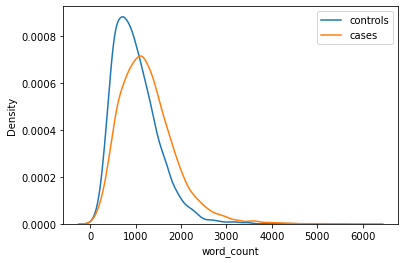

In [79]:
sns.kdeplot(overall_df.loc[overall_df.arf_indicator == 0, 'word_count'])
sns.kdeplot(overall_df.loc[overall_df.arf_indicator == 1, 'word_count'])
plt.legend(['controls', 'cases'])

- Can see similar shape for both, but different peaks and variances
- Quite spread out, suggesting that variance > mean so negative binomial distribution may be suitable to model this

## Calculating parameters of negative binomial distribution

- two key parameters, n and p
    - n = number of successes
    - p = probability of a single success


- can both be calculated from a specified mean (mu) and standard deviation (sd)

#### Defining a function to calculate n and p from the specified mean and standard deviation (which will be taken from the MIMIC subset notes)

In [80]:
def nbinom_params(mu, sd):
    var = sd**2
    n = mu**2/(var - mu)
    p = mu/var
    return(n, p)

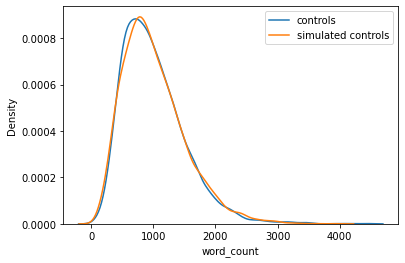

In [83]:
sns.kdeplot(overall_df.loc[overall_df.arf_indicator == 0, 'word_count'])
n, p = nbinom_params(1006.015588, 503.453822)
sns.kdeplot(nbinom.rvs(n, p, size = 7249))
plt.legend(['controls', 'simulated controls'])

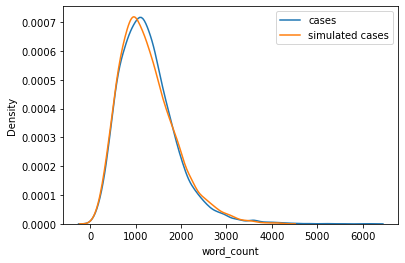

In [84]:
sns.kdeplot(overall_df.loc[overall_df.arf_indicator == 1, 'word_count'])
n, p = nbinom_params(1265.389985, 618.619273)
sns.kdeplot(nbinom.rvs(n, p, size = 7249))
plt.legend(['cases', 'simulated cases'])

## 2. Strong, nondefinite and noise predictors: coefficient thresholds

### Fitting lasso regression and random forest models on BoW representation

In [24]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words= None,lowercase=True, min_df = 0.00)
bow_matrix = vectorizer.fit_transform(overall_df['clean_text3'].values.astype('U'))
outcome = overall_df['arf_indicator']

# random forest
# large number of trees to get a reliable estimate
rf = RandomForestClassifier(n_estimators = 500, verbose = 3) # large number of trees to increase reliability
rf.fit(bow_matrix, outcome)

# lasso logistic
lasso = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 200, C=0.5, verbose = 3)
lasso.fit(bow_matrix, outcome)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 500


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.2min finished


[LibLinear]

LogisticRegression(C=0.5, max_iter=200, penalty='l1', solver='liblinear',
                   verbose=3)

### Checking correlation between lasso coefficients and RF variable importances

In [25]:
coeff = lasso.coef_
feature_names = vectorizer.get_feature_names_out()
coeff_df = pd.DataFrame(coeff).transpose()
coeff_df.columns = ['coeff']
coeff_df['abs_coeff'] = coeff_df['coeff'].abs()
coeff_df['feature_names'] = feature_names
coeff_df.head()

coeff feature_names
0  0.00000            aa
1 -0.18739           aaa
2  0.00000          aaax
3  0.00000      aabdomen
4  0.00000    aabdominal

In [30]:
feature_imp = rf.feature_importances_
colnames = vectorizer.get_feature_names_out()
feature_imp_df = pd.DataFrame({'feature_names':colnames, 'feature_importance' : feature_imp})
feature_imp_df = feature_imp_df.sort_values('feature_importance', ascending = False).reset_index(drop = True)

In [33]:
merged_df = coeff_df.merge(feature_imp_df, 'left', 'feature_names')
merged_df.head()

coeff feature_names  abs_coeff  lasso_rank  lasso_rank_scaled   valence  \
0 -1.824735       oxytoca   1.824735       70368           1.000000  negative   
1 -1.448971          ambu   1.448971       70367           0.999986  negative   
2 -1.416286        unspec   1.416286       70366           0.999972  negative   
3  1.341770     northeast   1.341770       70365           0.999957  positive   
4 -1.299986     sustained   1.299986       70364           0.999943  negative   

   feature_importance  rf_rank  rf_rank_scaled  
0            0.000012    62911        0.894029  
1            0.000008    61578        0.875085  
2            0.000002    54574        0.775551  
3            0.000029    65556        0.931617  
4            0.000013    63076        0.896373

In [4]:
merged_df[['feature_importance', 'abs_coeff']].corr()

feature_importance  abs_coeff
feature_importance            1.000000   0.175256
abs_coeff                     0.175256   1.000000

Correlation is low, meaning that the words that are considered important by the lasso models aren't considered important by the Random Forest model.

So, the parameters that would result in simulated texts behaving similarly to real texts on one model wouldn't necessarily guarantee similar performances on the other model.

For this to happen, this correlation needs to be higher

### The same for TF-IDF
Since correlation is low for BoW

In [21]:
# vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words= None,lowercase=True, min_df = 0.00)
bow_matrix = vectorizer.fit_transform(overall_df['clean_text3'].values.astype('U'))
outcome = overall_df['arf_indicator']

# random forest
rf = RandomForestClassifier(n_estimators = 500, verbose = 2)
rf.fit(bow_matrix, outcome)

# lasso logistic
lasso = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 200, C=0.5, verbose = 2)
lasso.fit(bow_matrix, outcome)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.5min finished


[LibLinear]

LogisticRegression(C=0.5, max_iter=200, penalty='l1', solver='liblinear',
                   verbose=2)

Lasso coefficients

In [22]:
coeff = lasso.coef_
feature_names = vectorizer.get_feature_names_out()
coeff_df = pd.DataFrame(coeff).transpose()
coeff_df.columns = ['coeff']
coeff_df['feature_names'] = feature_names
coeff_df.head()

coeff feature_names
0    0.0            aa
1    0.0           aaa
2    0.0          aaax
3    0.0      aabdomen
4    0.0    aabdominal

In [23]:
coeff_df['abs_coeff'] = coeff_df['coeff'].abs()
coeff_df = coeff_df.sort_values('abs_coeff', ascending = False).reset_index(drop = True)
coeff_df.head()

coeff feature_names  abs_coeff
0  28.081886    intubation  28.081886
1  27.138637      intubate  27.138637
2  21.193631   respiratory  21.193631
3  15.137331     extubated  15.137331
4  13.942429       failure  13.942429

<Axes: xlabel='coeff_rounded', ylabel='Count'>

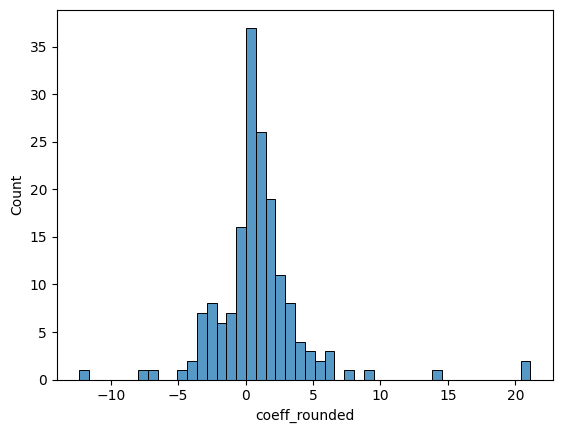

In [8]:
coeffs_for_plot = coeff_df[["coeff"]]
coeffs_for_plot = coeffs_for_plot.loc[coeffs_for_plot.coeff != 0]
coeffs_for_plot["coeff_rounded"] = coeffs_for_plot["coeff"].round(2)
sns.histplot(coeffs_for_plot["coeff_rounded"])

Random forest variable importance

In [24]:
feature_imp = rf.feature_importances_
colnames = vectorizer.get_feature_names_out()
feature_imp_df = pd.DataFrame({'feature_names':colnames, 'feature_importance' : feature_imp})
feature_imp_df = feature_imp_df.sort_values('feature_importance', ascending = False).reset_index(drop = True)

Merging data frames

In [25]:
merged_df = coeff_df.merge(feature_imp_df, 'left', 'feature_names')
merged_df.head()

coeff feature_names  abs_coeff  feature_importance
0  28.081886    intubation  28.081886            0.008721
1  27.138637      intubate  27.138637            0.009878
2  21.193631   respiratory  21.193631            0.009001
3  15.137331     extubated  15.137331            0.003576
4  13.942429       failure  13.942429            0.006281

In [6]:
merged_df[['feature_importance', 'abs_coeff']].corr()

feature_importance  abs_coeff
feature_importance            1.000000   0.675647
abs_coeff                     0.675647   1.000000

#### Much greater correlation
Suggests that TF-IDF may be a better feature representation to use than TF-IDF

### Trying out different thresholds for strong, nondefinite and noise predictors

In [ ]:
df = overall_df

For point of comparison using original data:

In [59]:
# vectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words= None,lowercase=True, min_df = 0.00)
bow_matrix = vectorizer.fit_transform(df['clean_text3'].values.astype('U'))
outcome = df['arf_indicator']

# scoring metrics
scoring = ['f1_macro', 'roc_auc']

# random forest
rf_clf = RandomForestClassifier(n_estimators=100, min_samples_split=0.05, random_state=42)
rf_bow_scores = cross_validate(rf_clf, bow_matrix, outcome, scoring=scoring, cv=5, verbose = 2, return_train_score=False)
rf_bow_scores_df = pd.DataFrame(rf_bow_scores)

# lasso logistic
lasso_bow = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 200, C=0.5)
lasso_bow_scores = cross_validate(lasso_bow, bow_matrix, outcome, scoring=scoring, cv=5, return_train_score=False)
lasso_bow_scores_df = pd.DataFrame(lasso_bow_scores)

[CV] END .................................................... total time=   7.0s
[CV] END .................................................... total time=   7.1s
[CV] END .................................................... total time=   7.2s
[CV] END .................................................... total time=   7.7s
[CV] END .................................................... total time=   7.4s


In [60]:
rf_bow_scores_df.mean()

fit_time         5.862444
score_time       1.427686
test_f1_macro    0.807068
test_roc_auc     0.892679
dtype: float64

In [62]:
lasso_bow_scores_df.mean()

fit_time         1.441190
score_time       0.016279
test_f1_macro    0.839118
test_roc_auc     0.917037
dtype: float64

#### Creating BoW matrix for later

In [63]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words= None,lowercase=True, min_df = 0.00)
bow_matrix = vectorizer.fit_transform(df['clean_text3'].values.astype('U'))
outcome = df['arf_indicator']

In [64]:
bow = pd.DataFrame(bow_matrix.toarray(), columns = vectorizer.get_feature_names_out())
bow.outcome_label = df.arf_indicator
bow.head()

<ipython-input-64-e1f0407be940>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  bow.outcome_label = df.arf_indicator


aa  aaa  aaax  aabdomen  aabdominal  aabsent  aabx  aac  aacei  aacyclovir  \
0   0    0     0         0           0        0     0    0      0           0   
1   0    0     0         0           0        0     0    0      0           0   
2   0    0     0         0           0        0     0    0      0           0   
3   0    0     0         0           0        0     0    0      0           0   
4   0    0     0         0           0        0     0    0      0           0   

   ...  zyprexa  zyr  zyrec  zyrexa  zyrtec  zysyn  zytiga  zytrec  zyvox  \
0  ...        0    0      0       0       0      0       0       0      0   
1  ...        0    0      0       0       0      0       0       0      0   
2  ...        0    0      0       0       0      0       0       0      0   
3  ...        0    0      0       0       0      0       0       0      0   
4  ...        0    0      0       0       0      0       0       0      0   

   zyvoxx  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 70368 columns]

## Trying out different thresholds for strong, nondefinite and noise predictors

In [66]:

for x in [0, 0.01, 0.05]:
    for y in [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]:

        print("Threshold for strong predictors:", y)
        print("Threshold for noise predictors:", x)

        # Labelling predictors in the lasso_coeff df as noise, strong or nondefinite based on coefficient values

        lasso_coeff["type"] = "none"
        lasso_coeff.loc[(lasso_coeff.coeff <= x), "type"] = "noise"
        lasso_coeff.loc[lasso_coeff.coeff >= y, "type"] = "strong_positive"
        lasso_coeff.loc[(lasso_coeff.coeff > x) & (lasso_coeff.coeff < y), "type"] = "nondefinite_positive"

        print(lasso_coeff.type.value_counts())
        
        # determining frequency of each type of predictor using these labels

        n_strong_pos = lasso_coeff.type.value_counts()["strong_positive"]
        n_nondefinite_pos = lasso_coeff.type.value_counts()["nondefinite_positive"]
        n_noise = lasso_coeff.type.value_counts()["noise"]

        # creating lists of feature names for each type of predictor

        strong_pos = list(lasso_coeff.loc[lasso_coeff.type == "strong_positive", "feature_names"])
        nondefinite_pos = list(lasso_coeff.loc[lasso_coeff.type == "nondefinite_positive", "feature_names"])
        noise = list(lasso_coeff.loc[lasso_coeff.type == "noise", "feature_names"])
        
        # number of strong, nondefinite and noise predictors in each document, separately for cases and controls (using BoW matrix created just before loop)

        strong_pos_arf = bow.loc[bow.outcome_label == 1, strong_pos].sum(axis = 1)
        strong_pos_nonarf = bow.loc[bow.outcome_label == 0, strong_pos].sum(axis = 1)
        nondefinite_pos_arf = bow.loc[bow.outcome_label == 1, nondefinite_pos].sum(axis = 1)
        nondefinite_pos_nonarf = bow.loc[bow.outcome_label == 0, nondefinite_pos].sum(axis = 1)
        noise_arf = bow.loc[bow.outcome_label == 1, noise].sum(axis = 1)
        noise_nonarf = bow.loc[bow.outcome_label == 0, noise].sum(axis = 1)
        
        # concatenating these to have a dataset of counts for each type of predictor containing both cases and controls

        strong_pos = pd.concat([strong_pos_nonarf, strong_pos_arf], ignore_index = True)
        nondefinite_pos = pd.concat([nondefinite_pos_nonarf, nondefinite_pos_arf], ignore_index = True)
        noise = pd.concat([noise_nonarf, noise_arf], ignore_index = True)
        
        # further combining these (separate columns for strong, nondefinite and noise counts)

        predictors = pd.DataFrame({'strong_pos': strong_pos, 'nondefinite_pos': nondefinite_pos, 'noise': noise})
        
        # creating the outcome variable, 0 for controls and 1 for cases.
        # order does not matter beyond controls followed by cases, since that is how the datasets were compiled
        
        outcome = outcome = [*np.repeat(0, 7249), *np.repeat(1, 7249)]

        predictors["outcome_label"] = outcome
        
        # using the counts per document per predictor, creating a list of distributions of strong, nondefinite and noise predictors per document 

        distr0 = [predictors.loc[predictors.outcome_label == 0, ["strong_pos"]].values, predictors.loc[predictors.outcome_label == 0, ["nondefinite_pos"]].values, predictors.loc[predictors.outcome_label == 0, ["noise"]].values]
        distr1 = [predictors.loc[predictors.outcome_label == 1, ["strong_pos"]].values, predictors.loc[predictors.outcome_label == 1, ["nondefinite_pos"]].values, predictors.loc[predictors.outcome_label == 1, ["noise"]].values]

        # simulating contents of documents
        
        docs0 = [[*np.random.choice(range(n_strong_pos + 1),size = distr0[0][x], replace=True), # since there are 20 strong predictors, these correspond to a range of 0-20; how many are chosen is dependent on the frequency in the lists created above
             *np.random.choice(range(n_strong_pos + 1, n_strong_pos + n_nondefinite_pos + 1),size = distr0[1][x], replace=True),
                *np.random.choice(range(n_strong_pos + n_nondefinite_pos + 1, n_strong_pos + n_nondefinite_pos + n_noise + 1),size = distr0[2][x], replace=True)]for x in range(7249)]

        docs1 = [[*np.random.choice(range(n_strong_pos + 1),size = distr1[0][x], replace=True),
             *np.random.choice(range(n_strong_pos + 1, n_strong_pos + n_nondefinite_pos + 1),size = distr1[1][x], replace=True),
             *np.random.choice(range(n_strong_pos + n_nondefinite_pos + 1, n_strong_pos + n_nondefinite_pos + n_noise + 1),size = distr1[2][x], replace=True)]for x in range(7249)]


        docspd1 = pd.DataFrame({"docs" : [i for i in docs1]}) # each list of numbers is a row
        docspd1 = docspd1.astype(str) # converting to string format
        docspd1["docs"] = docspd1["docs"].str.strip("[]") # removing the square brackets
        docspd1 = docspd1["docs"] # converting to series, as the output of the original function is a series object
        docspd0 = pd.DataFrame({"docs" : [i for i in docs0]})
        docspd0 = docspd0.astype(str)
        docspd0["docs"] = docspd0["docs"].str.strip("[]")
        docspd0 = docspd0["docs"]

        # combining both series into a single object
        docslist01 = pd.concat([docspd0, docspd1], ignore_index = True)

        vectorizer = TfidfVectorizer(use_idf = True)

        BOW_training_data_sim = vectorizer.fit_transform(docslist01)

        lasso_bow_sim = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 200, C=0.5)

        scoring = ['f1_macro', "roc_auc"]

        print("cross-validating lasso")

        lasso_bowsim_scores = cross_validate(lasso_bow_sim, BOW_training_data_sim, outcome, scoring=scoring, cv=5, return_train_score=False, verbose = 2)

        lasso_bowsim_scores_df = pd.DataFrame(lasso_bowsim_scores)

        lasso_diff_scores = lasso_bow_scores_df.mean() - lasso_bowsim_scores_df.mean()

        print('LASSO', lasso_diff_scores)



Threshold for strong predictors: 0.5
Threshold for noise predictors: 0
noise                   70270
strong_positive            76
nondefinite_positive       22
Name: type, dtype: int64
cross-validating lasso
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   2.5s
LASSO fit_time        -1.083213
score_time      -0.006484
test_f1_macro    0.080986
test_roc_auc     0.081890
dtype: float64
Threshold for strong predictors: 1
Threshold for noise predictors: 0
noise                   70270
strong_positive            54
nondefinite_positive       44
Name: type, dtype: int64
cross-validating lasso
[CV] END .............................................

#### Creating dataframe with counts of predictor types

Using the thresholds resulting in the most similar performance to the real texts

In [ ]:
lasso_coeff["type"] = "none"
lasso_coeff.loc[(lasso_coeff.coeff <= 0.05), "type"] = "noise"
lasso_coeff.loc[lasso_coeff.coeff >= 3.5, "type"] = "strong_positive"
lasso_coeff.loc[(lasso_coeff.coeff > 0) & (lasso_coeff.coeff < 3.5), "type"] = "nondefinite_positive"

print(lasso_coeff.type.value_counts())
        
# determining frequency of each type of predictor using these labels

n_strong_pos = lasso_coeff.type.value_counts()["strong_positive"]
n_nondefinite_pos = lasso_coeff.type.value_counts()["nondefinite_positive"]
n_noise = lasso_coeff.type.value_counts()["noise"]

# creating lists of feature names for each type of predictor

strong_pos = list(lasso_coeff.loc[lasso_coeff.type == "strong_positive", "feature_names"])
nondefinite_pos = list(lasso_coeff.loc[lasso_coeff.type == "nondefinite_positive", "feature_names"])
noise = list(lasso_coeff.loc[lasso_coeff.type == "noise", "feature_names"])
        
# number of strong, nondefinite and noise predictors in each document, separately for cases and controls (using BoW matrix created just before loop)

strong_pos_arf = bow.loc[bow.outcome_label == 1, strong_pos].sum(axis = 1)
strong_pos_nonarf = bow.loc[bow.outcome_label == 0, strong_pos].sum(axis = 1)
nondefinite_pos_arf = bow.loc[bow.outcome_label == 1, nondefinite_pos].sum(axis = 1)
nondefinite_pos_nonarf = bow.loc[bow.outcome_label == 0, nondefinite_pos].sum(axis = 1)
noise_arf = bow.loc[bow.outcome_label == 1, noise].sum(axis = 1)
noise_nonarf = bow.loc[bow.outcome_label == 0, noise].sum(axis = 1)
        
# concatenating these to have a dataset of counts for each type of predictor containing both cases and controls

strong_pos = pd.concat([strong_pos_nonarf, strong_pos_arf], ignore_index = True)
nondefinite_pos = pd.concat([nondefinite_pos_nonarf, nondefinite_pos_arf], ignore_index = True)
noise = pd.concat([noise_nonarf, noise_arf], ignore_index = True)
        
# further combining these (separate columns for strong, nondefinite and noise counts)

predictors = pd.DataFrame({'strong_pos': strong_pos, 'nondefinite_pos': nondefinite_pos, 'noise': noise})

## 3. Comparing simulations and actual notes

### Actual text

In [29]:
outcome = df["arf_indicator"]

vectorizer = TfidfVectorizer()

tfidf_training_data = vectorizer.fit_transform(df['clean_text3'])

lasso_tfidf = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 200, C=0.5)

elasticnet_tfidf = LogisticRegression(penalty = "elasticnet", solver = 'saga', max_iter = 500, random_state = 5, C = 0.5, l1_ratio = 0.5)

rf_tfidf = RandomForestClassifier(n_estimators=100, min_samples_split = 0.05, random_state=42)

scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro', 'roc_auc']

# cross-validation

lasso_tfidf_scores = cross_validate(lasso_tfidf, tfidf_training_data, outcome, scoring=scoring, cv=RepeatedKFold(n_splits = 5, n_repeats = 5), return_train_score=False)

elasticnet_tfidf_scores = cross_validate(elasticnet_tfidf, tfidf_training_data, outcome, scoring=scoring, cv=RepeatedKFold(n_splits = 5, n_repeats = 5), return_train_score=False)

rf_tfidf_scores = cross_validate(rf_tfidf, tfidf_training_data, outcome, scoring=scoring, cv=RepeatedKFold(n_splits = 5, n_repeats = 5), return_train_score=False)

# df with cross-validated performance metrics

lasso_tfidf_scores_df = pd.DataFrame(lasso_tfidf_scores)

elasticnet_tfidf_scores_df = pd.DataFrame(elasticnet_tfidf_scores)

rf_tfidf_scores_df = pd.DataFrame(rf_tfidf_scores)

In [ ]:
lasso_tfidf_scores_df.mean()

fit_time                1.639778
score_time              0.050854
test_precision_macro    0.839356
test_recall_macro       0.839168
test_precision_micro    0.839137
test_recall_micro       0.839137
test_f1_micro           0.839137
test_f1_macro           0.839087
test_roc_auc            0.916998
dtype: float64

In [16]:
elasticnet_tfidf_scores_df.mean()

fit_time                3.409800
score_time              0.022471
test_precision_macro    0.835611
test_recall_macro       0.835571
test_precision_micro    0.835550
test_recall_micro       0.835550
test_f1_micro           0.835550
test_f1_macro           0.835519
test_roc_auc            0.910220
dtype: float64

In [18]:
rf_tfidf_scores_df.mean()

fit_time                6.577298
score_time              0.924457
test_precision_macro    0.814888
test_recall_macro       0.809336
test_precision_micro    0.809242
test_recall_micro       0.809242
test_f1_micro           0.809242
test_f1_macro           0.808374
test_roc_auc            0.893933
dtype: float64

### Simulation

Based on threshold obtained in the previous section

#### Creating word count and proportion variables in the predictors dataset created earlier

In [7]:
predictors['word_count'] = predictors.strong_pos + predictors.nondefinite_pos + predictors.noise

In [8]:
predictors['prop_strong_pos'] = predictors.strong_pos/predictors.word_count
predictors['prop_nondef_pos'] = predictors.nondefinite_pos/predictors.word_count
predictors['prop_noise'] = predictors.noise/predictors.word_count

In [29]:
for i in predictors.loc[:, ["prop_strong_pos", "prop_nondef_pos", "prop_noise", "word_count"]]:
    print(i, predictors.groupby('arf_indicator')[i].describe())

prop_strong_pos                 count      mean       std  min       25%       50%       75%  \
arf_indicator                                                                  
0              7249.0  0.006708  0.006143  0.0  0.002469  0.005038  0.009223   
1              7249.0  0.017398  0.009262  0.0  0.010801  0.015810  0.022272   

                    max  
arf_indicator            
0              0.061017  
1              0.085890  
prop_nondef_pos                 count      mean       std       min       25%       50%  \
arf_indicator                                                             
0              7249.0  0.064966  0.024135  0.007177  0.047468  0.064081   
1              7249.0  0.090897  0.020410  0.018519  0.077460  0.090333   

                    75%       max  
arf_indicator                      
0              0.080545  0.172811  
1              0.103907  0.180180  
prop_noise                 count      mean       std       min       25%       50%  \
arf_indicato

The summary statistics for the word_count variable have been reported in the word counts table (Table 2) in the Methods section, for the "after preprocessing" section

Next, generating word counts for individual documents using the mean and standard deviations for the two groups;

Then specifying the proportion of strong, nondefinite and noise predictors within each document for the two outcome groups;

Using these proportions to generate the absolute number of each type of predictor to include in each document

In [46]:
n, p = nbinom_params(1229.539523, 603.608061)
word_counts_pos = nbinom.rvs(n, p, size = 7249)

n, p = nbinom_params(977.096979, 490.480307)
word_counts_neg = nbinom.rvs(n, p, size = 7249) 

p1 = [0.02, 0.09, 0.89]
p0 = [0.01, 0.06, 0.92]

distr0 = [np.random.multinomial(word_counts_neg[x], p0) for x in range(7249)]
distr1 = [np.random.multinomial(word_counts_pos[x], p1) for x in range(7249)]

Specifying the frequency of each type of predictor in the whole vocabulary

In [48]:
n_strong_pos = 20
n_nondefinite_pos = 77
n_noise = 70271

Simulating contents of each document using the parameters defined above

In [49]:
docs0 = [[*np.random.choice(range(n_strong_pos + 1),size = distr0[x][0], replace=True),
         *np.random.choice(range(n_strong_pos + 1, n_strong_pos + n_nondefinite_pos + 1),size = distr0[x][1], replace=True),
            *np.random.choice(range(n_strong_pos + n_nondefinite_pos + 1, n_strong_pos + n_nondefinite_pos + n_noise + 1),size = distr0[x][2], replace=True)]for x in range(7249)]

docs1 = [[*np.random.choice(range(n_strong_pos + 1),size = distr1[x][0], replace=True),
         *np.random.choice(range(n_strong_pos + 1, n_strong_pos + n_nondefinite_pos + 1),size = distr1[x][1], replace=True),
         *np.random.choice(range(n_strong_pos + n_nondefinite_pos + 1, n_strong_pos + n_nondefinite_pos + n_noise + 1),size = distr1[x][2], replace=True)]for x in range(7249)]


Combining documents for the positive and negative classes into a single dataframe, and creating the outcome vector

In [50]:
docspd1 = pd.DataFrame({"docs" : [i for i in docs1]}) # each list of numbers is a row
docspd1 = docspd1.astype(str) # converting to string format
docspd1["docs"] = docspd1["docs"].str.strip("[]") # removing the square brackets
docspd1 = docspd1["docs"] # converting to series, as the output of the original function is a series object
docspd0 = pd.DataFrame({"docs" : [i for i in docs0]})
docspd0 = docspd0.astype(str)
docspd0["docs"] = docspd0["docs"].str.strip("[]")
docspd0 = docspd0["docs"]

# combining both series into a single object
docslist01 = docspd0.append(docspd1, ignore_index = True)
# creating the outcome
outcome = [*np.repeat(0, 7249), *np.repeat(1, 7249)]     

C:\Users\saniy\AppData\Local\Temp\ipykernel_29716\1435423837.py:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  docslist01 = docspd0.append(docspd1, ignore_index = True)


Fitting lasso and random forest models on TF-IDF representation of simulated dataset

In [51]:
vectorizer = TfidfVectorizer()

tfidf_training_data_sim = vectorizer.fit_transform(docslist01)

lasso_tfidf_sim = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 200, C=0.5)

elasticnet_tfidf_sim = LogisticRegression(penalty = "elasticnet", solver = 'saga', max_iter = 500, random_state = 5, C = 0.5, l1_ratio = 0.5)

rf_clf = RandomForestClassifier(n_estimators=100, min_samples_split = 0.05, random_state=42)

scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro', 'roc_auc']

# cross-validation

lasso_tfidfsim_scores = cross_validate(lasso_tfidf_sim, tfidf_training_data_sim, outcome, scoring=scoring, cv=RepeatedKFold(n_splits = 5, n_repeats = 5), return_train_score=False)

elasticnet_tfidfsim_scores = cross_validate(elasticnet_tfidf_sim, tfidf_training_data_sim, outcome, scoring=scoring, cv=RepeatedKFold(n_splits = 5, n_repeats = 5), return_train_score=False)

rf_tfidf_scores = cross_validate(rf_clf, tfidf_training_data_sim, outcome, scoring=scoring, cv=RepeatedKFold(n_splits = 5, n_repeats = 5), return_train_score=False, verbose = 3)

# df with cross-validated performance metrics

lasso_tfidfsim_scores_df = pd.DataFrame(lasso_tfidfsim_scores)

elasticnet_tfidfsim_scores_df = pd.DataFrame(elasticnet_tfidfsim_scores)

rf_tfidfsim_scores_df = pd.DataFrame(rf_tfidfsim_scores)

In [52]:
lasso_tfidfsim_scores_df.mean()

fit_time                1.749469
score_time              0.041856
test_precision_macro    0.856484
test_recall_macro       0.855023
test_precision_micro    0.854973
test_recall_micro       0.854973
test_f1_micro           0.854973
test_f1_macro           0.854797
test_roc_auc            0.930219
dtype: float64

In [17]:
elasticnet_tfidfsim_scores_df.mean()

fit_time                3.401541
score_time              0.031520
test_precision_macro    0.858879
test_recall_macro       0.855712
test_precision_micro    0.855691
test_recall_micro       0.855691
test_f1_micro           0.855691
test_f1_macro           0.855321
test_roc_auc            0.926954
dtype: float64

In [20]:
rf_tfidfsim_scores_df.mean()

fit_time                14.517286
score_time               1.653412
test_precision_macro     0.846606
test_recall_macro        0.844730
test_precision_micro     0.844655
test_recall_micro        0.844655
test_f1_micro            0.844655
test_f1_macro            0.844415
test_roc_auc             0.925683
dtype: float64

#### From original dataset (copied from above for comparison)

In [ ]:
lasso_tfidf_scores_df.mean()

fit_time                1.639778
score_time              0.050854
test_precision_macro    0.839356
test_recall_macro       0.839168
test_precision_micro    0.839137
test_recall_micro       0.839137
test_f1_micro           0.839137
test_f1_macro           0.839087
test_roc_auc            0.916998
dtype: float64

In [16]:
elasticnet_tfidf_scores_df.mean()

fit_time                3.409800
score_time              0.022471
test_precision_macro    0.835611
test_recall_macro       0.835571
test_precision_micro    0.835550
test_recall_micro       0.835550
test_f1_micro           0.835550
test_f1_macro           0.835519
test_roc_auc            0.910220
dtype: float64

In [18]:
rf_tfidf_scores_df.mean()

fit_time                6.577298
score_time              0.924457
test_precision_macro    0.814888
test_recall_macro       0.809336
test_precision_micro    0.809242
test_recall_micro       0.809242
test_f1_micro           0.809242
test_f1_macro           0.808374
test_roc_auc            0.893933
dtype: float64

Similar scores suggest that these parameters are appropriate

### Defining a text simulation function with the above values as the default

In [ ]:
def simulate_texts(sample_size = 14498, # overall sample size
                   prevalence = 0.5, # prevalence of positive class
                   n_strong = 20, # number of strong predictors
                   n_nondefinite = 77, # number of nondefinite predictors
                   arf_wc_mean_sd = (1229.539523, 603.608061), # mean, sd of word counts per document for positive class
                   nonarf_wc_mean_sd = (977.096979, 490.480307), # mean, sd of word counts per document for negative class
                   p0 = [0.01, 0.06, 0.92], # mean proportion of strong, nondefinite and noise predictors per document for negative class
                   p1 = [0.02, 0.09, 0.89],
                   n_noise = 70271): # mean proportion of strong, nondefinite and noise predictors per document for positive class
   
    # calculating number of observations per class
   
    pos_class = round(prevalence * sample_size)
    neg_class = sample_size - pos_class
   
    print('Class 0:', neg_class, 'Class 1:', pos_class)
   
    # calculating negative binomial parameters based on mean and standard deviations of word counts
   
    n, p = nbinom_params(arf_wc_mean_sd[0], arf_wc_mean_sd[1])
    word_counts_pos = nbinom.rvs(n, p, size = pos_class)
 
    n, p = nbinom_params(nonarf_wc_mean_sd[0], nonarf_wc_mean_sd[1])
    word_counts_neg = nbinom.rvs(n, p, size = neg_class)
   
    # number of strong, nondefinite and noise predictors in each document, calculated per class based on distributions provided
   
    distr0 = [np.random.multinomial(word_counts_neg[x], p0) for x in range(neg_class)]
    distr1 = [np.random.multinomial(word_counts_pos[x], p1) for x in range(pos_class)]
   
    # simulating texts
   
    docs0 = [[*np.random.choice(range(n_strong + 1),size = distr0[x][0], replace=True),
         *np.random.choice(range(n_strong + 1, n_strong + n_nondefinite + 1),size = distr0[x][1], replace=True),
            *np.random.choice(range(n_strong + n_nondefinite + 1, n_strong + n_nondefinite + n_noise + 1),size = distr0[x][2], replace=True)]for x in range(neg_class)]
 
    docs1 = [[*np.random.choice(range(n_strong + 1),size = distr1[x][0], replace=True),
         *np.random.choice(range(n_strong + 1, n_strong + n_nondefinite + 1),size = distr1[x][1], replace=True),
         *np.random.choice(range(n_strong + n_nondefinite + 1, n_strong + n_nondefinite + n_noise + 1),size = distr1[x][2], replace=True)]for x in range(pos_class)]
   
    
    # combining documents from both classes
   
    docspd1 = pd.DataFrame({"docs" : [i for i in docs1]}) # each list of numbers is a row
    docspd1 = docspd1.astype(str) # converting to string format
    docspd1["docs"] = docspd1["docs"].str.strip("[]") # removing the square brackets
    docspd1 = docspd1["docs"] # converting to series, as the output of the original function is a series object
    docspd0 = pd.DataFrame({"docs" : [i for i in docs0]})
    docspd0 = docspd0.astype(str)
    docspd0["docs"] = docspd0["docs"].str.strip("[]")
    docspd0 = docspd0["docs"]
 
    # combining both series into a single object
    docslist01 = pd.concat([docspd0, docspd1], ignore_index = True)
    # creating the outcome
    outcome = [*np.repeat(0, neg_class), *np.repeat(1, pos_class)] 
    
    return(docslist01, outcome)
 
   

#### Examining vocabulary sizes

In [8]:
# MIMIC
features_mimic = []
mean_features_mimic = []

for sample_size in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 3000, 4000, 5000, 6000, 8000, 10000, 12000, 14000, 14498]:
    print(sample_size)
    features_mimic = []
    for rep in range(10):
        print(rep)
        subset = mimic.groupby("arf_indicator").sample(round(sample_size/2)) # selecting random subset of MIMIC data
        outcome = subset.arf_indicator
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(subset["clean_text3"]) # fitting TFIDF model on text
        features_mimic.append(tfidf_matrix.shape[1]) # saving number of columns in the TFIDF matrix, i.e., the number of features/words
        
    mean_features_mimic.append(np.mean(features_mimic))

50
0
1
2
3
4
5
6
7
8
9
100
0
1
2
3
4
5
6
7
8
9
200
0
1
2
3
4
5
6
7
8
9
300
0
1
2
3
4
5
6
7
8
9
400
0
1
2
3
4
5
6
7
8
9
500
0
1
2
3
4
5
6
7
8
9
600
0
1
2
3
4
5
6
7
8
9
700
0
1
2
3
4
5
6
7
8
9
800
0
1
2
3
4
5
6
7
8
9
900
0
1
2
3
4
5
6
7
8
9
1000
0
1
2
3
4
5
6
7
8
9
1250
0
1
2
3
4
5
6
7
8
9
1500
0
1
2
3
4
5
6
7
8
9
1750
0
1
2
3
4
5
6
7
8
9
2000
0
1
2
3
4
5
6
7
8
9
3000
0
1
2
3
4
5
6
7
8
9
4000
0
1
2
3
4
5
6
7
8
9
5000
0
1
2
3
4
5
6
7
8
9
6000
0
1
2
3
4
5
6
7
8
9
8000
0
1
2
3
4
5
6
7
8
9
10000
0
1
2
3
4
5
6
7
8
9
12000
0
1
2
3
4
5
6
7
8
9
14000
0
1
2
3
4
5
6
7
8
9
14498
0
1
2
3
4
5
6
7
8
9


In [11]:
features_sim_before = []
mean_features_sim_before = []

for sample_size in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 3000, 4000, 5000, 6000, 8000, 10000, 12000, 14000, 14498]:
    print(sample_size)
    features_sim_before = []
    for rep in range(10):
        print(rep)
        docslist01, outcome = simulate_texts(sample_size = sample_size) # simulating dataset
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(docslist01) # fitting TFIDF on simulated text
        features_sim_before.append(tfidf_matrix.shape[1]) # saving number of unique "words" in the simulated dataset
        
    mean_features_sim_before.append(np.mean(features_sim_before))

50
0
Class 0: 25 Class 1: 25
1
Class 0: 25 Class 1: 25
2
Class 0: 25 Class 1: 25
3
Class 0: 25 Class 1: 25
4
Class 0: 25 Class 1: 25
5
Class 0: 25 Class 1: 25
6
Class 0: 25 Class 1: 25
7
Class 0: 25 Class 1: 25
8
Class 0: 25 Class 1: 25
9
Class 0: 25 Class 1: 25
100
0
Class 0: 50 Class 1: 50
1
Class 0: 50 Class 1: 50
2
Class 0: 50 Class 1: 50
3
Class 0: 50 Class 1: 50
4
Class 0: 50 Class 1: 50
5
Class 0: 50 Class 1: 50
6
Class 0: 50 Class 1: 50
7
Class 0: 50 Class 1: 50
8
Class 0: 50 Class 1: 50
9
Class 0: 50 Class 1: 50
200
0
Class 0: 100 Class 1: 100
1
Class 0: 100 Class 1: 100
2
Class 0: 100 Class 1: 100
3
Class 0: 100 Class 1: 100
4
Class 0: 100 Class 1: 100
5
Class 0: 100 Class 1: 100
6
Class 0: 100 Class 1: 100
7
Class 0: 100 Class 1: 100
8
Class 0: 100 Class 1: 100
9
Class 0: 100 Class 1: 100
300
0
Class 0: 150 Class 1: 150
1
Class 0: 150 Class 1: 150
2
Class 0: 150 Class 1: 150
3
Class 0: 150 Class 1: 150
4
Class 0: 150 Class 1: 150
5
Class 0: 150 Class 1: 150
6
Class 0: 150 Cl

#### Slightly modifying the simulation function to specify the number of noise predictors as a function of the sample size (linear approximation)

In [22]:
def simulate_texts(sample_size = 14498, # overall sample size
                   prevalence = 0.5, # prevalence of positive class
                   n_strong = 20, # number of strong predictors
                   n_nondefinite = 77, # number of nondefinite predictors
                   arf_wc_mean_sd = (1229.539523, 603.608061), # mean, sd of word counts per document for positive class
                   nonarf_wc_mean_sd = (977.096979, 490.480307), # mean, sd of word counts per document for negative class
                   p0 = [0.01, 0.06, 0.92], # mean proportion of strong, nondefinite and noise predictors per document for negative class
                   p1 = [0.02, 0.09, 0.89]): # mean proportion of strong, nondefinite and noise predictors per document for positive class
   
    n_noise = min([(70368 - (n_strong + n_nondefinite)), round(8000 + (sample_size * 5))])
   
    # calculating number of observations per class
   
    pos_class = round(prevalence * sample_size)
    neg_class = sample_size - pos_class
   
    print('Class 0:', neg_class, 'Class 1:', pos_class)
   
    # calculating negative binomial parameters based on mean and standard deviations of word counts
   
    n, p = nbinom_params(arf_wc_mean_sd[0], arf_wc_mean_sd[1])
    word_counts_pos = nbinom.rvs(n, p, size = pos_class)
 
    n, p = nbinom_params(nonarf_wc_mean_sd[0], nonarf_wc_mean_sd[1])
    word_counts_neg = nbinom.rvs(n, p, size = neg_class)
   
    # number of strong, nondefinite and noise predictors in each document, calculated per class based on distributions provided
   
    distr0 = [np.random.multinomial(word_counts_neg[x], p0) for x in range(neg_class)]
    distr1 = [np.random.multinomial(word_counts_pos[x], p1) for x in range(pos_class)]
   
    # simulating texts
   
    docs0 = [[*np.random.choice(range(n_strong + 1),size = distr0[x][0], replace=True),
         *np.random.choice(range(n_strong + 1, n_strong + n_nondefinite + 1),size = distr0[x][1], replace=True),
            *np.random.choice(range(n_strong + n_nondefinite + 1, n_strong + n_nondefinite + n_noise + 1),size = distr0[x][2], replace=True)]for x in range(neg_class)]
 
    docs1 = [[*np.random.choice(range(n_strong + 1),size = distr1[x][0], replace=True),
         *np.random.choice(range(n_strong + 1, n_strong + n_nondefinite + 1),size = distr1[x][1], replace=True),
         *np.random.choice(range(n_strong + n_nondefinite + 1, n_strong + n_nondefinite + n_noise + 1),size = distr1[x][2], replace=True)]for x in range(pos_class)]
   
    
    # combining documents from both classes
   
    docspd1 = pd.DataFrame({"docs" : [i for i in docs1]}) # each list of numbers is a row
    docspd1 = docspd1.astype(str) # converting to string format
    docspd1["docs"] = docspd1["docs"].str.strip("[]") # removing the square brackets
    docspd1 = docspd1["docs"] # converting to series, as the output of the original function is a series object
    docspd0 = pd.DataFrame({"docs" : [i for i in docs0]})
    docspd0 = docspd0.astype(str)
    docspd0["docs"] = docspd0["docs"].str.strip("[]")
    docspd0 = docspd0["docs"]
 
    # combining both series into a single object
    docslist01 = pd.concat([docspd0, docspd1], ignore_index = True)
    # creating the outcome
    outcome = [*np.repeat(0, neg_class), *np.repeat(1, pos_class)] 
    
    return(docslist01, outcome)
 
   

In [9]:
features_sim = []
mean_features_sim = []

for sample_size in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 3000, 4000, 5000, 6000, 8000, 10000, 12000, 14000, 14498]:
    print(sample_size)
    features_sim = []
    for rep in range(10):
        print(rep)
        docslist01, outcome = simulate_texts(sample_size = sample_size)
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(docslist01)
        features_sim.append(tfidf_matrix.shape[1])
        
    mean_features_sim.append(np.mean(features_sim))

50
0
Class 0: 25 Class 1: 25
1
Class 0: 25 Class 1: 25
2
Class 0: 25 Class 1: 25
3
Class 0: 25 Class 1: 25
4
Class 0: 25 Class 1: 25
5
Class 0: 25 Class 1: 25
6
Class 0: 25 Class 1: 25
7
Class 0: 25 Class 1: 25
8
Class 0: 25 Class 1: 25
9
Class 0: 25 Class 1: 25
100
0
Class 0: 50 Class 1: 50
1
Class 0: 50 Class 1: 50
2
Class 0: 50 Class 1: 50
3
Class 0: 50 Class 1: 50
4
Class 0: 50 Class 1: 50
5
Class 0: 50 Class 1: 50
6
Class 0: 50 Class 1: 50
7
Class 0: 50 Class 1: 50
8
Class 0: 50 Class 1: 50
9
Class 0: 50 Class 1: 50
200
0
Class 0: 100 Class 1: 100
1
Class 0: 100 Class 1: 100
2
Class 0: 100 Class 1: 100
3
Class 0: 100 Class 1: 100
4
Class 0: 100 Class 1: 100
5
Class 0: 100 Class 1: 100
6
Class 0: 100 Class 1: 100
7
Class 0: 100 Class 1: 100
8
Class 0: 100 Class 1: 100
9
Class 0: 100 Class 1: 100
300
0
Class 0: 150 Class 1: 150
1
Class 0: 150 Class 1: 150
2
Class 0: 150 Class 1: 150
3
Class 0: 150 Class 1: 150
4
Class 0: 150 Class 1: 150
5
Class 0: 150 Class 1: 150
6
Class 0: 150 Cl

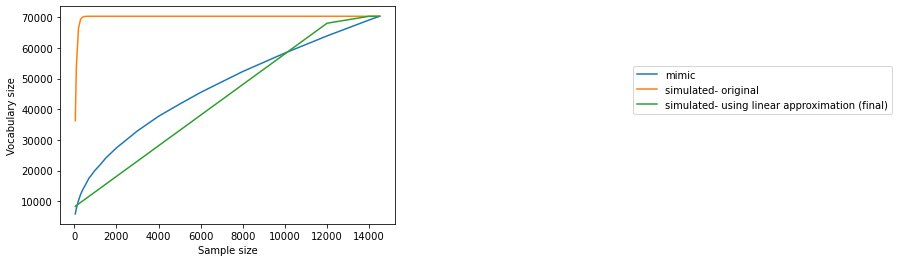

In [12]:
# plotting a graph of these results
samples = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 3000, 4000, 5000, 6000, 8000, 10000, 12000, 14000, 14498]
sns.lineplot(x = samples, y = mean_features_mimic)
sns.lineplot(x = samples, y = mean_features_sim_before)
sns.lineplot(x = samples, y = mean_features_sim)
plt.xlabel("Sample size")
plt.ylabel("Vocabulary size")
plt.legend(["mimic", "simulated- original", "simulated- using linear approximation (final)"], loc='upper right', bbox_to_anchor=(2.5, 0.75))


### Taking subsets of the MIMIC-III dataset and fitting models, comparing it with simulations of the same size:

#### MIMIC-III

Calculating Youden's Index (adapted from code by Diana Shamsutdinova)

In [3]:
def youden_point(target, predict): # function to find the youden point
    fpr, tpr, threshold = roc_curve(target, predict) # where fpr = false positive rate, tpr = true positive rate and threshold = the probability threshold for classifying an observation as having the outcome
    threshold = threshold[1:]
    fpr = fpr[1:]
    tpr = tpr[1:]
    i = np.arange(len(tpr)) # generating an array of length corresponding to the tpr vector
    roc = pd.DataFrame({'tp': pd.Series(tpr, index=i) , # creating a dataframe with four columns
                        '1-fpr' : pd.Series((1-fpr), index=i),
                        'sum': pd.Series(tpr+(1-fpr), index=i),
                        'threshold' : pd.Series(threshold, index=i)})
    k = np.argmax(roc["sum"]) # finding the maximum sum of the tpr and (1-fpr)
    return (roc.loc[k, "threshold"]) # returning this

In [43]:
# MIMIC

# the first four lists will be filled with scores from each iteration

f1_list_log_mimic = [] 
f1_list_rf_mimic = []
roc_auc_list_rf_mimic = []
roc_auc_list_log_mimic = []

# these four lists will contain means of scores from each sample size

overall_f1_list_log_mimic = [] 
overall_f1_list_rf_mimic = []
overall_roc_auc_list_log_mimic = []
overall_roc_auc_list_rf_mimic = []

scoring = ['f1', 'roc_auc']

for sample_size in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    print(sample_size)
    # resetting list for every sample size
    f1_list_log_mimic = [] 
    f1_list_rf_mimic = []
    roc_auc_list_rf_mimic = []
    roc_auc_list_log_mimic = []
    for rep in range(10):
        print(rep)
        subset = mimic.groupby("arf_indicator").sample(round(sample_size/2)) # taking a random subset of samples
        remaining = mimic.loc[~mimic.hadm_id.isin(subset.hadm_id)] # creating a dataset with the remainin observations, to draw a test dataset from
        outcome = subset.arf_indicator
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(subset["clean_text3"]) # TF-IDF representation of texts
        
        test_set = remaining.groupby("arf_indicator").sample(5000) # drawing a random sample to act as the test set
        test_outcome = test_set.arf_indicator
        
        test_tfidf_training_data_01 = tfidf.transform(test_set["clean_text3"]) # using TFIDF object from training set to transform test set
        
        rf = RandomForestClassifier(n_estimators=100, min_samples_split =0.05, random_state=42)
        logreg = LogisticRegression(penalty = "elasticnet", solver = 'saga', max_iter = 500, random_state = 5, C = 0.5, l1_ratio = 0.5)

        # fitting elastic net and random forest models
        rf.fit(tfidf_matrix, outcome) 
        logreg.fit(tfidf_matrix, outcome)

        # generating predictions from test set
        predicted_rf = rf.predict_proba(test_tfidf_training_data_01)[:,1] 
        predicted_logit = logreg.predict_proba(test_tfidf_training_data_01)[:,1]

        # generating predictions from training set
        predicted_rf_train = rf.predict_proba(tfidf_matrix)[:,1] 
        predicted_logit_train = logreg.predict_proba(tfidf_matrix)[:,1]

        # calculating Youden's index
        yp_rf_train = youden_point(outcome, predicted_rf_train) 
        yp_logit_train = youden_point(outcome, predicted_logit_train)

        predicted_youdenTrain_rf = [1 if predicted_rf[i]> yp_rf_train else 0 for i in range(len(predicted_rf))]
        predicted_youdenTrain_logit = [1 if predicted_logit[i]> yp_logit_train else 0 for i in range(len(predicted_logit))]
        
        # calculating F1 score at Youden's index
        f1_rf = f1_score(test_outcome, predicted_youdenTrain_rf) 
        f1_logit = f1_score(test_outcome, predicted_youdenTrain_logit)
        
        auc_rf = roc_auc_score(test_outcome, predicted_rf)
        auc_logit = roc_auc_score(test_outcome, predicted_logit)
        
        # adding scores to list
        f1_list_log_mimic.append(f1_logit) 
        f1_list_rf_mimic.append(f1_rf)
        
        roc_auc_list_rf_mimic.append(auc_rf)
        roc_auc_list_log_mimic.append(auc_logit)
        
    # calculating means of scores for each sample size
        
    overall_f1_list_log_mimic.append(sum(f1_list_log_mimic)/len(f1_list_log_mimic))
    overall_f1_list_rf_mimic.append(sum(f1_list_rf_mimic)/len(f1_list_rf_mimic))
    overall_roc_auc_list_log_mimic.append(sum(roc_auc_list_log_mimic)/len(roc_auc_list_log_mimic))
    overall_roc_auc_list_rf_mimic.append(sum(roc_auc_list_rf_mimic)/len(roc_auc_list_rf_mimic))

50
0
1
2
3
4
5
6
7
8
9
100
0
1
2
3
4
5
6
7
8
9
200
0
1
2
3
4
5
6
7
8
9
300
0
1
2
3
4
5
6
7
8
9
400
0
1
2
3
4
5
6
7
8
9
500
0
1
2
3
4
5
6
7
8
9
600
0
1
2
3
4
5
6
7
8
9
700
0
1
2
3
4
5
6
7
8
9
800
0
1
2
3
4
5
6
7
8
9
900
0
1
2
3
4
5
6
7
8
9
1000
0
1
2
3
4
5
6
7
8
9
1250
0
1
2
3
4
5
6
7
8
9
1500
0
1
2
3
4
5
6
7
8
9
1750
0
1
2
3
4
5
6
7
8
9
2000
0
1
2
3
4
5
6
7
8
9


#### Simulated

In [23]:
# simulated

# the first four lists will be filled with scores from each iteration

f1_list_log_sim = []
f1_list_rf_sim = []
roc_auc_list_rf_sim = []
roc_auc_list_log_sim = []

# these four lists will contain means of scores from each sample size

overall_f1_list_log_sim = []
overall_f1_list_rf_sim = []
overall_roc_auc_list_log_sim = []
overall_roc_auc_list_rf_sim = []

scoring = ['f1', 'roc_auc']

for sample_size in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    print(sample_size)
    # resetting list for every sample size
    f1_list_log_sim = []
    f1_list_rf_sim = []
    roc_auc_list_rf_sim = []
    roc_auc_list_log_sim = []
    for rep in range(10):
        print(rep)
        docslist01, outcome = simulate_texts(sample_size = sample_size)
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(docslist01)
        
        test_set_docslist, test_outcome = simulate_texts(sample_size = 10000)
        
        test_tfidf_training_data_01 = tfidf.transform(test_set_docslist)
        
        rf = RandomForestClassifier(n_estimators=100, min_samples_split =0.05, random_state=42)
        logreg = LogisticRegression(penalty = "elasticnet", solver = 'saga', max_iter = 500, random_state = 5, C = 0.5, l1_ratio = 0.5)
        
        # fitting elastic net and random forest models
        rf.fit(tfidf_matrix, outcome)
        logreg.fit(tfidf_matrix, outcome)

        # generating predictions from test set
        predicted_rf = rf.predict_proba(test_tfidf_training_data_01)[:,1]
        predicted_logit = logreg.predict_proba(test_tfidf_training_data_01)[:,1]
        
        # generating predictions from training set
        predicted_rf_train = rf.predict_proba(tfidf_matrix)[:,1]
        predicted_logit_train = logreg.predict_proba(tfidf_matrix)[:,1]
        
        # calculating Youden's index        
        yp_rf_train = youden_point(outcome, predicted_rf_train)
        yp_logit_train = youden_point(outcome, predicted_logit_train)

        predicted_youdenTrain_rf = [1 if predicted_rf[i]> yp_rf_train else 0 for i in range(len(predicted_rf))]
        predicted_youdenTrain_logit = [1 if predicted_logit[i]> yp_logit_train else 0 for i in range(len(predicted_logit))]
        
        # calculating F1 score at Youden's index
        f1_rf = f1_score(test_outcome, predicted_youdenTrain_rf)
        f1_logit = f1_score(test_outcome, predicted_youdenTrain_logit)
        
        auc_rf = roc_auc_score(test_outcome, predicted_rf)
        auc_logit = roc_auc_score(test_outcome, predicted_logit)
        
        # adding scores to list
        
        f1_list_log_sim.append(f1_logit)
        f1_list_rf_sim.append(f1_rf)
        
        roc_auc_list_rf_sim.append(auc_rf)
        roc_auc_list_log_sim.append(auc_logit)
    
    # calculating means of scores for each sample size
    overall_f1_list_log_sim.append(sum(f1_list_log_sim)/len(f1_list_log_sim))
    overall_f1_list_rf_sim.append(sum(f1_list_rf_sim)/len(f1_list_rf_sim))
    overall_roc_auc_list_log_sim.append(sum(roc_auc_list_log_sim)/len(roc_auc_list_log_sim))
    overall_roc_auc_list_rf_sim.append(sum(roc_auc_list_rf_sim)/len(roc_auc_list_rf_sim))

50
0
Class 0: 25 Class 1: 25
Class 0: 5000 Class 1: 5000
1
Class 0: 25 Class 1: 25
Class 0: 5000 Class 1: 5000
2
Class 0: 25 Class 1: 25
Class 0: 5000 Class 1: 5000
3
Class 0: 25 Class 1: 25
Class 0: 5000 Class 1: 5000
4
Class 0: 25 Class 1: 25
Class 0: 5000 Class 1: 5000
5
Class 0: 25 Class 1: 25
Class 0: 5000 Class 1: 5000
6
Class 0: 25 Class 1: 25
Class 0: 5000 Class 1: 5000
7
Class 0: 25 Class 1: 25
Class 0: 5000 Class 1: 5000
8
Class 0: 25 Class 1: 25
Class 0: 5000 Class 1: 5000
9
Class 0: 25 Class 1: 25
Class 0: 5000 Class 1: 5000
100
0
Class 0: 50 Class 1: 50
Class 0: 5000 Class 1: 5000
1
Class 0: 50 Class 1: 50
Class 0: 5000 Class 1: 5000
2
Class 0: 50 Class 1: 50
Class 0: 5000 Class 1: 5000
3
Class 0: 50 Class 1: 50
Class 0: 5000 Class 1: 5000
4
Class 0: 50 Class 1: 50
Class 0: 5000 Class 1: 5000
5
Class 0: 50 Class 1: 50
Class 0: 5000 Class 1: 5000
6
Class 0: 50 Class 1: 50
Class 0: 5000 Class 1: 5000
7
Class 0: 50 Class 1: 50
Class 0: 5000 Class 1: 5000
8
Class 0: 50 Class 1

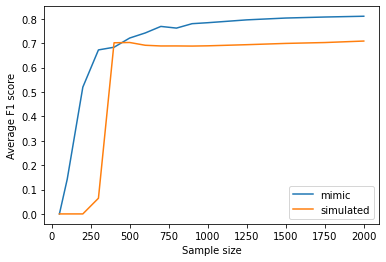

In [44]:
samples = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
sns.lineplot(x = samples, y = overall_f1_list_log_mimic)
sns.lineplot(x = samples, y = overall_f1_list_log_sim)
plt.xlabel("Sample size")
plt.ylabel("Average F1 score")
plt.legend(["mimic", "simulated"])

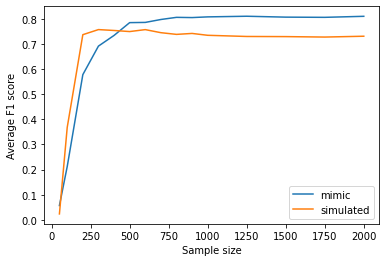

In [45]:
samples = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
sns.lineplot(x = samples, y = overall_f1_list_rf_mimic)
sns.lineplot(x = samples, y = overall_f1_list_rf_sim)
plt.xlabel("Sample size")
plt.ylabel("Average F1 score")
plt.legend(["mimic", "simulated"])

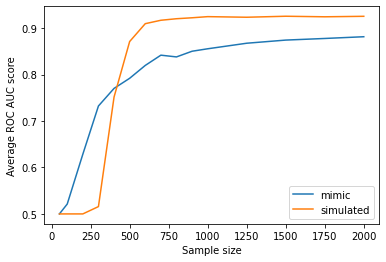

In [46]:
samples = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
sns.lineplot(x = samples, y = overall_roc_auc_list_log_mimic)
sns.lineplot(x = samples, y = overall_roc_auc_list_log_sim)
plt.xlabel("Sample size")
plt.ylabel("Average ROC AUC score")
plt.legend(["mimic", "simulated"])


(0.5, 1.0)

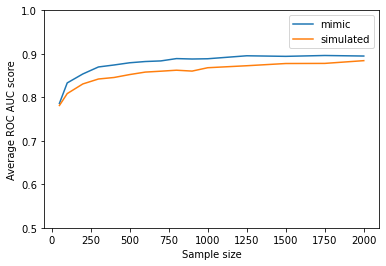

In [47]:
samples = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
sns.lineplot(x = samples, y = overall_roc_auc_list_rf_mimic)
sns.lineplot(x = samples, y = overall_roc_auc_list_rf_sim)
plt.xlabel("Sample size")
plt.ylabel("Average ROC AUC score")
plt.legend(["mimic", "simulated"])
plt.ylim([0.5, 1])


# Sample size investigations

### Defining some functions

The following function takes the following parameters as arguments:
1. Sample size for texts to be simulated (sample_size)
2. Prevalence of outcome (prevalence)
3. Number of strong predictors in the vocabulary (n_strong)
4. Number of nondefinite predictors in the vocabulary (n_nondefinite)
5. Mean and standard deviation of document lengths in ARF cases (arf_wc_mean_sd)
6. Mean and standard deviation of document lengths in control documents (nonarf_wc_mean_sd)
7. Proportion of strong, nondefinite and noise predictors in control documents (p0)
8. Proportion of strong, nondefinite and nosie predictors in ARF cases (p1)
9. Whether models should be evaluated on an external dataset (external_test; 1 = yes, 0 = no)
10. Whether the external test set should be simulated (create_test_corpus; 1 = yes, 0 = no)
11. If the external test set is to be simulated, the test sample size (N_test_ext)
12. If the external test set is not to be simulated, an existing list of documents and outcomes (test_docslist_passed, test_outcome_passed)
13. How much information should be displayed in the output (verbose; 1 = detailed, 0 = minimal)

Once the required datasets are simulated, this function:
- Creates TF-IDF representations
- Fits elastic net and random forest models on these texts
- Evaluation (internal validation + validation on the external test dataset)
- Calculates metrics and saves this in a dataframe

In [5]:
# adapted from code by Diana Shamsutdinova

def one_run(sample_size = 14498, # overall sample size
            prevalence = 0.5, # prevalence of positive class
            n_strong = 20, # number of strong predictors
            n_nondefinite = 77, # number of nondefinite predictors
            arf_wc_mean_sd = (1229.539523, 603.608061), # mean, sd of word counts per document for positive class
            nonarf_wc_mean_sd = (977.096979, 490.480307), # mean, sd of word counts per document for negative class
            p0 = [0.01, 0.06, 0.92], # mean proportion of strong, nondefinite and noise predictors per document for negative class
            p1 = [0.02, 0.09, 0.89], # mean proportion of strong, nondefinite and noise predictors per document for positive class
            external_test = 0, # whether a separate test set should be used
            create_test_corpus = 1, # whether the test corpus should be created/simulated
            N_test_ext = 1000,
            test_docslist_passed=[], test_outcome_passed = [], #if 1, then we simulate test sample, if not, using those provided
            verbose =1):   #print results or not 
  
    # simulating training corpus
    (docslist01,outcome) = simulate_texts(sample_size, prevalence, n_strong, n_nondefinite, arf_wc_mean_sd, nonarf_wc_mean_sd, p0, p1)
    if (external_test ==1):
        # simulating test corpus if create_test_corpus == 1
        if (create_test_corpus ==1):
            (test_docslist01,test_outcome) = simulate_texts(N_test_ext, prevalence, n_strong, n_nondefinite, arf_wc_mean_sd, nonarf_wc_mean_sd, p0, p1)
            print("simulations complete")
        else:
            test_docslist01 = test_docslist_passed
            test_outcome = test_outcome_passed
            
        #vectorize everything to TFIDF
        vectorizer = TfidfVectorizer()
        tfidf_training_data_01 = vectorizer.fit_transform(docslist01)
        test_tfidf_training_data_01 = vectorizer.transform(test_docslist01)
    else:
        vectorizer = TfidfVectorizer()
        tfidf_training_data_01 = vectorizer.fit_transform(docslist01)

    # Cross-validate elastic net and random forest models
    scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro', 'roc_auc']
    
    rf = RandomForestClassifier(n_estimators=100, min_samples_split=0.05, random_state=42)
    scores_rf = cross_validate(rf, tfidf_training_data_01, outcome, scoring=scoring, cv=5, return_train_score=False)
    scoresdf_rf = pd.DataFrame(scores_rf)

    logreg = LogisticRegression(penalty = "elasticnet", solver = 'saga', max_iter = 500, random_state = 5, C = 0.5, l1_ratio = 0.5)
    scores_lg = cross_validate(logreg, tfidf_training_data_01, outcome, scoring=scoring, cv=5, return_train_score=False)
    scoresdf_lg = pd.DataFrame(scores_lg)
    
    #create results data frame with average test scores 
    res = pd.DataFrame([scoresdf_rf.mean(), scoresdf_lg.mean(),scoresdf_rf.std(), scoresdf_lg.std() ], 
                       index = ["RF", "LogitL1", "RF_std", "LogitL1_std"])
    X_train, X_test, y_train, y_test = train_test_split(tfidf_training_data_01, outcome, 
                                                        test_size=0.10, random_state=42)
    rf.fit(X_train, y_train)
    logreg.fit(X_train, y_train)   
    predicted_rf_test_bin = rf.predict(X_test)
    predicted_logit_test_bin = logreg.predict(X_test)
    
    # calculate confusion matrix and f1 score at Youden's index 
    predicted_rf_train = rf.predict_proba(X_train)[:,1]
    predicted_logit_train = logreg.predict_proba(X_train)[:,1]

    yp_rf_train = youden_point(y_train, predicted_rf_train)
    yp_logit_train = youden_point(y_train, predicted_logit_train)
    predicted_rf_test_ =    rf.predict_proba(X_test)[:,1]
    predicted_logit_test_ = logreg.predict_proba(X_test)[:,1]
    
    predicted_youden_rf_test_  = [1 if predicted_rf_test_[i]> yp_rf_train else 0 for i in range(len(predicted_rf_test_))]
    predicted_youden_logit_test_ = [1 if predicted_logit_test_[i]> yp_logit_train else 0 for i in range(len(predicted_logit_test_))]
    
    # add F1, precision, recall to results data frame
    res["F1_At_Youden_InternalVal"] = [f1_score(y_test, predicted_youden_rf_test_ ),
                                    f1_score(y_test, predicted_youden_logit_test_),0,0]
    res["Precision_At_Youden_InternalVal"] = [precision_score(y_test, predicted_youden_rf_test_ ),
                                    precision_score(y_test, predicted_youden_logit_test_),0,0]
    res["Recall_At_Youden_InternalVal"] = [recall_score(y_test, predicted_youden_rf_test_ ),
                                    recall_score(y_test, predicted_youden_logit_test_),0,0]
    res["F1_InternalVal"] = [f1_score(y_test, predicted_rf_test_bin ),
                             f1_score(y_test, predicted_logit_test_bin),0,0]
    
    if (verbose ==1):
        print("RF_apparent\n", confusion_matrix(outcome,rf.predict(tfidf_training_data_01)))
        print("Logit_apparent\n", confusion_matrix(outcome,logreg.predict(tfidf_training_data_01)))
        print("RF_apparent_YoudenCM\n", confusion_matrix(y_test, predicted_youden_rf_test_ ))
        print("Logit_apparent_YoudenCM\n", confusion_matrix(y_test, predicted_youden_logit_test_))
        print("RF_apparent_F1\n", f1_score(y_test, predicted_youden_rf_test_ ))
        print("Logit_apparent_F1\n", f1_score(y_test, predicted_youden_logit_test_))
        print("RF_ROCAUC_apparent",roc_auc_score(outcome, rf.predict_proba(tfidf_training_data_01)[:,1]))
        print("Logit_ROCAUC_apparent",roc_auc_score(outcome, logreg.predict_proba(tfidf_training_data_01)[:,1]))
        print("Youden cut-off Logit", yp_logit_train, "Youden cut-off RF", yp_rf_train)

    if (external_test ==1):
        
        rf = RandomForestClassifier(n_estimators=100, min_samples_split=0.05, random_state=42)
        logreg = LogisticRegression(penalty = "elasticnet", solver = 'saga', max_iter = 500, random_state = 5, C = 0.5, l1_ratio = 0.5)
        
        # re-fitting model to entire training set, as previously, the model was not fit on the combined training-validation sets
        rf.fit(tfidf_training_data_01, outcome)
        logreg.fit(tfidf_training_data_01, outcome)
        
        # generating predictions
        predicted_rf = rf.predict_proba(test_tfidf_training_data_01)[:,1]
        predicted_logit = logreg.predict_proba(test_tfidf_training_data_01)[:,1]
        predicted_rf_train = rf.predict_proba(tfidf_training_data_01)[:,1]
        predicted_logit_train = logreg.predict_proba(tfidf_training_data_01)[:,1]
        print("RF_ROCAUC_Large_Test",roc_auc_score(test_outcome, predicted_rf))
        print("Logit_ROCAUC_Large_Test",roc_auc_score(test_outcome, predicted_logit))
        
        
        # Youden's index using entire training dataset
        yp_rf_train = youden_point(outcome, predicted_rf_train)
        yp_logit_train = youden_point(outcome, predicted_logit_train)

        yp_rf = youden_point(test_outcome, predicted_rf)
        yp_logit = youden_point(test_outcome, predicted_logit)
        
        predicted_youden_rf = [1 if predicted_rf[i]> yp_rf else 0 for i in range(len(predicted_rf))]
        predicted_youden_logit = [1 if predicted_logit[i]> yp_logit else 0 for i in range(len(predicted_logit))]

        predicted_youdenTrain_rf = [1 if predicted_rf[i]> yp_rf_train else 0 for i in range(len(predicted_rf))]
        predicted_youdenTrain_logit = [1 if predicted_logit[i]> yp_logit_train else 0 for i in range(len(predicted_logit))]
        
        # add F1, ROC AUC to results data frame
        res["Youden_Cutoff_Train"] = [yp_rf_train,yp_logit_train,0,0]
        res["*ROCAUC_LargeTest"] = [roc_auc_score(test_outcome, predicted_rf),
                                    roc_auc_score(test_outcome, predicted_logit),0,0]
        res["Youden_Cutoff_Test"] = [yp_rf,yp_logit,0,0]
        res["F1_At_RecalibYouden_Test"] = [ f1_score(test_outcome, predicted_youden_rf ),
                                        f1_score(test_outcome, predicted_youden_logit),0,0]
        [f1mean, f1low, f1high, f1std] = f1_conf_int(test_outcome, predicted_youdenTrain_rf)
        [f1mean_l, f1low_l, f1high_l, f1std_l] = f1_conf_int(test_outcome, predicted_youdenTrain_logit)
        
        res["*F1_At_TrainYouden_Test"] = [f1_score(test_outcome, predicted_youdenTrain_rf ),
                                        f1_score(test_outcome, predicted_youdenTrain_logit), f1std, f1std_l]
        res["*Precision_At_TrainYouden_Test"] = [precision_score(test_outcome, predicted_youdenTrain_rf ),
                                        precision_score(test_outcome, predicted_youdenTrain_logit), 0, 0]
        res["*Recall_At_TrainYouden_Test"] = [recall_score(test_outcome, predicted_youdenTrain_rf ),
                                        recall_score(test_outcome, predicted_youdenTrain_logit), 0, 0]
        
        print("F1 lasso", f1_score(test_outcome, predicted_youdenTrain_logit))
        print("F1 RF", f1_score(test_outcome, predicted_youdenTrain_rf ))
            
        if (verbose==1):
            print ("Test_at Youden from training dataset")
            print ("RF YP train", yp_rf_train, "Logit YP train", yp_logit_train)
            print("RF_Large_test_YoudenTrain\n", confusion_matrix(test_outcome, predicted_youdenTrain_rf))
            print("Logit_Large_test_YoudenTrain\n", confusion_matrix(test_outcome,predicted_youdenTrain_logit) )
            print("RF_apparent_F1_YoudenTrain\n", f1_score(test_outcome, predicted_youdenTrain_rf ))
            print("Logit_apparent_F1_YoudenTrain\n", f1_score(test_outcome, predicted_youdenTrain_logit))

    return(res)

Function to calculate confidence intervals for the F1 score (by Diana Shamsutdinova)

In [6]:
def f1_conf_int(target, predict, bootstrap_n = 100):
    n = len(target)
    f1 = np.zeros(bootstrap_n) # creating an array, of size defined by bootstrap_n argument
    for bs in np.arange(bootstrap_n): # values from interval 0 (inclusive) to the number specified by bootstrap_n (exclusive)
        i = np.random.choice(n, n, replace = True) # for each value in bootstrap_n (0-99 using default bootstrap_n value), generates a random sample of size n from n using sampling with replacement
        tp = pd.DataFrame({"t": target, "p": predict}) # then create a dataframe with two columns t and p with corresponding values from target and predict respectively.. but what are target and predict??
        tp_bootstrap = tp.iloc[i, :] # in a separate dataframe, save the ith row and all columns (t and p) from the tp df
        f1[bs] = (f1_score(tp_bootstrap["t"], tp_bootstrap["p"]))# replace the "bs"th index of the f1 array with the f1_score of the t and p values from the tp_bootstrap df
    res = [f1.mean(), np.quantile(f1,0.06), np.quantile(f1,0.94), f1.std()] # return summary statistics relating to the f1 score
    return res

Function to calculate mean and standard deviations across the 20 repetitions of each sample size variation (by Diana Shamsutdinova)

In [7]:
def get_mean_std(res_obj):
    n = len(res_obj)
    namesres = list(res_obj.keys())
    res_mean = res_obj[namesres[0]]/n
    for i in np.arange(1,n):
        res_mean += res_obj[namesres[i]]/n
    
    res_std = (res_obj[namesres[0]] - res_mean)**2
    for i in np.arange(1,n):
        res_std += (res_obj[namesres[i]] - res_mean)**2
    res_std = (res_std/n)**0.5

    return (res_mean, res_std)

## 1. Specific vocabulary, general documents (default parameters)

### Prevalence 0.5

Simulating test dataset

In [9]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.5)

Class 0: 10000 Class 1: 10000


Sample size analysis

In [22]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

# creating empty dictionary to store the results
res_list = {}
res_list_std = {}

# running the analyes in a loop across all sample sizes
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.5, 
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.84390377
Logit_ROCAUC_Large_Test 0.731475485
F1 lasso 0.7049434371610104
F1 RF 0.7438670966161883
Simulation 7
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8434331899999999
Logit_ROCAUC_Large_Test 0.7215525300000001
F1 lasso 0.703502590673575
F1 RF 0.7476163311873523
Simulation 8
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8478943000000001
Logit_ROCAUC_Large_Test 0.62266854
F1 lasso 0.6428023292556312
F1 RF 0.7501861196128712
Simulation 9
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8447949000000001
Logit_ROCAUC_Large_Test 0.7170683400000001
F1 lasso 0.7098428722624766
F1 RF 0.730676567005016
Simulation 10
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.84503938
Logit_ROCAUC_Large_Test 0.72564072
F1 lasso 0.6956268464195066
F1 RF 0.7677733752334107
Simulation 11
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8435255199999999
Logit_ROCAUC_Large_Test 0.725434515
F1 lasso 0.7026210500530743
F1 RF 0.7656070294888899
Simulation 12
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8401354400000001
Logit_ROCAUC_Large_Test 0.763801105
F1 lasso 0.7066128294987047
F1 RF 0.7663898297220806
Simulation 13
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.84383755
Logit_ROCAUC_Large_Test 0.7093311
F1 lasso 0.6865945643931836
F1 RF 0.7348877716638297
Simulation 14
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.84709897
Logit_ROCAUC_Large_Test 0.65547884
F1 lasso 0.6418409624120202
F1 RF 0.7544642857142858
Simulation 15
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.84352102
Logit_ROCAUC_Large_Test 0.80864202
F1 lasso 0.7018561484918793
F1 RF 0.735965404020181
Simulation 16
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.83893482
Logit_ROCAUC_Large_Test 0.6879171100000001
F1 lasso 0.6865057380292837
F1 RF 0.7523448928663627
Simulation 17
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8391621300000001
Logit_ROCAUC_Large_Test 0.760609795
F1 lasso 0.7050416208575468
F1 RF 0.7621161337077633
Simulation 18
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.83392631
Logit_ROCAUC_Large_Test 0.7794828699999999
F1 lasso 0.6984707690056341
F1 RF 0.7506746757203795
Simulation 19
Class 0: 200 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.84788188
Logit_ROCAUC_Large_Test 0.733902635
F1 lasso 0.7037800071658904
F1 RF 0.7543585630461395
Computing for train size 500
Simulation 0
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.8557554599999999
Logit_ROCAUC_Large_Test 0.84084002
F1 lasso 0.719946121899203
F1 RF 0.7191928352794467
Simulation 1
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarnin

RF_ROCAUC_Large_Test 0.8492848499999999
Logit_ROCAUC_Large_Test 0.83671847
F1 lasso 0.7038778758500941
F1 RF 0.747806746571111
Simulation 2
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.8484494899999999
Logit_ROCAUC_Large_Test 0.8665705
F1 lasso 0.7046186895810957
F1 RF 0.7431693989071039
Simulation 3
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.84061584
Logit_ROCAUC_Large_Test 0.89259604
F1 lasso 0.6859606760952052
F1 RF 0.7552592849103974
Simulation 4
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.85652218
Logit_ROCAUC_Large_Test 0.8779434749999999
F1 lasso 0.7053206002728514
F1 RF 0.7433278152380183
Simulation 5
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.84263819
Logit_ROCAUC_Large_Test 0.88487515
F1 lasso 0.6910259545184616
F1 RF 0.755304838359731
Simulation 6
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.85518922
Logit_ROCAUC_Large_Test 0.8619765699999999
F1 lasso 0.7152949879785464
F1 RF 0.7511100148001975
Simulation 7
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.8495893200000001
Logit_ROCAUC_Large_Test 0.8612652599999999
F1 lasso 0.6923319659198486
F1 RF 0.7680721533258175
Simulation 8
Class 0: 250 Class 1: 250
RF_ROCAU

C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.8517641899999999
Logit_ROCAUC_Large_Test 0.8496359
F1 lasso 0.6975114163333216
F1 RF 0.7446385859650546
Simulation 11
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.8457692
Logit_ROCAUC_Large_Test 0.8677051699999999
F1 lasso 0.6973712180259336
F1 RF 0.7588875037613377
Simulation 12
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.8489502
Logit_ROCAUC_Large_Test 0.8526834799999999
F1 lasso 0.7005379983610645
F1 RF 0.7400849290922201
Simulation 13
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.8613780800000002
Logit_ROCAUC_Large_Test 0.84297891
F1 lasso 0.7084151574659976
F1 RF 0.7355552094689302
Simulation 14
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.8446335500000001
Logit_ROCAUC_Large_Test 0.85807269
F1 lasso 0.7025668641177526
F1 RF 0.7673847832015273
Simulation 15
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.8464756600000001
Logit_ROCAUC_Large_Test 0.88187597
F1 lasso 0.696969696969697
F1 RF 0.7570383125269048
Simulation 16
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.8552353000000001
Logit_ROCAUC_Large_Test 0.8408868899999999
F1 lasso 0.6999677037356012
F1 RF 0.7306158789145666
Simulation 17
Class 0: 250 Class 1: 250
RF_ROCAUC_Large_Test 0.8507164600000001
Logit_ROCAUC_Large_Test 0.8839384299999999
F1 lasso 0.6932736367134212
F1 RF 0.7585355470412942
Simulation 18
Clas

C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.85112112
Logit_ROCAUC_Large_Test 0.8192044300000001
F1 lasso 0.7208723933422613
F1 RF 0.7607031350241649
Computing for train size 600
Simulation 0
Class 0: 300 Class 1: 300
RF_ROCAUC_Large_Test 0.8586915500000001
Logit_ROCAUC_Large_Test 0.89993226
F1 lasso 0.6876622252984945
F1 RF 0.7545835731316287
Simulation 1
Class 0: 300 Class 1: 300
RF_ROCAUC_Large_Test 0.8547083600000001
Logit_ROCAUC_Large_Test 0.91135875
F1 lasso 0.6842737919428511
F1 RF 0.7542467915437969
Simulation 2
Class 0: 300 Class 1: 300
RF_ROCAUC_Large_Test 0.8545304
Logit_ROCAUC_Large_Test 0.9062640900000001
F1 lasso 0.6833184656556646
F1 RF 0.7356239844647883
Simulation 3
Class 0: 300 Class 1: 300
RF_ROCAUC_Large_Test 0.85538397
Logit_ROCAUC_Large_Test 0.9127324299999999
F1 lasso 0.6826646583595783
F1 RF 0.7334086746424535
Simulation 4
Class 0: 300 Class 1: 300
RF_ROCAUC_Large_Test 0.8550376100000001
Logit_ROCAUC_Large_Test 0.9060652299999999
F1 lasso 0.6861022088976189
F1 RF 0.734160372558995
Si

Saving results

In [27]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/specific_condition_general_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [28]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/specific_condition_general_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.3

Simulating test dataset

In [29]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.3)

Class 0: 14000 Class 1: 6000


Sample size analysis

In [ ]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.3, 
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

Saving results

In [31]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/specific_condition_general_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [33]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/specific_condition_general_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.1

Simulating test dataset

In [38]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.1)

Class 0: 18000 Class 1: 2000


Sample size analysis

In [ ]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.1, 
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

Saving results

In [40]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/specific_condition_general_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [41]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/specific_condition_general_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.05

Simulating test dataset

In [46]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.05)

Class 0: 19000 Class 1: 1000


Sample size analysis

In [ ]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.05, 
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

Saving results

In [48]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/specific_condition_general_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [49]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/specific_condition_general_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.01

Simulating test dataset

In [50]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.01)

Class 0: 19800 Class 1: 200


Sample size analysis

In [ ]:
n_train_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train) 
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.01, 
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

Saving results

In [52]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/specific_condition_general_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [53]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/specific_condition_general_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

## 2. Specific vocabulary, specific documents

### Prevalence 0.5

Simulating test dataset

In [11]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.5,
                                             p0 = [0.005, 0.03, 0.965],
                                             p1 = [0.04, 0.18, 0.78])
 

Class 0: 10000 Class 1: 10000


Sample size analysis

In [12]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
 
res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train,
                                  external_test = 1,
                                  verbose = 0,
                                  prevalence = 0.5, 
                                  p0 = [0.005, 0.03, 0.965],
                                  p1 = [0.04, 0.18, 0.78],
                                  test_docslist_passed=test_docslist,
                                  test_outcome_passed = test_outcome,
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

RF_ROCAUC_Large_Test 0.9996244000000001
Logit_ROCAUC_Large_Test 0.9999720900000001
F1 lasso 0.9652476107732406
F1 RF 0.9944145222421703
Simulation 15
Class 0: 750 Class 1: 750
RF_ROCAUC_Large_Test 0.9995862
Logit_ROCAUC_Large_Test 0.99996638
F1 lasso 0.844558929099278
F1 RF 0.990122598898099
Simulation 16
Class 0: 750 Class 1: 750
RF_ROCAUC_Large_Test 0.9996567600000001
Logit_ROCAUC_Large_Test 0.99996784
F1 lasso 0.8374507997655137
F1 RF 0.9936248630341667
Simulation 17
Class 0: 750 Class 1: 750
RF_ROCAUC_Large_Test 0.9995240900000001
Logit_ROCAUC_Large_Test 0.9999692200000001
F1 lasso 0.9817860474250085
F1 RF 0.9906124273580689
Simulation 18
Class 0: 750 Class 1: 750
RF_ROCAUC_Large_Test 0.99958477
Logit_ROCAUC_Large_Test 0.99996362
F1 lasso 0.8609436886516273
F1 RF 0.9891439052198483
Simulation 19
Class 0: 750 Class 1: 750
RF_ROCAUC_Large_Test 0.99962545
Logit_ROCAUC_Large_Test 0.9999707
F1 lasso 0.8767699793959055
F1 RF 0.995303287698611
Computing for train size 1750
Simulation 0
Cl

Saving results

In [13]:
for i in res_list:
    filepath = str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)

In [14]:
for i in res_list_std:
    filepath = str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)

### Prevalence 0.3

Simulating test dataset

In [15]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.3,
                                             p0 = [0.005, 0.03, 0.965],
                                             p1 = [0.04, 0.18, 0.78])
 

Class 0: 14000 Class 1: 6000


Sample size analysis

In [16]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
 
res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train,
                                  external_test = 1,
                                  verbose = 0,
                                  prevalence = 0.3, 
                                  p0 = [0.005, 0.03, 0.965],
                                  p1 = [0.04, 0.18, 0.78],
                                  test_docslist_passed=test_docslist,
                                  test_outcome_passed = test_outcome,
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

F1 lasso 0.6822501926534806
F1 RF 0.9547948784949046
Simulation 17
Class 0: 70 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9980759761904763
Logit_ROCAUC_Large_Test 0.9144091249999999
F1 lasso 0.6593785960874569
F1 RF 0.9595977111149644
Simulation 18
Class 0: 70 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.997055
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.964106988783434
Simulation 19
Class 0: 70 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9976004821428572
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9203778677462888
Computing for train size 200
Simulation 0
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9987871904761904
Logit_ROCAUC_Large_Test 0.9999941904761905
F1 lasso 0.9364757296706727
F1 RF 0.97409592203129
Simulation 1
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984513571428572
Logit_ROCAUC_Large_Test 0.9999921904761905
F1 lasso 0.537562155624244
F1 RF 0.9842746026378086
Simulation 2
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.998217244047619
Logit_ROCAUC_Large_Test 0.9999933095238096
F1 lasso 0.9459246413369069
F1 RF 0.9776907356948229
Simulation 3
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984305952380952
Logit_ROCAUC_Large_Test 0.9999930357142858
F1 lasso 0.9405862987929143
F1 RF 0.9821292453629203
Simulation 4
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9982140952380952
Logit_ROCAUC_Large_Test 0.9999871547619048
F1 lasso 0.8795074758135444
F1 RF 0.9821473897960911
Simulation 5
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9982167083333334
Logit_ROCAUC_Large_Test 0.999990511904762
F1 lasso 0.7696748123917644
F1 RF 0.98558256496228
Simulation 6
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9982544761904762
Logit_ROCAUC_Large_Test 0.9999880476190476
F1 lasso 0.8045052292839903
F1 RF 0.9724315068493151
Simulation 7
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984296071428572
Logit_ROCAUC_Large_Test 0.9999961190476191
F1 lasso 0.736422215403498
F1 RF 0.9731302413143933
Simulation 8
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984942142857143
Logit_ROCAUC_Large_Test 0.9999956428571428
F1 lasso 0.9230059226213367
F1 RF 0.9820399864452727
Simulation 9
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9987479999999999
Logit_ROCAUC_Large_Test 0.9999822738095239
F1 lasso 0.8610792192881745
F1 RF 0.9842719431760527
Simulation 10
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9983660357142856
Logit_ROCAUC_Large_Test 0.9999884761904761
F1 lasso 0.7586294095334429
F1 RF 0.9838341091832417
Simulation 11
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9985551666666667
Logit_ROCAUC_Large_Test 0.9999887023809524
F1 lasso 0.8755928493250639
F1 RF 0.9722745165154886
Simulation 12
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.998478630952381
Logit_ROCAUC_Large_Test 0.999991
F1 lasso 0.8572653236176597
F1 RF 0.9797859690844233
Simulation 13
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9986673809523808
Logit_ROCAUC_Large_Test 0.9999909880952381
F1 lasso 0.9390406135065342
F1 RF 0.9693377995362019
Simulation 14
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984873095238096
Logit_ROCAUC_Large_Test 0.999986880952381
F1 lasso 0.7563342997604942
F1 RF 0.9704091259970837
Simulation 15
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9980187857142857
Logit_ROCAUC_Large_Test 0.9999794523809524
F1 lasso 0.708215297450425
F1 RF 0.9780621572212066
Simulation 16
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9981807976190475
Logit_ROCAUC_Large_Test 0.9999924285714286
F1 lasso 0.9081277433025579
F1 RF 0.9804121088781481
Simulation 17
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984999761904763
Logit_ROCAUC_Large_Test 0.99996275
F1 lasso 0.8333333333333333
F1 RF 0.9849636762966717
Simulation 18
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9983826547619048
Logit_ROCAUC_Large_Test 0.9999828809523809
F1 lasso 0.8653014133256418
F1 RF 0.985782787919576
Simulation 19
Class 0: 140 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984560357142858
Logit_ROCAUC_Large_Test 0.9999966904761904
F1 lasso 0.9471191791633781
F1 RF 0.9842100819049227
Computing for train size 300
Simulation 0
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9983943214285714
Logit_ROCAUC_Large_Test 0.9999982380952381
F1 lasso 0.6365372374283895
F1 RF 0.980466810130773
Simulation 1
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9990389523809523
Logit_ROCAUC_Large_Test 0.9999964166666666
F1 lasso 0.9100561201274079
F1 RF 0.9883104869228828
Simulation 2
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9987655
Logit_ROCAUC_Large_Test 0.9999982738095239
F1 lasso 0.8378133072680304
F1 RF 0.9853893408600366
Simulation 3
Class 0: 210 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9987189761904762
Logit_ROCAUC_Large_Test 0.9999966666666666
F1 lasso 0.8249123530624871
F1 RF 0.9817340276055873
Simulation 4
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9990184166666666
Logit_ROCAUC_Large_Test 0.9999965476190477
F1 lasso 0.7097232079488999
F1 RF 0.9880743891251772
Simulation 5
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9989846666666667
Logit_ROCAUC_Large_Test 0.9999961785714285
F1 lasso 0.7903055848261327
F1 RF 0.9873837981407703
Simulation 6
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9987995833333333
Logit_ROCAUC_Large_Test 0.9999981904761905
F1 lasso 0.600480384307446
F1 RF 0.9854590776900707
Simulation 7
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9988308690476191
Logit_ROCAUC_Large_Test 0.9999981666666666
F1 lasso 0.8844339622641509
F1 RF 0.98701955495617
Simulation 8
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9981562023809524
Logit_ROCAUC_Large_Test 0.9999972261904762
F1 lasso 0.584225900681597
F1 RF 0.986172798122852

/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9987030476190476
Logit_ROCAUC_Large_Test 0.9999948452380951
F1 lasso 0.7597340930674263
F1 RF 0.9846127832262428
Simulation 13
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9986890595238095
Logit_ROCAUC_Large_Test 0.9999986547619047
F1 lasso 0.7570977917981073
F1 RF 0.9871581054036024
Simulation 14
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9988862738095239
Logit_ROCAUC_Large_Test 0.9999986071428572
F1 lasso 0.70859167404783
F1 RF 0.9898753242406494
Simulation 15
Class 0: 210 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9989837023809524
Logit_ROCAUC_Large_Test 0.9999968214285715
F1 lasso 0.6002701215546996
F1 RF 0.9809892189943215
Simulation 16
Class 0: 210 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9988707261904761
Logit_ROCAUC_Large_Test 0.9999979761904761
F1 lasso 0.7680491551459293
F1 RF 0.9876189674050366
Simulation 17
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9991282142857142
Logit_ROCAUC_Large_Test 0.9999982976190476
F1 lasso 0.7793219898688142
F1 RF 0.9889687447768678
Simulation 18
Class 0: 210 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9986982380952381
Logit_ROCAUC_Large_Test 0.9999987976190476
F1 lasso 0.6737031214911297
F1 RF 0.9769237086310257
Simulation 19
Class 0: 210 Class 1: 90
RF_ROCAUC_Large_Test 0.9986686785714287
Logit_ROCAUC_Large_Test 0.9999980119047619
F1 lasso 0.8043973723019171
F1 RF 0.9858002004677582
Computing for train size 400
Simulation 0
Class 0: 280 Class 1: 120
RF_ROCAUC_Large_Test 0.9990538690476191
Logit_ROCAUC_Large_Test 0.9999972500000001
F1 lasso 0.8324084350721421
F1 RF 0.9869633812173048
Simulation 1
Class 0: 280 Class 1: 120
RF_ROCAUC_Large_Test 0.9992997261904761
Logit_ROCAUC_Large_Test 0.9999995
F1 lasso 0.8170490910328863
F1 RF 0.9916624979156246
Simulation 2
Class 0: 280 Class 1: 120
RF_ROCAUC_Large_Test 0.9992061785714286
Logit_ROCAUC_Large_Test 0.9999988928571428
F1 lasso 0.5884949242312785
F1 RF 0.9888648828319762
Simulation 3
Class 0: 280 Class 1: 120
RF_ROCAUC_Large_Test 0.9991491190476192
Logit_ROCAUC_Large_Test 0.9999981904761905
F1 lasso 0.76079376149

Saving results

In [17]:
for i in res_list:
    filepath = str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)

In [18]:
for i in res_list_std:
    filepath = str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)

### Prevalence 0.1

Simulating test dataset

In [19]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.1,
                                             p0 = [0.005, 0.03, 0.965],
                                             p1 = [0.04, 0.18, 0.78])
 

Class 0: 18000 Class 1: 2000


Sample size analysis

In [20]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
 
res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train,
                                  external_test = 1,
                                  verbose = 0,
                                  prevalence = 0.3, 
                                  p0 = [0.005, 0.03, 0.965],
                                  p1 = [0.04, 0.18, 0.78],
                                  test_docslist_passed=test_docslist,
                                  test_outcome_passed = test_outcome,
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7109249113760877
Simulation 1
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9965314027777779
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6111111111111112
Simulation 2
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9967836666666667
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6120749479528105
Simulation 3
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9962963472222223
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4555984555984556
Simulation 4
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9964734027777777
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7257088244663905
Simulation 5
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9968095138888889
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6737400530503979
Simulation 6
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9965885277777778
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.664440734557596
Simulation 7
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9968865277777778
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6440677966101694
Simulation 8
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9969781944444445
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5422740524781342
Simulation 9
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9964700833333333
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.711340206185567
Simulation 10
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9960348472222222
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.555435175153485
Simulation 11
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9967465416666667
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.3746444534741975
Simulation 12
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.996058625
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.34847233691164325
Simulation 13
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9968033472222222
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.393574297188755
Simulation 14
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9975922500000001
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4544049459041731
Simulation 15
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9960480972222222
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5470395931710861
Simulation 16
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9967912222222222
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7445072190834903
Simulation 17
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9970985138888888
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4703632887189292
Simulation 18
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9975372499999999
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6671109630123292
Simulation 19
Class 0: 90 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9969743750000001
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5533453887884268
Computing for train size 200
Simulation 0
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9974938055555556
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9273263609546796
Simulation 1
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9982864444444445
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9434759640781828
Simulation 2
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9978000833333334
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9168697535878689
Simulation 3
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9976681666666667
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9618479107189204
Simulation 4
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9977880555555556
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9227040129275519
Simulation 5
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.99766675
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9434759640781828
Simulation 6
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9975905833333333
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9316239316239316
Simulation 7
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9974454444444445
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9626556016597512
Simulation 8
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9974673472222222
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9607690309171213
Simulation 9
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9973744722222222
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9586045300702941
Simulation 10
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9972632777777778
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9596879063719116
Simulation 11
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9976575555555557
Logit_ROCAUC_Large_Test 0.8279251666666668
F1 lasso 0.37589421200953826
F1 RF 0.8690981057393271
Simulation 12
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9979894444444444
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9852941176470588
Simulation 13
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9973125277777778
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9501312335958005
Simulation 14
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9974546666666666
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9682744389992263
Simulation 15
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9975103611111111
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9607690309171213
Simulation 16
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9973017222222222
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9782886334610472
Simulation 17
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9981731111111112
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9361702127659575
Simulation 18
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9973437222222222
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.8652482269503545
Simulation 19
Class 0: 180 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9978302222222223
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9457037427517132
Computing for train size 300
Simulation 0
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984890000000001
Logit_ROCAUC_Large_Test 0.9993394444444444
F1 lasso 0.9540669856459331
F1 RF 0.9583333333333334
Simulation 1
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9983629166666667
Logit_ROCAUC_Large_Test 0.9970017222222223
F1 lasso 0.26094902421512955
F1 RF 0.9824472144492495
Simulation 2
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9985578611111112
Logit_ROCAUC_Large_Test 0.9982588888888888
F1 lasso 0.5509809339596574
F1 RF 0.988621997471555
Simulation 3
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984564166666666
Logit_ROCAUC_Large_Test 0.9994524166666667
F1 lasso 0.4174149091668407
F1 RF 0.983997967995936
Simulation 4
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9982033333333333
Logit_ROCAUC_Large_Test 0.9991411388888889
F1 lasso 0.49775784753363234
F1 RF 0.9795918367346939
Simulation 5
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9975663888888889
Logit_ROCAUC_Large_Test 0.9990525000000001
F1 lasso 0.9381491973559962
F1 RF 0.9803721641600815
Simulation 6
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9977676111111111
Logit_ROCAUC_Large_Test 0.998413388888889
F1 lasso 0.962245885769603
F1 RF 0.9669421487603307
Simulation 7
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9979814444444445
Logit_ROCAUC_Large_Test 0.9991095277777778
F1 lasso 0.5088501209728766
F1 RF 0.9730423620025674
Simulation 8
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9985694999999999
Logit_ROCAUC_Large_Test 0.9902856388888889
F1 lasso 0.45247321632094833
F1 RF 0.9883720930232558
Simulation 9
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984006666666667
Logit_ROCAUC_Large_Test 0.9995977777777778
F1 lasso 0.5203019260801666
F1 RF 0.9875980764363452
Simulation 10
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984284722222223
Logit_ROCAUC_Large_Test 0.9992951666666666
F1 lasso 0.8780918727915195
F1 RF 0.9814107461166285
Simulation 11
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9982977777777777
Logit_ROCAUC_Large_Test 0.9996530833333334
F1 lasso 0.9472182596291013
F1 RF 0.9801121876593575
Simulation 12
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9983282777777779
Logit_ROCAUC_Large_Test 0.9991829722222223
F1 lasso 0.5352452425623158
F1 RF 0.9751473225723802
Simulation 13
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9986071666666667
Logit_ROCAUC_Large_Test 0.9976890277777778
F1 lasso 0.4150982634917334
F1 RF 0.9832231825114387
Simulation 14
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9979205000000001
Logit_ROCAUC_Large_Test 0.9990157222222222
F1 lasso 0.6571099027846433
F1 RF 0.985044359949303
Simulation 15
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9977936944444443
Logit_ROCAUC_Large_Test 0.9989675277777779
F1 lasso 0.7313049853372434
F1 RF 0.9832231825114387
Simulation 16
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9983439444444444
Logit_ROCAUC_Large_Test 0.9993350555555555
F1 lasso 0.7158234660925726
F1 RF 0.9764585465711361
Simulation 17
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9984131666666667
Logit_ROCAUC_Large_Test 0.9998280833333334
F1 lasso 0.9907753677387185
F1 RF 0.983739837398374
Simulation 18
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9982020555555556
Logit_ROCAUC_Large_Test 0.998827138888889
F1 lasso 0.43463128127039374
F1 RF 0.9888944977284201
Simulation 19
Class 0: 270 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9983844999999999
Logit_ROCAUC_Large_Test 0.9995566666666666
F1 lasso 0.8795765328628142
F1 RF 0.9790709545686574
Computing for train size 400
Simulation 0
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992408333333334
Logit_ROCAUC_Large_Test 0.9999264166666667
F1 lasso 0.9729598051157125
F1 RF 0.9837563451776651
Simulation 1
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9986367777777777
Logit_ROCAUC_Large_Test 0.9997454166666666
F1 lasso 0.9670702179176757
F1 RF 0.9906683480453972
Simulation 2
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9985440833333333
Logit_ROCAUC_Large_Test 0.9998328888888888
F1 lasso 0.9042336427439438
F1 RF 0.9904185577407967
Simulation 3
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.998834138888889
Logit_ROCAUC_Large_Test 0.9997806666666668
F1 lasso 0.4628558204119417
F1 RF 0.9929577464788732
Simulation 4
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991369999999999
Logit_ROCAUC_Large_Test 0.9999299722222221
F1 lasso 0.21878247552371058
F1 RF 0.9870853380602685
Simulation 5
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991188333333333
Logit_ROCAUC_Large_Test 0.9999295555555556
F1 lasso 0.227040526734022
F1 RF 0.9904137235116045
Simulation 6
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990552777777778
Logit_ROCAUC_Large_Test 0.9998531666666667
F1 lasso 0.4223418857565199
F1 RF 0.9875807252856432
Simulation 7
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991271388888889
Logit_ROCAUC_Large_Test 0.99993275
F1 lasso 0.9686817188638018
F1 RF 0.9795918367346939
Simulation 8
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989872222222222
Logit_ROCAUC_Large_Test 0.9995772777777778
F1 lasso 0.942203349846662
F1 RF 0.9944779116465864
Simulation 9
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9987035
Logit_ROCAUC_Large_Test 0.9998782500000001
F1 lasso 0.9854285008644109
F1 RF 0.9937170143252074
Simulation 10
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9986970000000001
Logit_ROCAUC_Large_Test 0.9999127777777778
F1 lasso 0.8933601609657947
F1 RF 0.9896543022962402
Simulation 11
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990914722222223
Logit_ROCAUC_Large_Test 0.9998141944444445
F1 lasso 0.43351035005960764
F1 RF 0.9899142713061019
Simulation 12
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988036111111112
Logit_ROCAUC_Large_Test 0.9998436111111111
F1 lasso 0.575251798561151
F1 RF 0.9929612870789342
Simulation 13
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.99895825
Logit_ROCAUC_Large_Test 0.9997802777777778
F1 lasso 0.8770851624231782
F1 RF 0.9947249434815373
Simulation 14
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988081944444445
Logit_ROCAUC_Large_Test 0.9998390277777778
F1 lasso 0.4352083560004352
F1 RF 0.9929506545820745
Simulation 15
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988193611111111
Logit_ROCAUC_Large_Test 0.9999088611111111
F1 lasso 0.5377066810055114
F1 RF 0.9927190559879487
Simulation 16
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988350277777778
Logit_ROCAUC_Large_Test 0.9995675833333334
F1 lasso 0.5263296471827278
F1 RF 0.9924471299093656
Simulation 17
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989677777777777
Logit_ROCAUC_Large_Test 0.9999398055555555
F1 lasso 0.9617328519855596
F1 RF 0.9937138546643198
Simulation 18
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988096944444445
Logit_ROCAUC_Large_Test 0.9996151666666667
F1 lasso 0.9786921381337252
F1 RF 0.9916981132075471
Simulation 19
Class 0: 360 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9987281944444444
Logit_ROCAUC_Large_Test 0.9997623055555556
F1 lasso 0.9801129388657009
F1 RF 0.9858084135833757
Computing for train size 500
Simulation 0
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988972500000002
Logit_ROCAUC_Large_Test 0.9999098888888889
F1 lasso 0.4117768169652049
F1 RF 0.991172761664565
Simulation 1
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988714444444443
Logit_ROCAUC_Large_Test 0.9998729444444444
F1 lasso 0.985679012345679
F1 RF 0.9926970536388819
Simulation 2
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989012777777778
Logit_ROCAUC_Large_Test 0.9999395
F1 lasso 0.5484711367064309
F1 RF 0.9906683480453972
Simulation 3
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989414166666668
Logit_ROCAUC_Large_Test 0.9999351944444445
F1 lasso 0.6625807520291535
F1 RF 0.9910134797803296
Simulation 4
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988748055555555
Logit_ROCAUC_Large_Test 0.9999488611111111
F1 lasso 0.870455040278685
F1 RF 0.9934738955823292
Simulation 5
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990740833333334
Logit_ROCAUC_Large_Test 0.9999705555555556
F1 lasso 0.8754650908295032
F1 RF 0.9929506545820745
Simulation 6
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9987805833333334
Logit_ROCAUC_Large_Test 0.9999551666666667
F1 lasso 0.8364016736401674
F1 RF 0.9921934021657013
Simulation 7
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991187222222223
Logit_ROCAUC_Large_Test 0.9999880277777777
F1 lasso 0.875848478213269
F1 RF 0.9907384230287861
Simulation 8
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990640555555556
Logit_ROCAUC_Large_Test 0.9998638333333334
F1 lasso 0.47359696897939846
F1 RF 0.9932109630374656
Simulation 9
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989362500000001
Logit_ROCAUC_Large_Test 0.9997571666666667
F1 lasso 0.8705882352941177
F1 RF 0.9904088844018173
Simulation 10
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.998927888888889
Logit_ROCAUC_Large_Test 0.9998200555555555
F1 lasso 0.8374528697109341
F1 RF 0.9896438494569336
Simulation 11
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.998905
Logit_ROCAUC_Large_Test 0.9998845555555556
F1 lasso 0.5848449385605617
F1 RF 0.9937138546643198
Simulation 12
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988839166666668
Logit_ROCAUC_Large_Test 0.9999021944444444
F1 lasso 0.5971620612397311
F1 RF 0.991504247876062
Simulation 13
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990253333333333
Logit_ROCAUC_Large_Test 0.9999673055555556
F1 lasso 0.9010592742844264
F1 RF 0.9939668174962293
Simulation 14
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988717777777777
Logit_ROCAUC_Large_Test 0.9998772499999999
F1 lasso 0.22913444463538982
F1 RF 0.9932143754712239
Simulation 15
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989591111111112
Logit_ROCAUC_Large_Test 0.9998673055555556
F1 lasso 0.8950078352361764
F1 RF 0.993963782696177
Simulation 16
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9987179166666666
Logit_ROCAUC_Large_Test 0.9999275277777777
F1 lasso 0.7198128486593487
F1 RF 0.9909182643794148
Simulation 17
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9987408888888889
Logit_ROCAUC_Large_Test 0.9997986388888889
F1 lasso 0.9512020947393479
F1 RF 0.9905142286570146
Simulation 18
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988639722222223
Logit_ROCAUC_Large_Test 0.9999744722222222
F1 lasso 0.3361062095622217
F1 RF 0.9926970536388819
Simulation 19
Class 0: 450 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.998910138888889
Logit_ROCAUC_Large_Test 0.9999198888888889
F1 lasso 0.2920347521355041
F1 RF 0.99347061778001
Computing for train size 600
Simulation 0
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989696666666666
Logit_ROCAUC_Large_Test 0.9999316111111112
F1 lasso 0.6036824630244492
F1 RF 0.9952369014790674
Simulation 1
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991906111111111
Logit_ROCAUC_Large_Test 0.9999701944444443
F1 lasso 0.5241090146750524
F1 RF 0.9911772119989917
Simulation 2
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990741111111111
Logit_ROCAUC_Large_Test 0.9999490833333333
F1 lasso 0.5600672080649678
F1 RF 0.9901589704769113
Simulation 3
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988889722222223
Logit_ROCAUC_Large_Test 0.9999665555555555
F1 lasso 0.6353240152477764
F1 RF 0.991681371313335
Simulation 4
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999038638888889
Logit_ROCAUC_Large_Test 0.9998726666666666
F1 lasso 0.587250293772033
F1 RF 0.9942254581973387
Simulation 5
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992385277777778
Logit_ROCAUC_Large_Test 0.9999400833333333
F1 lasso 0.5678591709256104
F1 RF 0.994228356336261
Simulation 6
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999103861111111
Logit_ROCAUC_Large_Test 0.9999485
F1 lasso 0.8296327038804732
F1 RF 0.9957361424630048
Simulation 7
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992498888888889
Logit_ROCAUC_Large_Test 0.9999406388888888
F1 lasso 0.7197119711971196
F1 RF 0.9952321204516938
Simulation 8
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991041111111111
Logit_ROCAUC_Large_Test 0.9999372777777779
F1 lasso 0.7522107243650047
F1 RF 0.9937170143252074
Simulation 9
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989806666666667
Logit_ROCAUC_Large_Test 0.9999469999999999
F1 lasso 0.9343304510399627
F1 RF 0.9947302383939775
Simulation 10
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.99903725
Logit_ROCAUC_Large_Test 0.9999832222222222
F1 lasso 0.8347245409015026
F1 RF 0.9904185577407967
Simulation 11
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990160555555554
Logit_ROCAUC_Large_Test 0.99992775
F1 lasso 0.7147962830593281
F1 RF 0.9914271306101865
Simulation 12
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989396388888887
Logit_ROCAUC_Large_Test 0.9999079166666667
F1 lasso 0.7684028445127812
F1 RF 0.986832298136646
Simulation 13
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990891111111112
Logit_ROCAUC_Large_Test 0.9999021944444444
F1 lasso 0.34656038814763473
F1 RF 0.9932516870782303
Simulation 14
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989822777777778
Logit_ROCAUC_Large_Test 0.9998566111111111
F1 lasso 0.9786921381337252
F1 RF 0.9937138546643198
Simulation 15
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990274444444445
Logit_ROCAUC_Large_Test 0.9999503333333333
F1 lasso 0.5825808330905914
F1 RF 0.9944806823883593
Simulation 16
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989948888888889
Logit_ROCAUC_Large_Test 0.9999893888888889
F1 lasso 0.7630675314765357
F1 RF 0.9934902353530296
Simulation 17
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991398888888889
Logit_ROCAUC_Large_Test 0.9999694722222221
F1 lasso 0.7701193685021178
F1 RF 0.9930034982508746
Simulation 18
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992464444444444
Logit_ROCAUC_Large_Test 0.999921
F1 lasso 0.9092563111212191
F1 RF 0.9937484371092773
Simulation 19
Class 0: 540 Class 1: 60


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989181111111112
Logit_ROCAUC_Large_Test 0.9999691944444444
F1 lasso 0.8944071588366891
F1 RF 0.9947249434815373
Computing for train size 700
Simulation 0
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991435833333333
Logit_ROCAUC_Large_Test 0.9999593055555556
F1 lasso 0.5389382915656157
F1 RF 0.993963782696177
Simulation 1
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992511944444443
Logit_ROCAUC_Large_Test 0.9999305
F1 lasso 0.9617512629299976
F1 RF 0.995229726336932
Simulation 2
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989885555555555
Logit_ROCAUC_Large_Test 0.9999663888888889
F1 lasso 0.8187589596559492
F1 RF 0.9954819277108434
Simulation 3
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990307222222222
Logit_ROCAUC_Large_Test 0.9999143888888888
F1 lasso 0.37411148522259635
F1 RF 0.9942167462911742
Simulation 4
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991926388888889
Logit_ROCAUC_Large_Test 0.999941
F1 lasso 0.908429902294933
F1 RF 0.994740796393689
Simulation 5
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992314166666667
Logit_ROCAUC_Large_Test 0.9998944444444445
F1 lasso 0.6999299719887955
F1 RF 0.972893772893773
Simulation 6
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990406111111111
Logit_ROCAUC_Large_Test 0.9999691388888889
F1 lasso 0.8511816052799661
F1 RF 0.9954841946813848
Simulation 7
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992069444444444
Logit_ROCAUC_Large_Test 0.9999413333333333
F1 lasso 0.5975500448162533
F1 RF 0.9947275922671354
Simulation 8
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992576944444445
Logit_ROCAUC_Large_Test 0.9999659722222223
F1 lasso 0.9803729146221786
F1 RF 0.9959839357429718
Simulation 9
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990740555555556
Logit_ROCAUC_Large_Test 0.9999621944444445
F1 lasso 0.6248047485160887
F1 RF 0.9949748743718593
Simulation 10
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991102500000001
Logit_ROCAUC_Large_Test 0.9999860555555555
F1 lasso 0.8541533205210335
F1 RF 0.9954887218045113
Simulation 11
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991225555555556
Logit_ROCAUC_Large_Test 0.9999169444444445
F1 lasso 0.5571030640668523
F1 RF 0.9947381608619394
Simulation 12
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989978611111112
Logit_ROCAUC_Large_Test 0.9999725555555555
F1 lasso 0.940677966101695
F1 RF 0.9924433249370278
Simulation 13
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989244722222222
Logit_ROCAUC_Large_Test 0.9999520833333334
F1 lasso 0.7923107411811336
F1 RF 0.9947328818660647
Simulation 14
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991386388888891
Logit_ROCAUC_Large_Test 0.9999015000000001
F1 lasso 0.7407819158791922
F1 RF 0.99347061778001
Simulation 15
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991982777777778
Logit_ROCAUC_Large_Test 0.99995
F1 lasso 0.4242231413723619
F1 RF 0.9942456842631975
Simulation 16
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988440833333334
Logit_ROCAUC_Large_Test 0.9999519444444445
F1 lasso 0.9972506873281679
F1 RF 0.9942167462911742
Simulation 17
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992883611111112
Logit_ROCAUC_Large_Test 0.9999500555555555
F1 lasso 0.8071875630930749
F1 RF 0.994740796393689
Simulation 18
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992431111111112
Logit_ROCAUC_Large_Test 0.9998724444444446
F1 lasso 0.7527772547542837
F1 RF 0.992982456140351
Simulation 19
Class 0: 630 Class 1: 70


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988695000000001
Logit_ROCAUC_Large_Test 0.9999401666666667
F1 lasso 0.9555236728837877
F1 RF 0.993963782696177
Computing for train size 800
Simulation 0
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991693611111111
Logit_ROCAUC_Large_Test 0.9999278888888888
F1 lasso 0.9258572752548656
F1 RF 0.9942370333249813
Simulation 1
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991304722222222
Logit_ROCAUC_Large_Test 0.9999645277777778
F1 lasso 0.6214074879602299
F1 RF 0.9959859508278976
Simulation 2
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992119444444444
Logit_ROCAUC_Large_Test 0.9999587222222223
F1 lasso 0.5890148726255338
F1 RF 0.9932041278630759
Simulation 3
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9993084999999999
Logit_ROCAUC_Large_Test 0.9999087222222223
F1 lasso 0.8779095300834432
F1 RF 0.9947355226873904
Simulation 4
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992421388888889
Logit_ROCAUC_Large_Test 0.9999649444444444
F1 lasso 0.9407058823529413
F1 RF 0.9910269192422732
Simulation 5
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9994297222222223
Logit_ROCAUC_Large_Test 0.9999149166666668
F1 lasso 0.7496718544909058
F1 RF 0.9944862155388471
Simulation 6
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.999329638888889
Logit_ROCAUC_Large_Test 0.99996825
F1 lasso 0.8936075100581135
F1 RF 0.9947275922671354
Simulation 7
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9993806944444444
Logit_ROCAUC_Large_Test 0.99994925
F1 lasso 0.8586769759450171
F1 RF 0.9957340025094104
Simulation 8
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9994191388888889
Logit_ROCAUC_Large_Test 0.9998671944444445
F1 lasso 0.8962116117462453
F1 RF 0.9947381608619394
Simulation 9
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999106
Logit_ROCAUC_Large_Test 0.9999070833333333
F1 lasso 0.7763106796116505
F1 RF 0.9952392883988975
Simulation 10
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9990214166666667
Logit_ROCAUC_Large_Test 0.9999259722222222
F1 lasso 0.36446469248291574
F1 RF 0.9942196531791907
Simulation 11
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9994555000000002
Logit_ROCAUC_Large_Test 0.9999776388888889
F1 lasso 0.9582933844678811
F1 RF 0.992023928215354
Simulation 12
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9990874166666669
Logit_ROCAUC_Large_Test 0.9999559166666667
F1 lasso 0.7530608400828782
F1 RF 0.993467336683417
Simulation 13
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9994075555555556
Logit_ROCAUC_Large_Test 0.999888388888889
F1 lasso 0.82860103626943
F1 RF 0.9942456842631975
Simulation 14
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9994135277777778
Logit_ROCAUC_Large_Test 0.9999540833333334
F1 lasso 0.7873178416699489
F1 RF 0.9944834503510531
Simulation 15
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9993768055555556
Logit_ROCAUC_Large_Test 0.9999528888888889
F1 lasso 0.369173973234887
F1 RF 0.991278345377523
Simulation 16
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9993510277777778
Logit_ROCAUC_Large_Test 0.9999125833333333
F1 lasso 0.6671116302352746
F1 RF 0.9921894683799445
Simulation 17
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9994318055555556
Logit_ROCAUC_Large_Test 0.9999391388888889
F1 lasso 0.8936075100581135
F1 RF 0.9947302383939775
Simulation 18
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999415888888889
Logit_ROCAUC_Large_Test 0.9999446944444444
F1 lasso 0.66711140760507
F1 RF 0.9952273298166291
Simulation 19
Class 0: 720 Class 1: 80


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9993281388888888
Logit_ROCAUC_Large_Test 0.9999212777777777
F1 lasso 0.7600760456273765
F1 RF 0.9947249434815373
Computing for train size 900
Simulation 0
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9994077777777779
Logit_ROCAUC_Large_Test 0.9999280555555556
F1 lasso 0.3087610961018912
F1 RF 0.9957318604067287
Simulation 1
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9994289722222224
Logit_ROCAUC_Large_Test 0.9999165833333334
F1 lasso 0.5475701574264203
F1 RF 0.9972437985467301
Simulation 2
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9992944166666666
Logit_ROCAUC_Large_Test 0.9999016944444445
F1 lasso 0.9435655253837072
F1 RF 0.9922789539227896
Simulation 3
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9993169722222223
Logit_ROCAUC_Large_Test 0.9999779444444445
F1 lasso 0.891217119928667
F1 RF 0.9957468101075807
Simulation 4
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9991975555555556
Logit_ROCAUC_Large_Test 0.99992625
F1 lasso 0.6084575600851841
F1 RF 0.9957446808510638
Simulation 5
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9995240833333334
Logit_ROCAUC_Large_Test 0.99995375
F1 lasso 0.22056796250344637
F1 RF 0.9942514371407148
Simulation 6
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9992474166666667
Logit_ROCAUC_Large_Test 0.9998655833333334
F1 lasso 0.669233344492802
F1 RF 0.9920358387257342
Simulation 7
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9995553055555557
Logit_ROCAUC_Large_Test 0.9999766944444445
F1 lasso 0.4582426394776034
F1 RF 0.9937578027465668
Simulation 8
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9993668333333333
Logit_ROCAUC_Large_Test 0.9998936388888888
F1 lasso 0.9827840629611411
F1 RF 0.9957361424630048
Simulation 9
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9993530833333334
Logit_ROCAUC_Large_Test 0.9999204722222221
F1 lasso 0.5706948209445
F1 RF 0.9957318604067287
Simulation 10
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9994509444444444
Logit_ROCAUC_Large_Test 0.9999321388888889
F1 lasso 0.5091001654575538
F1 RF 0.9952369014790674
Simulation 11
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9992766944444446
Logit_ROCAUC_Large_Test 0.999932388888889
F1 lasso 0.4261666311527807
F1 RF 0.9945027486256871
Simulation 12
Class 0: 810 Class 1: 90
RF_ROCAUC_Large_Test 0.9995291111111111
Logit_ROCAUC_Large_Test 0.9999597777777778
F1 lasso 0.8854928017718717
F1 RF 0.9957468101075807
Simulation 13
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9994595000000001
Logit_ROCAUC_Large_Test 0.9999697777777778
F1 lasso 0.5859088911674235
F1 RF 0.9957382802707445
Simulation 14
Class 0: 810 Class 1: 90
RF_ROCAUC_Large_Test 0.999431888888889
Logit_ROCAUC_Large_Test 0.9999644444444444
F1 lasso 0.9555236728837877
F1 RF 0.9942571785268414
Simulation 15
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9993370000000001
Logit_ROCAUC_Large_Test 0.9999602777777777
F1 lasso 0.8346555323590815
F1 RF 0.9949849548645938
Simulation 16
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9994196944444445
Logit_ROCAUC_Large_Test 0.9999218611111111
F1 lasso 0.8037796542018496
F1 RF 0.9954909819639278
Simulation 17
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9993302222222222
Logit_ROCAUC_Large_Test 0.9999190833333333
F1 lasso 0.3565062388591801
F1 RF 0.996747560670503
Simulation 18
Class 0: 810 Class 1: 90


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9991483333333333
Logit_ROCAUC_Large_Test 0.9999628055555555
F1 lasso 0.23097355352812107
F1 RF 0.9957340025094104
Simulation 19
Class 0: 810 Class 1: 90
RF_ROCAUC_Large_Test 0.9994399444444445
Logit_ROCAUC_Large_Test 0.9999224722222222
F1 lasso 0.3412969283276451
F1 RF 0.9962471853890418
Computing for train size 1000
Simulation 0
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9995344722222224
Logit_ROCAUC_Large_Test 0.9999460833333332
F1 lasso 0.9746341463414634
F1 RF 0.9962377727614746
Simulation 1
Class 0: 900 Class 1: 100


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9994057500000002
Logit_ROCAUC_Large_Test 0.9999649166666668
F1 lasso 0.8882470562097313
F1 RF 0.9900596421471173
Simulation 2
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9994853611111112
Logit_ROCAUC_Large_Test 0.9999495833333333
F1 lasso 0.8882470562097313
F1 RF 0.9954887218045113
Simulation 3
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9993938611111112
Logit_ROCAUC_Large_Test 0.99996725
F1 lasso 0.6329113924050632
F1 RF 0.9957510622344414
Simulation 4
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.999487138888889
Logit_ROCAUC_Large_Test 0.9999824722222221
F1 lasso 0.5667327854916406
F1 RF 0.9942629084559741
Simulation 5
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9994824722222222
Logit_ROCAUC_Large_Test 0.9999643611111111
F1 lasso 0.7249003262051468
F1 RF 0.995995995995996
Simulation 6
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9994362777777779
Logit_ROCAUC_Large_Test 0.9999586666666667
F1 lasso 0.6452653653815132
F1 RF 0.9969954932398598

/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9994223333333333
Logit_ROCAUC_Large_Test 0.99994975
F1 lasso 0.9519047619047619
F1 RF 0.997242416645776
Simulation 10
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9993960000000001
Logit_ROCAUC_Large_Test 0.9999104722222223
F1 lasso 0.9261060921936529
F1 RF 0.997242416645776
Simulation 11
Class 0: 900 Class 1: 100


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9993996944444445
Logit_ROCAUC_Large_Test 0.9999868333333334
F1 lasso 0.8316008316008316
F1 RF 0.9969984992496247
Simulation 12
Class 0: 900 Class 1: 100


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9994330277777778
Logit_ROCAUC_Large_Test 0.9999753333333334
F1 lasso 0.227040526734022
F1 RF 0.9927842746951978
Simulation 13
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9995488611111111
Logit_ROCAUC_Large_Test 0.9999565833333334
F1 lasso 0.9815679528139593
F1 RF 0.985679012345679
Simulation 14
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9994243055555556
Logit_ROCAUC_Large_Test 0.9999761944444444
F1 lasso 0.90024769196127
F1 RF 0.9957510622344414
Simulation 15
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9993882222222222
Logit_ROCAUC_Large_Test 0.9998976944444444
F1 lasso 0.9243580846634281
F1 RF 0.9959859508278976
Simulation 16
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9993570833333334
Logit_ROCAUC_Large_Test 0.9999743333333333
F1 lasso 0.7551444213705871
F1 RF 0.9947591714499625
Simulation 17
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9993558611111111
Logit_ROCAUC_Large_Test 0.9999276388888889
F1 lasso 0.3888024883359253
F1 RF 0.99724

/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_ROCAUC_Large_Test 0.9994846111111112
Logit_ROCAUC_Large_Test 0.9999654722222222
F1 lasso 0.36784991723376864
F1 RF 0.9952345121645346
Simulation 19
Class 0: 900 Class 1: 100
RF_ROCAUC_Large_Test 0.9994909166666668
Logit_ROCAUC_Large_Test 0.9999553611111112
F1 lasso 0.9661508704061895
F1 RF 0.9957468101075807
Computing for train size 1250
Simulation 0
Class 0: 1125 Class 1: 125
RF_ROCAUC_Large_Test 0.9995562222222222
Logit_ROCAUC_Large_Test 0.9999526111111111
F1 lasso 0.5942653394740751
F1 RF 0.9974962443665497
Simulation 1
Class 0: 1125 Class 1: 125
RF_ROCAUC_Large_Test 0.9995378055555556
Logit_ROCAUC_Large_Test 0.9999526944444445
F1 lasso 0.9796518754596715
F1 RF 0.9959899749373434
Simulation 2
Class 0: 1125 Class 1: 125
RF_ROCAUC_Large_Test 0.999745
Logit_ROCAUC_Large_Test 0.9999546666666667
F1 lasso 0.9599039615846339
F1 RF 0.9972451790633609
Simulation 3
Class 0: 1125 Class 1: 125
RF_ROCAUC_Large_Test 0.9996836666666666
Logit_ROCAUC_Large_Test 0.9999371388888889
F1 lasso 0.86480

Saving results

In [21]:
for i in res_list:
    filepath = str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)

In [22]:
for i in res_list_std:
    filepath = str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)

### Prevalence 0.05

Simulating test dataset

In [8]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.05,
                                             p0 = [0.005, 0.03, 0.965],
                                             p1 = [0.04, 0.18, 0.78])
 

Class 0: 19000 Class 1: 1000


Sample size analysis

In [24]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
 
res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train,
                                  external_test = 1,
                                  verbose = 0,
                                  prevalence = 0.05, 
                                  p0 = [0.005, 0.03, 0.965],
                                  p1 = [0.04, 0.18, 0.78],
                                  test_docslist_passed=test_docslist,
                                  test_outcome_passed = test_outcome,
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 16
Class 0: 95 Class 1: 5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9972066315789473
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 17
Class 0: 95 Class 1: 5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9981095
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.033431661750245825
Simulation 18
Class 0: 95 Class 1: 5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991347894736842
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.003992015968063872
Simulation 19
Class 0: 95 Class 1: 5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9976349473684211
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.02566633761105627
Computing for train size 200
Simulation 0
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9996955789473685
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7661937075879087
Simulation 1
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999165
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7244897959183673
Simulation 2
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9996293157894737
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.722860791826309
Simulation 3
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992666842105263
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.733375554148195
Simulation 4
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990765
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6541049798115747
Simulation 5
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9987768947368421
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7105093488072212
Simulation 6
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990504736842104
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.8757729061270377
Simulation 7
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988323947368422
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7593052109181141
Simulation 8
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988657894736843
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.8512349224583572
Simulation 9
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9983858947368421
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5925404644616467
Simulation 10
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9987275789473684
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6919555264879007
Simulation 11
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990560526315789
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5294117647058824
Simulation 12
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991898421052632
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.8968560397131825
Simulation 13
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9988658947368422
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.781973203410475
Simulation 14
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989750526315789
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7623762376237623
Simulation 15
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9993867894736842
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.8551803091013166
Simulation 16
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989847368421053
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6807387862796834
Simulation 17
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992952631578947
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6531986531986532
Simulation 18
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9994337631578948
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.940677966101695
Simulation 19
Class 0: 190 Class 1: 10


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9995052631578948
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.8419224088013897
Computing for train size 300
Simulation 0
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997241052631579
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.959417273673257
Simulation 1
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9994524736842105
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9361702127659575
Simulation 2
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9993255789473684
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9858012170385395
Simulation 3
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992694736842106
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.979612640163099
Simulation 4
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998713157894737
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9648033126293997
Simulation 5
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999053052631579
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9484752891692955
Simulation 6
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9987147368421053
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9484752891692955
Simulation 7
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9992792105263159
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9685404847859721
Simulation 8
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9989088421052632
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.8925802879291251
Simulation 9
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991568947368421
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9748846745258841
Simulation 10
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9993035263157896
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9445910290237467
Simulation 11
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9991387894736842
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9484752891692955
Simulation 12
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9993113157894737
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9004947773501923
Simulation 13
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9995616842105264
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9759344598054276
Simulation 14
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998338421052632
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9451476793248946
Simulation 15
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9996861578947368
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9743589743589743
Simulation 16
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9995743157894736
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.8870339454646633
Simulation 17
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9995112105263159
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9577905158936947
Simulation 18
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9996460526315789
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9858156028368794
Simulation 19
Class 0: 285 Class 1: 15


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9990147894736843
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9615784008307372
Computing for train size 400
Simulation 0
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998141578947369
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9868287740628165
Simulation 1
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997462631578948
Logit_ROCAUC_Large_Test 0.8362652368421054
F1 lasso 0.21960167714884699
F1 RF 0.9919759277833501
Simulation 2
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997345263157895
Logit_ROCAUC_Large_Test 0.8410207894736841
F1 lasso 0.22777560848626838
F1 RF 0.9722507708119219
Simulation 3
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9996005789473685
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9711934156378601
Simulation 4
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9996586842105262
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9909182643794148
Simulation 5
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998046315789474
Logit_ROCAUC_Large_Test 0.9213605789473684
F1 lasso 0.2677700605881484
F1 RF 0.9919436052366566
Simulation 6
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997997894736841
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9795918367346939
Simulation 7
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997036842105264
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9899699097291875
Simulation 8
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9994907368421052
Logit_ROCAUC_Large_Test 0.946983605263158
F1 lasso 0.28029067180780065
F1 RF 0.9212513484358144
Simulation 9
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9996833684210527
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9811512990320936
Simulation 10
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998487368421053
Logit_ROCAUC_Large_Test 0.8403777631578948
F1 lasso 0.2172017439556084
F1 RF 0.9722507708119219
Simulation 11
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999045789473685
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9832231825114387
Simulation 12
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998946842105264
Logit_ROCAUC_Large_Test 0.9324592368421053
F1 lasso 0.3824049513704686
F1 RF 0.9637305699481865
Simulation 13
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998993684210526
Logit_ROCAUC_Large_Test 0.8954101578947369
F1 lasso 0.2261519302615193
F1 RF 0.9648033126293997
Simulation 14
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998574736842105
Logit_ROCAUC_Large_Test 0.9143892105263158
F1 lasso 0.2690447400241838
F1 RF 0.9904088844018173
Simulation 15
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9994859473684211
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.984255967496191
Simulation 16
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999141052631579
Logit_ROCAUC_Large_Test 0.9595213684210526
F1 lasso 0.4073575594436967
F1 RF 0.983739837398374
Simulation 17
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9995243157894736
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9780275932549821
Simulation 18
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997846842105264
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9919678714859438
Simulation 19
Class 0: 380 Class 1: 20


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998373157894737
Logit_ROCAUC_Large_Test 0.5


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9914443885254153
Computing for train size 500
Simulation 0
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999182105263157
Logit_ROCAUC_Large_Test 0.9398202368421051
F1 lasso 0.2145236508994004
F1 RF 0.9934640522875817
Simulation 1
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997767894736842
Logit_ROCAUC_Large_Test 0.9972047894736842
F1 lasso 0.9470588235294117
F1 RF 0.9888776541961577
Simulation 2
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998416315789473
Logit_ROCAUC_Large_Test 0.9979994210526315
F1 lasso 0.7738654147104852
F1 RF 0.9914357682619647
Simulation 3
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9995993157894737
Logit_ROCAUC_Large_Test 0.9915193157894736
F1 lasso 0.36592127148401404
F1 RF 0.9954796584630838
Simulation 4
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999626315789474
Logit_ROCAUC_Large_Test 0.9837129473684211
F1 lasso 0.43252904378909746
F1 RF 0.9924433249370278
Simulation 5
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998196842105262
Logit_ROCAUC_Large_Test 0.9971826842105264
F1 lasso 0.7858561779896701
F1 RF 0.9929506545820745
Simulation 6
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999693894736842
Logit_ROCAUC_Large_Test 0.9890451052631579
F1 lasso 0.22587594965415578
F1 RF 0.9878542510121457
Simulation 7
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998586842105263
Logit_ROCAUC_Large_Test 0.9028364210526316
F1 lasso 0.24086135850059817
F1 RF 0.9929506545820745
Simulation 8
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998546315789474
Logit_ROCAUC_Large_Test 0.9884292105263156
F1 lasso 0.3791706846673096
F1 RF 0.9929506545820745
Simulation 9
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997518421052631
Logit_ROCAUC_Large_Test 0.9937792631578948
F1 lasso 0.41295715778474396
F1 RF 0.982706002034588
Simulation 10
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998418947368422
Logit_ROCAUC_Large_Test 0.9936998947368421
F1 lasso 0.8230313293818797
F1 RF 0.973305954825462
Simulation 11
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998251052631579
Logit_ROCAUC_Large_Test 0.9965935789473683
F1 lasso 0.8969641214351426
F1 RF 0.9873417721518987
Simulation 12
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998991578947368
Logit_ROCAUC_Large_Test 0.9835281052631578
F1 lasso 0.3352165725047081
F1 RF 0.989399293286219
Simulation 13
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997572631578947
Logit_ROCAUC_Large_Test 0.9988285263157894
F1 lasso 0.5229478101232625
F1 RF 0.9631933644375325
Simulation 14
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999298421052631
Logit_ROCAUC_Large_Test 0.9885302631578947
F1 lasso 0.4251796994118928
F1 RF 0.993483709273183
Simulation 15
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997233157894736
Logit_ROCAUC_Large_Test 0.9908397894736842
F1 lasso 0.21270688734650292
F1 RF 0.993963782696177
Simulation 16
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998945789473684
Logit_ROCAUC_Large_Test 0.9985058421052632
F1 lasso 0.7763878029710711
F1 RF 0.9919354838709677
Simulation 17
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997327894736842
Logit_ROCAUC_Large_Test 0.9972116315789473
F1 lasso 0.46729411764705886
F1 RF 0.9944806823883593
Simulation 18
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999106842105263
Logit_ROCAUC_Large_Test 0.9981342105263158
F1 lasso 0.8758928571428571
F1 RF 0.9929859719438878
Simulation 19
Class 0: 475 Class 1: 25


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997995263157895
Logit_ROCAUC_Large_Test 0.9989480000000001
F1 lasso 0.9180633147113594
F1 RF 0.9821882951653944
Computing for train size 600
Simulation 0
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999918947368421
Logit_ROCAUC_Large_Test 0.9997493157894737
F1 lasso 0.8555507929704244
F1 RF 0.9949748743718593
Simulation 1
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999783157894737
Logit_ROCAUC_Large_Test 0.9995565263157894
F1 lasso 0.8858285206574855
F1 RF 0.9944695827048768
Simulation 2
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999568947368422
Logit_ROCAUC_Large_Test 0.9984395263157895
F1 lasso 0.23483779971791252
F1 RF 0.983739837398374
Simulation 3
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999357894736842
Logit_ROCAUC_Large_Test 0.9998250000000001
F1 lasso 0.5106056733963711
F1 RF 0.994994994994995
Simulation 4
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999475263157894
Logit_ROCAUC_Large_Test 0.9999647894736842
F1 lasso 0.1335648457326032
F1 RF 0.9929648241206029
Simulation 5
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999769473684211
Logit_ROCAUC_Large_Test 0.9997787894736841
F1 lasso 0.9268065268065268
F1 RF 0.9924433249370278
Simulation 6
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999443684210526
Logit_ROCAUC_Large_Test 0.9995246315789473
F1 lasso 0.9572320999519461
F1 RF 0.9929506545820745
Simulation 7
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999556315789474
Logit_ROCAUC_Large_Test 0.9993488421052632
F1 lasso 0.7738187451587918
F1 RF 0.9944972486243121
Simulation 8
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999985
Logit_ROCAUC_Large_Test 0.9998404736842105
F1 lasso 0.9871159563924677
F1 RF 0.9954796584630838
Simulation 9
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999705263157895
Logit_ROCAUC_Large_Test 0.999825894736842
F1 lasso 0.8287614297589361
F1 RF 0.9888776541961577
Simulation 10
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999812631578947
Logit_ROCAUC_Large_Test 0.9999747368421052
F1 lasso 0.992023928215354
F1 RF 0.9904088844018173
Simulation 11
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999877368421053
Logit_ROCAUC_Large_Test 0.9999213157894736
F1 lasso 0.8258171286719074
F1 RF 0.9919354838709677
Simulation 12
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999623157894737
Logit_ROCAUC_Large_Test 0.9993245263157895
F1 lasso 0.9179723502304147
F1 RF 0.9924585218702866
Simulation 13
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999956842105263
Logit_ROCAUC_Large_Test 0.9994406315789474
F1 lasso 0.22497187851518563
F1 RF 0.9868287740628165
Simulation 14
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999681052631578
Logit_ROCAUC_Large_Test 0.9997023684210526
F1 lasso 0.9439696106362772
F1 RF 0.9959919839679359
Simulation 15
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999804736842105
Logit_ROCAUC_Large_Test 0.9999738421052632
F1 lasso 0.9949799196787148
F1 RF 0.9944695827048768
Simulation 16
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999567368421052
Logit_ROCAUC_Large_Test 0.9996671052631578
F1 lasso 0.5352263594963836
F1 RF 0.9904088844018173
Simulation 17
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999976
Logit_ROCAUC_Large_Test 0.9998743157894737
F1 lasso 0.9558541266794626
F1 RF 0.9899091826437941
Simulation 18
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999896842105263
Logit_ROCAUC_Large_Test 0.9999507894736842
F1 lasso 0.869830213321724
F1 RF 0.9954796584630838
Simulation 19
Class 0: 570 Class 1: 30


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999488947368421
Logit_ROCAUC_Large_Test 0.9995943157894737
F1 lasso 0.9558117195004804
F1 RF 0.9944695827048768
Computing for train size 700
Simulation 0
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999934052631579
Logit_ROCAUC_Large_Test 0.9999337894736843
F1 lasso 0.6642311524410495
F1 RF 0.9924962481240621
Simulation 1
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998816842105264
Logit_ROCAUC_Large_Test 0.9999728421052632
F1 lasso 0.5011275369581558
F1 RF 0.9954796584630838
Simulation 2
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998198421052631
Logit_ROCAUC_Large_Test 0.9997154210526316
F1 lasso 0.784452296819788
F1 RF 0.994994994994995
Simulation 3
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998613684210527
Logit_ROCAUC_Large_Test 0.9999455263157895
F1 lasso 0.6051437216338881
F1 RF 0.9920159680638723
Simulation 4
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999305789473685
Logit_ROCAUC_Large_Test 0.9999951578947368
F1 lasso 0.8900756564307967
F1 RF 0.9939698492462311
Simulation 5
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999258947368421
Logit_ROCAUC_Large_Test 0.9999818421052631
F1 lasso 0.4187604690117253
F1 RF 0.992023928215354
Simulation 6
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999598947368421
Logit_ROCAUC_Large_Test 0.999990052631579
F1 lasso 0.9964877069744105
F1 RF 0.9904088844018173
Simulation 7
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999197894736842
Logit_ROCAUC_Large_Test 0.9999994210526316
F1 lasso 0.2708559046587215
F1 RF 0.9335827876520113
Simulation 8
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9997838947368421
Logit_ROCAUC_Large_Test 0.9999717894736843
F1 lasso 0.9419537517697026
F1 RF 0.9959839357429718
Simulation 9
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9996972105263159
Logit_ROCAUC_Large_Test 0.9999078947368422
F1 lasso 0.9827501232134056
F1 RF 0.9964912280701754
Simulation 10
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999327894736841
Logit_ROCAUC_Large_Test 0.9999535263157895
F1 lasso 0.908098271155596
F1 RF 0.9964947421131698
Simulation 11
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999965105263158
Logit_ROCAUC_Large_Test 0.9999874210526315
F1 lasso 0.9394081728511038
F1 RF 0.9954796584630838
Simulation 12
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999033157894737
Logit_ROCAUC_Large_Test 0.999992947368421
F1 lasso 0.5577244841048522
F1 RF 0.9964877069744105
Simulation 13
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999274210526315
Logit_ROCAUC_Large_Test 0.9999937894736842
F1 lasso 0.44179368235034244
F1 RF 0.9934574735782586
Simulation 14
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998870526315791
Logit_ROCAUC_Large_Test 0.9999675263157896
F1 lasso 0.995
F1 RF 0.9909182643794148
Simulation 15
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999939947368421
Logit_ROCAUC_Large_Test 0.9999762631578947
F1 lasso 0.9944806823883593
F1 RF 0.9914271306101865
Simulation 16
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999957052631579
Logit_ROCAUC_Large_Test 0.9999883684210527
F1 lasso 0.9940179461615155
F1 RF 0.9930139720558884
Simulation 17
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998746315789474
Logit_ROCAUC_Large_Test 0.9999447368421053
F1 lasso 0.6983240223463687
F1 RF 0.9949748743718593
Simulation 18
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9998777368421052
Logit_ROCAUC_Large_Test 0.9999474736842106
F1 lasso 0.9765395894428153
F1 RF 0.9939819458375125
Simulation 19
Class 0: 665 Class 1: 35


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999052105263158
Logit_ROCAUC_Large_Test 0.9999912105263158
F1 lasso 0.9895988112927192
F1 RF 0.990069513406157
Computing for train size 800
Simulation 0
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999715789473684
Logit_ROCAUC_Large_Test 0.9999606315789473
F1 lasso 0.9020316027088037
F1 RF 0.9954796584630838
Simulation 1
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999994
Logit_ROCAUC_Large_Test 0.9999828947368421
F1 lasso 0.22028857803722876
F1 RF 0.9969939879759518
Simulation 2
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999794210526315
Logit_ROCAUC_Large_Test 0.9999871578947368
F1 lasso 0.7624857033930613
F1 RF 0.9959839357429718
Simulation 3
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999962631578947
Logit_ROCAUC_Large_Test 0.9999946842105263
F1 lasso 0.4052684903748734
F1 RF 0.9945137157107232
Simulation 4
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999701578947368
Logit_ROCAUC_Large_Test 0.9999663157894737
F1 lasso 0.9712895377128954
F1 RF 0.9929648241206029
Simulation 5
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999803157894737
Logit_ROCAUC_Large_Test 0.999992
F1 lasso 0.9964947421131698
F1 RF 0.9949748743718593
Simulation 6
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999992
Logit_ROCAUC_Large_Test 0.9999656315789474
F1 lasso 0.47337278106508873
F1 RF 0.9974937343358395
Simulation 7
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999938947368422
Logit_ROCAUC_Large_Test 0.9999981052631579
F1 lasso 0.9144947416552355
F1 RF 0.9964877069744105
Simulation 8
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999946842105264
Logit_ROCAUC_Large_Test 0.9999981578947368
F1 lasso 0.9689922480620156
F1 RF 0.9935355544505221
Simulation 9
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999877894736843
Logit_ROCAUC_Large_Test 0.9999971578947368
F1 lasso 0.9920477137176937
F1 RF 0.9964912280701754
Simulation 10
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999983157894737
Logit_ROCAUC_Large_Test 0.9999987894736843
F1 lasso 0.8336807002917882
F1 RF 0.9964947421131698
Simulation 11
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999946842105263
Logit_ROCAUC_Large_Test 0.9998513684210527
F1 lasso 0.5700427960057062
F1 RF 0.9890981169474727
Simulation 12
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999984736842105
Logit_ROCAUC_Large_Test 0.9999915263157895
F1 lasso 0.942951438000943
F1 RF 0.9925558312655086
Simulation 13
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999906315789474
Logit_ROCAUC_Large_Test 0.9999740000000001
F1 lasso 0.14218683349921796
F1 RF 0.9891089108910891
Simulation 14
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999971578947369
Logit_ROCAUC_Large_Test 0.999993
F1 lasso 0.3277613897082924
F1 RF 0.9985007496251873
Simulation 15
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999393684210526
Logit_ROCAUC_Large_Test 0.999997947368421
F1 lasso 0.4763038818766373
F1 RF 0.9959919839679359
Simulation 16
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999912105263158
Logit_ROCAUC_Large_Test 0.9999778947368422
F1 lasso 0.8354218880534671
F1 RF 0.9954977488744372
Simulation 17
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999843684210526
Logit_ROCAUC_Large_Test 0.9999912105263158
F1 lasso 0.9358914365933552
F1 RF 0.9969909729187563
Simulation 18
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999956842105263
Logit_ROCAUC_Large_Test 0.9999864210526316
F1 lasso 0.9114963503649636
F1 RF 0.9964877069744105
Simulation 19
Class 0: 760 Class 1: 40


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999937894736842
Logit_ROCAUC_Large_Test 0.9999884210526316
F1 lasso 0.8904719501335708
F1 RF 0.9965017491254373
Computing for train size 900
Simulation 0
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999955263157895
Logit_ROCAUC_Large_Test 0.9999514210526316
F1 lasso 0.7611428571428571
F1 RF 0.9950099800399201
Simulation 1
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999939473684211
Logit_ROCAUC_Large_Test 0.999989
F1 lasso 0.995987963891675
F1 RF 0.9832677165354331
Simulation 2
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999948421052632
Logit_ROCAUC_Large_Test 0.9999898421052631
F1 lasso 0.2864508736751647
F1 RF 0.9949849548645938
Simulation 3
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999958421052632
Logit_ROCAUC_Large_Test 0.9999979473684211
F1 lasso 0.7473841554559043
F1 RF 0.995987963891675
Simulation 4
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999672105263158
Logit_ROCAUC_Large_Test 0.9999858947368422
F1 lasso 0.9774730656219394
F1 RF 0.9954977488744372
Simulation 5
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999978421052631
Logit_ROCAUC_Large_Test 0.9999967368421053
F1 lasso 0.9492168960607499
F1 RF 0.9974962443665497
Simulation 6
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999964210526315
Logit_ROCAUC_Large_Test 0.9999996842105263
F1 lasso 0.6682258603407952
F1 RF 0.9965017491254373
Simulation 7
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999691052631579
Logit_ROCAUC_Large_Test 0.999979947368421
F1 lasso 0.8975741239892183
F1 RF 0.9975012493753124
Simulation 8
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999986315789474
Logit_ROCAUC_Large_Test 0.999992105263158
F1 lasso 0.9523809523809523
F1 RF 0.9915632754342432
Simulation 9
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999997894736842
Logit_ROCAUC_Large_Test 0.9999984736842106
F1 lasso 0.9694619486185166
F1 RF 0.9959839357429718
Simulation 10
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999977368421052
Logit_ROCAUC_Large_Test 0.9999930526315789
F1 lasso 0.3721622627465575
F1 RF 0.9949748743718593
Simulation 11
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999987368421053
Logit_ROCAUC_Large_Test 0.9999979473684211
F1 lasso 0.9306654257794322
F1 RF 0.9969909729187563
Simulation 12
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999936842105264
Logit_ROCAUC_Large_Test 0.9999862105263159
F1 lasso 0.4792715073088905
F1 RF 0.9964912280701754
Simulation 13
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999997368421053
Logit_ROCAUC_Large_Test 0.9999986842105263
F1 lasso 0.970873786407767
F1 RF 0.9974937343358395
Simulation 14
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999999
Logit_ROCAUC_Large_Test 0.9999931052631579
F1 lasso 0.1920860545524395
F1 RF 0.9955201592832256
Simulation 15
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999975789473684
Logit_ROCAUC_Large_Test 0.9999867368421053
F1 lasso 0.8609556607834696
F1 RF 0.9954887218045113
Simulation 16
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999987368421053
Logit_ROCAUC_Large_Test 0.9999953157894736
F1 lasso 0.4835589941972921
F1 RF 0.9960079840319361
Simulation 17
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999992631578948
Logit_ROCAUC_Large_Test 0.9999979473684211
F1 lasso 0.9915548931942374
F1 RF 0.999
Simulation 18
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999828947368422
Logit_ROCAUC_Large_Test 0.9999581578947369
F1 lasso 0.29629629629629634
F1 RF 0.9949799196787148
Simulation 19
Class 0: 855 Class 1: 45


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999959473684211
Logit_ROCAUC_Large_Test 0.9999974736842105
F1 lasso 0.6457862447529867
F1 RF 0.9950099800399201
Computing for train size 1000
Simulation 0
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999984736842106
Logit_ROCAUC_Large_Test 0.9999967894736843
F1 lasso 0.3033520400424693
F1 RF 0.9975037443834248
Simulation 1
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999966842105262
Logit_ROCAUC_Large_Test 0.9999958421052632
F1 lasso 0.5712653527563554
F1 RF 0.9974962443665497
Simulation 2
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999985789473684
Logit_ROCAUC_Large_Test 0.9999899473684211
F1 lasso 0.9208103130755064
F1 RF 0.9969909729187563
Simulation 3
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999948947368421
Logit_ROCAUC_Large_Test 0.9999955789473685
F1 lasso 0.36350418029807346
F1 RF 0.9832677165354331
Simulation 4
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999958947368421
Logit_ROCAUC_Large_Test 0.9999945263157896
F1 lasso 0.6664445184938355
F1 RF 0.9979959919839679
Simulation 5
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999977894736842
Logit_ROCAUC_Large_Test 0.9999977368421052
F1 lasso 0.8503401360544218
F1 RF 0.997002997002997
Simulation 6
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999995789473684
Logit_ROCAUC_Large_Test 0.9999964736842105
F1 lasso 0.9955022488755622
F1 RF 0.9954796584630838
Simulation 7
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999903684210526
Logit_ROCAUC_Large_Test 0.9999915263157895
F1 lasso 0.9518818484992854
F1 RF 0.9959919839679359
Simulation 8
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999643684210525
Logit_ROCAUC_Large_Test 0.999985
F1 lasso 0.985192497532083
F1 RF 0.9950099800399201
Simulation 9
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999877368421053
Logit_ROCAUC_Large_Test 0.9999922631578947
F1 lasso 0.7908264136022144
F1 RF 0.9974937343358395
Simulation 10
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999884210526315
Logit_ROCAUC_Large_Test 0.9999913157894736
F1 lasso 0.9500713266761769
F1 RF 0.9974962443665497
Simulation 11
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999837368421053
Logit_ROCAUC_Large_Test 0.9999977894736841
F1 lasso 0.8285004142502072
F1 RF 0.9940179461615155
Simulation 12
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999938421052632
Logit_ROCAUC_Large_Test 0.9999871052631579
F1 lasso 0.8968609865470852
F1 RF 0.9954932398597897
Simulation 13
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.999994
Logit_ROCAUC_Large_Test 0.9999927368421051
F1 lasso 0.761904761904762
F1 RF 0.997997997997998
Simulation 14
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999883684210527
Logit_ROCAUC_Large_Test 0.9999972631578947
F1 lasso 0.9852216748768473
F1 RF 0.997
Simulation 15
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999966315789474
Logit_ROCAUC_Large_Test 0.999996105263158
F1 lasso 0.3017956843217142
F1 RF 0.993041749502982
Simulation 16
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999836842105263
Logit_ROCAUC_Large_Test 0.9999952105263158
F1 lasso 0.8264462809917354
F1 RF 0.9974962443665497
Simulation 17
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999867368421053
Logit_ROCAUC_Large_Test 0.9999948421052631
F1 lasso 0.8382229673093042
F1 RF 0.993041749502982
Simulation 18
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999963157894738
Logit_ROCAUC_Large_Test 0.9999985263157896
F1 lasso 0.7812500000000001
F1 RF 0.997997997997998
Simulation 19
Class 0: 950 Class 1: 50


/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ndeshp/anaconda3/lib/python3.11/site-packages/sklearn/met

RF_ROCAUC_Large_Test 0.9999993684210526
Logit_ROCAUC_Large_Test 0.9999984736842105
F1 lasso 0.8707009142359599
F1 RF 0.9975012493753124


Saving results

In [25]:
for i in res_list:
    filepath = str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)

In [26]:
for i in res_list_std:
    filepath = str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)

### Prevalence 0.01

Generating test dataset

In [12]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.01,
                                             p0 = [0.005, 0.03, 0.965],
                                             p1 = [0.04, 0.18, 0.78])
 

Class 0: 19800 Class 1: 200


Sample size analysis

In [ ]:
n_train_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
 
res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train,
                                  external_test = 1,
                                  verbose = 0,
                                  prevalence = 0.01, 
                                  p0 = [0.005, 0.03, 0.965],
                                  p1 = [0.04, 0.18, 0.78],
                                  test_docslist_passed=test_docslist,
                                  test_outcome_passed = test_outcome,
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

Saving results

In [14]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/specific_condition_specific_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [15]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/specific_condition_specific_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

## 3. General vocabulary, general documents

### Prevalence 0.5

Generating test dataset

In [31]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000, prevalence = 0.5, n_strong = 200, n_nondefinite = 770)

Class 0: 10000 Class 1: 10000


Sample size analysis

In [11]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.5, 
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0,
                                  n_strong = 200,
                                  n_nondefinite = 770)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 14
Class 0: 25 Class 1: 25


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.632001075
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 15
Class 0: 25 Class 1: 25


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.6257884999999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 16
Class 0: 25 Class 1: 25


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.6665780800000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 17
Class 0: 25 Class 1: 25


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5796353049999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 18
Class 0: 25 Class 1: 25


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.59881826
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 19
Class 0: 25 Class 1: 25


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.658768265
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Computing for train size 100
Simulation 0
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.711077585
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 1
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7345479699999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.00019998000199980003
Simulation 2
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.71507939
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 3
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.68289394
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 4
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.62390227
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.00019998000199980003
Simulation 5
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7059581399999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0013987411329803175
Simulation 6
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7333960100000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.00019998000199980003
Simulation 7
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.66320774
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0005998200539838048
Simulation 8
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7352255400000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 9
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.693761665
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 10
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.73259116
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0003999200159968007
Simulation 11
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7105353099999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 12
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.706610125
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0013988808952837728
Simulation 13
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.715076
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 14
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7283953
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 15
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.72512152
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 16
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.720431985
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 17
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7380031899999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 18
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.71281117
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 19
Class 0: 50 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.6991449750000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Computing for train size 200
Simulation 0
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.750909295
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.07378230377557883
Simulation 1
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.77344444
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.14014273797386226
Simulation 2
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7596709549999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.06588098918083461
Simulation 3
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7634557799999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.06493381002995458
Simulation 4
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7613330749999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.14838709677419357
Simulation 5
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.73960934
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.013899920571882447
Simulation 6
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7484289850000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.008761449621664676
Simulation 7
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7613748300000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.04682013265704253
Simulation 8
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.751313145
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.006774932748829331
Simulation 9
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.768893955
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.03939245467907888
Simulation 10
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7550852299999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.006576980568011958
Simulation 11
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.764479385
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01508235761063703
Simulation 12
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7463831350000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.006974195476736077
Simulation 13
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7599189300000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.07755807256671145
Simulation 14
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7634989249999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.04590740378980269
Simulation 15
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7693436650000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0669948836760305
Simulation 16
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.766037785
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.03650637880274779
Simulation 17
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.755446775
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.046270987895353374
Simulation 18
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.75888937
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.04780487804878049
Simulation 19
Class 0: 100 Class 1: 100


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.75863822
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.003394229809324149
Computing for train size 300
Simulation 0
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.77272655
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.21685681436278412
Simulation 1
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7770338800000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.2604947849323334
Simulation 2
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.77066217
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.19706198495163021
Simulation 3
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7867288050000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.453638934365233
Simulation 4
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7885623149999998
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.39238125097977744
Simulation 5
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.784588965
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.19466163386357507
Simulation 6
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7787575950000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.24312565262791508
Simulation 7
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.77773799
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.18764095624718086
Simulation 8
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7742157399999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.14402073306182894
Simulation 9
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.77555255
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.13759168136663263
Simulation 10
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7802329299999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.16806569343065694
Simulation 11
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78216865
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.27912910358904575
Simulation 12
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7767519949999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.2817235249301617
Simulation 13
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.77798996
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.3651160935131253
Simulation 14
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7777157699999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.22827519550127404
Simulation 15
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.778219925
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.3210487261934208
Simulation 16
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7779917949999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.19408751909425823
Simulation 17
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7799187599999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08965188364329994
Simulation 18
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7853700250000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.3752776896223421
Simulation 19
Class 0: 150 Class 1: 150


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78172093
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.48531951640759935
Computing for train size 400
Simulation 0
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.77970658
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.3652689809989578
Simulation 1
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.77793456
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4195481788842785
Simulation 2
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79746285
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.49397240377632534
Simulation 3
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.77549121
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.31251563411990324
Simulation 4
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78551768
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.32967576932596315
Simulation 5
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.780532015
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4559392676391784
Simulation 6
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79033245
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.36104398260028997
Simulation 7
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78631991
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4176112267715321
Simulation 8
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7831816699999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4156225831399845
Simulation 9
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78290148
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.41278934737168077
Simulation 10
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7869604099999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4478106865626648
Simulation 11
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7880185
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.3790277667276633
Simulation 12
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78814951
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.38571541439519635
Simulation 13
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78555489
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4357142857142857
Simulation 14
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.784862725
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4703881700554528
Simulation 15
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7807342
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.40886546807191565
Simulation 16
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78426829
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4374857836075517
Simulation 17
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.786544545
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4301535171465669
Simulation 18
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78745262
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.33481408358012504
Simulation 19
Class 0: 200 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79755826
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6285430751100912
Computing for train size 500
Simulation 0
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7876573
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4733623167047381
Simulation 1
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79368685
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5404325664692106
Simulation 2
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7808650100000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4795560747663552
Simulation 3
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78506163
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5253918495297806
Simulation 4
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78351329
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6252144082332761
Simulation 5
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7852118600000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.49459108610990915
Simulation 6
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7824617899999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4218774005223537
Simulation 7
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78684403
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5403131250431065
Simulation 8
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.789105
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.47878832438791263
Simulation 9
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78394583
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.468025402451632
Simulation 10
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78243404
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5465481886534518
Simulation 11
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79221143
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4944194810842151
Simulation 12
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78668804
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5692789133763898
Simulation 13
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79223327
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4540402523280265
Simulation 14
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7950508700000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6333333333333334
Simulation 15
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79291213
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.514220543160596
Simulation 16
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78556509
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.49711566195558116
Simulation 17
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7863572900000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.505083774881856
Simulation 18
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78808389
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.49007200523674443
Simulation 19
Class 0: 250 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78317598
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.4892542910716862
Computing for train size 600
Simulation 0
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79034417
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6559868072324636
Simulation 1
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79212698
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5649824371791409
Simulation 2
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79745154
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6232868100088018
Simulation 3
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79114917
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6110650245676729
Simulation 4
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.793581
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6445283938581525
Simulation 5
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78804334
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5955934612651029
Simulation 6
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7884839400000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5717733825008381
Simulation 7
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8009732700000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6784810126582278
Simulation 8
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7852521
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5044361763022325
Simulation 9
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78605044
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5329532814238042
Simulation 10
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78637716
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5390883977900552
Simulation 11
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7895171300000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5870548888451702
Simulation 12
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78763988
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6096974300544372
Simulation 13
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7864810500000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5600215807930943
Simulation 14
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78589109
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5587679005674142
Simulation 15
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78988884
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5841545132045723
Simulation 16
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7949627
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5956749672346002
Simulation 17
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7866391100000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5489045116374309
Simulation 18
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8035607499999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6452769535113749
Simulation 19
Class 0: 300 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.78839641
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5514836592369753
Computing for train size 700
Simulation 0
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79571627
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5957112970711297
Simulation 1
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7955227999999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6502867491699367
Simulation 2
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79934272
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.726445422622286
Simulation 3
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7954157599999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6339491198606706
Simulation 4
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7902352399999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6472460808456963
Simulation 5
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7903118100000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6391689952618151
Simulation 6
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79108543
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6734437464306111
Simulation 7
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.788375
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.5570032573289903
Simulation 8
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79741901
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.619335155405835
Simulation 9
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79243859
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.65300513800932
Simulation 10
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7959917999999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6432252197635647
Simulation 11
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7896599099999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6330061349693252
Simulation 12
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79575668
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.668349970640047
Simulation 13
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79316213
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7008840075006698
Simulation 14
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7962993
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6205932795528171
Simulation 15
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79225682
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6695928385792665
Simulation 16
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7917987
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6355864444307768
Simulation 17
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79452827
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6612021857923498
Simulation 18
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79495681
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6673664567296478
Simulation 19
Class 0: 350 Class 1: 350


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8016734400000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.618862637712539
Computing for train size 800
Simulation 0
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79637103
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6779077770130764
Simulation 1
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79684833
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6866494207625689
Simulation 2
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79820828
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6513529765484064
Simulation 3
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8010169199999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6875070279995502
Simulation 4
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79992215
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6847020204878601
Simulation 5
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.80002433
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6916713247624372
Simulation 6
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7937355799999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6450163894621828
Simulation 7
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79299924
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6395228531434483
Simulation 8
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7981226299999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7003446790176648
Simulation 9
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79552405
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6485307482581036
Simulation 10
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7948973699999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6595870906502135
Simulation 11
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79406121
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7053858732921877
Simulation 12
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79590754
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7134695558186217
Simulation 13
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8053564200000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6938240656335459
Simulation 14
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7951808200000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6734987621624734
Simulation 15
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79364034
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.668837966732581
Simulation 16
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79473917
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6578839028406752
Simulation 17
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7980793899999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.652683752417795
Simulation 18
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7979494300000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6764332679663166
Simulation 19
Class 0: 400 Class 1: 400


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79729022
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6516447764790938
Computing for train size 900
Simulation 0
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79864491
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6922863022078861
Simulation 1
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7968592999999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6918553040390591
Simulation 2
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79795813
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6672512568689349
Simulation 3
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79915577
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6887231537038075
Simulation 4
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79862305
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7296889451394636
Simulation 5
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79369929
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6813559322033897
Simulation 6
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8028714799999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7210507413678108
Simulation 7
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79950952
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6784191727157506
Simulation 8
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8023680200000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6930070715007296
Simulation 9
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7953338999999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7064171688339147
Simulation 10
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7970718
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6957482054113749
Simulation 11
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79589321
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6690441391406022
Simulation 12
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79547123
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6775188485263879
Simulation 13
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79473774
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6704834605597965
Simulation 14
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.80056142
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7023505781445091
Simulation 15
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79738806
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7184533919472474
Simulation 16
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8024402500000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7117505995203836
Simulation 17
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79854777
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7040695801567701
Simulation 18
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.80628629
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7114489107745009
Simulation 19
Class 0: 450 Class 1: 450


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.79410357
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.6807307279000057
Computing for train size 1000
Simulation 0
Class 0: 500 Class 1: 500


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.8037525700000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7239696875324407
Simulation 1
Class 0: 500 Class 1: 500


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.7998955999999999
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.7071604409718505
Simulation 2
Class 0: 500 Class 1: 500



KeyboardInterrupt



Saving results

In [10]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/general_condition_general_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [11]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/general_condition_general_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.3

Generating test dataset

In [40]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000, prevalence = 0.3, n_strong = 200, n_nondefinite = 770)

Class 0: 14000 Class 1: 6000


Sample size analysis

In [ ]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.3, 
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0,
                                  n_strong = 200,
                                  n_nondefinite = 770)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std


Saving results

In [10]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/general_condition_general_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [11]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/general_condition_general_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.1

Generating test dataset

In [45]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000, prevalence = 0.1, n_strong = 200, n_nondefinite = 770)

Class 0: 18000 Class 1: 2000


Sample size analysis

In [ ]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.1, 
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0,
                                  n_strong = 200,
                                  n_nondefinite = 770)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std


Saving results

In [10]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/general_condition_general_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [11]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/general_condition_general_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.05

Generating test dataset

In [49]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000, prevalence = 0.05, n_strong = 200, n_nondefinite = 770)

Class 0: 19000 Class 1: 1000


Sample size analysis

In [50]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.05, 
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0,
                                  n_strong = 200,
                                  n_nondefinite = 770)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std


F1 lasso 0.0
F1 RF 0.08666378938282261
Simulation 11
Class 0: 3800 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4854726315789474
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09304511278195489
Simulation 12
Class 0: 3800 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.48112426315789475
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08977177951323073
Simulation 13
Class 0: 3800 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5016207368421053
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08164867517173699
Simulation 14
Class 0: 3800 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.49444942105263157
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08473080317740511
Simulation 15
Class 0: 3800 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.492228
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08663799968147795
Simulation 16
Class 0: 3800 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4624562631578948
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08153104092111405
Simulation 17
Class 0: 3800 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.49422384210526316
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09706219000381533
Simulation 18
Class 0: 3800 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47555794736842105
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08826630516644073
Simulation 19
Class 0: 3800 Class 1: 200


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5116084736842105
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09980101025562528
Computing for train size 4500
Simulation 0
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5394792105263158
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.10303736224352657
Simulation 1
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5111257368421053
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08698055837095733
Simulation 2
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5092932105263157
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08946688802803911
Simulation 3
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5123556315789474
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09563134858369808
Simulation 4
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5207051578947368
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08232872684504558
Simulation 5
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5075380526315789
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.07328179603939426
Simulation 6
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4832916315789474
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0878463476070529
Simulation 7
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4893030526315789
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09371655710136065
Simulation 8
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5130264210526315
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.07499477752245665
Simulation 9
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5175363684210527
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.07905919557268504
Simulation 10
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.501316947368421
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08003048780487805
Simulation 11
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5046811052631579
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.07609871202438305
Simulation 12
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5100157894736842
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09903172478941981
Simulation 13
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.505151
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09334303971527946
Simulation 14
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.49301900000000004
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09306683322923173
Simulation 15
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5014231052631579
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09107589658048373
Simulation 16
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5164690000000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09688985241390811
Simulation 17
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5095974736842106
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0913946587537092
Simulation 18
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5280710526315789
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09336375736832098
Simulation 19
Class 0: 4275 Class 1: 225


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5106443684210527
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0967127597913389
Computing for train size 5000
Simulation 0
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5377155263157894
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09360643185298623
Simulation 1
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5350172105263158
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08348948573808036
Simulation 2
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5334543157894738
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08548954667770649
Simulation 3
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5311858421052632
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08452138492871691
Simulation 4
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.508723052631579
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.07510342632863053
Simulation 5
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.543768
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0975371383893667
Simulation 6
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5115086315789473
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09419551934826884
Simulation 7
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5356307368421053
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0924844043964749
Simulation 8
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5378767894736842
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08636315172193199
Simulation 9
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5166673157894737
Logit_ROCAUC_Large_Test 0.5348796315789474
F1 lasso 0.11782630777044185
F1 RF 0.09403569873748367
Simulation 10
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.536226052631579
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0940683614205465
Simulation 11
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5435677894736841
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09411537346603537
Simulation 12
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5394099473684211
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09436459909228441
Simulation 13
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5325268421052631
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09592996181428705
Simulation 14
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5269564736842105
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09522963489384381
Simulation 15
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5228733684210526
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09471701497892186
Simulation 16
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5139027368421053
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08484848484848484
Simulation 17
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5397556842105264
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08493696084936961
Simulation 18
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5388014210526315
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09581066895696154
Simulation 19
Class 0: 4750 Class 1: 250


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5146848421052631
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09589969501863775
Computing for train size 6000
Simulation 0
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5589624736842105
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08119853613906679
Simulation 1
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5721611052631579
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09289554970827137
Simulation 2
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5686512105263157
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08737752161383286
Simulation 3
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5729085789473684
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09556982692935669
Simulation 4
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5636593684210526
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09222603118434149
Simulation 5
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.568271947368421
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08962264150943397
Simulation 6
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5666467894736842
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09544900896910641
Simulation 7
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5640998421052632
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08595268030632072
Simulation 8
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5596046315789474
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09585963410720018
Simulation 9
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5731574210526316
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08801562679535793
Simulation 10
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5516096315789474
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09316256971700063
Simulation 11
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5600746842105263
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08465855940130963
Simulation 12
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.574808947368421
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0970705869635715
Simulation 13
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5870987368421052
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08493150684931505
Simulation 14
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5907751578947368
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08958742632612966
Simulation 15
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5934553684210527
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0848792884371029
Simulation 16
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5717633157894737
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.08592732867795005
Simulation 17
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5707603157894736
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.09597388465723614
Simulation 18
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5667670526315789
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.10556378252591495
Simulation 19
Class 0: 5700 Class 1: 300


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5762291052631578
Logit_ROCAUC_Large_Test 0.5
F1 lasso 0.0
F1 RF 0.09744570721278271


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saving results

In [10]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/general_condition_general_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [11]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/general_condition_general_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.01

Generating test dataset

In [54]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000, prevalence = 0.01, n_strong = 200, n_nondefinite = 770)

Class 0: 19800 Class 1: 200


Sample size analysis

In [56]:
n_train_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    #create 10 simulations 
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.01, 
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0,
                                  n_strong = 200,
                                  n_nondefinite = 770)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5044881313131313
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.015403323875152006
Simulation 15
Class 0: 3465 Class 1: 35


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47709772727272726
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.018413597733711047
Simulation 16
Class 0: 3465 Class 1: 35


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4518984848484848
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014676450967311542
Simulation 17
Class 0: 3465 Class 1: 35


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4808377525252525
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0
Simulation 18
Class 0: 3465 Class 1: 35


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.44928131313131314
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.013285024154589374
Simulation 19
Class 0: 3465 Class 1: 35


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4826376262626263
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.016067430528118005
Computing for train size 4000
Simulation 0
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.45793409090909093
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01346801346801347
Simulation 1
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4961909090909091
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01732965734541158
Simulation 2
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.484764898989899
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01642512077294686
Simulation 3
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4823310606060606
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01652648664600856
Simulation 4
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47298358585858585
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01270772238514174
Simulation 5
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.48282373737373735
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.016460905349794237
Simulation 6
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4763991161616161
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.007621121393576484
Simulation 7
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.49608661616161615
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014935505770536319
Simulation 8
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.46703737373737375
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.016235413495687467
Simulation 9
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.43902095959595955
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014767932489451475
Simulation 10
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.470285101010101
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014710208884966167
Simulation 11
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.46373762626262627
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014771048744460856
Simulation 12
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5008795454545454
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01561092764935455
Simulation 13
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.44654646464646464
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.005076142131979696
Simulation 14
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.435264393939394
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.006346967559943582
Simulation 15
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4775305555555555
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01456953642384106
Simulation 16
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4707479797979798
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01183431952662722
Simulation 17
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4746032828282828
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.015070921985815602
Simulation 18
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4624595959595959
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.010026995757809487
Simulation 19
Class 0: 3960 Class 1: 40


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4814722222222222
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01155651859877212
Computing for train size 4500
Simulation 0
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47845
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.016017880424660087
Simulation 1
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47050151515151517
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.008113590263691683
Simulation 2
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4859638888888889
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.017521257407884565
Simulation 3
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.48728434343434346
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.018645462023581028
Simulation 4
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.43800025252525254
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011347517730496453
Simulation 5
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.461579797979798
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.013943112102621306
Simulation 6
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47111590909090906
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011953444479396036
Simulation 7
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.45442398989898986
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.007751937984496125
Simulation 8
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4517179292929293
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011560693641618498
Simulation 9
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47438080808080807
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.006416131989000916
Simulation 10
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4857527777777778
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01027617212588311
Simulation 11
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.46670959595959594
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.009085009733939001
Simulation 12
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4791684343434344
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.013035848583604915
Simulation 13
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.46118964646464655
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.016499912234509393
Simulation 14
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4657234848484848
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.013066385669125396
Simulation 15
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47435252525252525
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.015263846489315308
Simulation 16
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4776929292929293
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011312217194570135
Simulation 17
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4693823232323233
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.012614678899082568
Simulation 18
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.44074444444444444
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.013290063359604387
Simulation 19
Class 0: 4455 Class 1: 45


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47583535353535356
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.016714697406340056
Computing for train size 5000
Simulation 0
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4678729797979798
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.010577864838393732
Simulation 1
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4781260101010101
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.017251519309939227
Simulation 2
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5029641414141415
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01656592791582718
Simulation 3
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.48085126262626265
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014120020171457387
Simulation 4
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4448906565656566
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.013430127041742287
Simulation 5
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.485894696969697
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.013996889580093314
Simulation 6
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4686868686868687
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011769032732622288
Simulation 7
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.48953737373737377
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.016564638098667626
Simulation 8
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4714949494949495
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014144271570014145
Simulation 9
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5029861111111111
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01644528779253637
Simulation 10
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.43514949494949495
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01228609039052216
Simulation 11
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4807974747474747
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011695906432748539
Simulation 12
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4654929292929293
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01681314482231563
Simulation 13
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4713260101010101
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011722731906218146
Simulation 14
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4998949494949495
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01688632619439868
Simulation 15
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47818106060606064
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.008504606661941885
Simulation 16
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4845146464646465
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011915673693858844
Simulation 17
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.48343762626262626
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.013819909306845174
Simulation 18
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.45658989898989905
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.009328358208955223
Simulation 19
Class 0: 4950 Class 1: 50


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4516977272727273
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011874469889737066
Computing for train size 6000
Simulation 0
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47443257575757575
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014492753623188406
Simulation 1
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4940719696969697
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.012218403970981291
Simulation 2
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5032020202020202
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.017024726388325903
Simulation 3
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.48928232323232335
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011474469305794608
Simulation 4
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4537608585858585
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.007974481658692184
Simulation 5
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47186338383838383
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014084507042253521
Simulation 6
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5073113636363636
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011830819284235433
Simulation 7
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4692363636363637
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014455044810638914
Simulation 8
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.47631843434343435
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.017083587553386213
Simulation 9
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4582282828282828
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.012055455093429777
Simulation 10
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.46116616161616164
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.015748031496062995
Simulation 11
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4991308080808081
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.017804154302670624
Simulation 12
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.471975505050505
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.011120378092855158
Simulation 13
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4535189393939394
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.014025245441795231
Simulation 14
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.46126287878787875
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.0030769230769230774
Simulation 15
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.49769318181818184
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.015820698747528016
Simulation 16
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4763300505050505
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01661129568106312
Simulation 17
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.4865512626262626
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.012145748987854251
Simulation 18
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.46353106060606064
Logit_ROCAUC_Large_Test 0.5


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.01791472590469366
Simulation 19
Class 0: 5940 Class 1: 60


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.5018045454545454
Logit_ROCAUC_Large_Test 0.5
F1 lasso 0.0
F1 RF 0.016774891774891776


C:\Users\samad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saving results

In [10]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/general_condition_general_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [11]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/general_condition_general_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

## 4. General vocabulary, specific documents

### Prevalence 0.5

Generating test dataset

In [8]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.5,
                                             n_strong = 200,
                                             n_nondefinite = 770,
                                             p0 = [0.005, 0.03, 0.965],
                                             p1 = [0.04, 0.18, 0.78])

Class 0: 10000 Class 1: 10000


Sample size analysis

In [9]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.5, 
                                  n_strong = 200,
                                  n_nondefinite = 770,
                                  p0 = [0.005, 0.03, 0.965],
                                  p1 = [0.04, 0.18, 0.78],
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9944329300000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9595315819472511
Simulation 9
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99421373
Logit_ROCAUC_Large_Test 0.6004581150000001
F1 lasso 0.3781117895725693
F1 RF 0.9618674636710296
Simulation 10
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99375001
Logit_ROCAUC_Large_Test 0.5


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9440312285699215
Simulation 11
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99425033
Logit_ROCAUC_Large_Test 0.6020906499999998
F1 lasso 0.38244709924260173
F1 RF 0.9496327387198321
Simulation 12
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9943782300000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9493073047858943
Simulation 13
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99435613
Logit_ROCAUC_Large_Test 0.5


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9349017937935806
Simulation 14
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9941410300000001
Logit_ROCAUC_Large_Test 0.5


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9516390442829509
Simulation 15
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99415992
Logit_ROCAUC_Large_Test 0.6011714600000001
F1 lasso 0.3786833855799373
F1 RF 0.9681834431336499
Simulation 16
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99436027
Logit_ROCAUC_Large_Test 0.599500495
F1 lasso 0.37334801762114533
F1 RF 0.9656482670089859
Simulation 17
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99415706
Logit_ROCAUC_Large_Test 0.5


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 lasso 0.0
F1 RF 0.9432627856652768
Simulation 18
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99384514
Logit_ROCAUC_Large_Test 0.6026666400000001
F1 lasso 0.38129552753191825
F1 RF 0.9611248966087677
Simulation 19
Class 0: 250 Class 1: 250


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99467653
Logit_ROCAUC_Large_Test 0.5999520500000001
F1 lasso 0.37599058454295803
F1 RF 0.9588329958988735
Computing for train size 600
Simulation 0
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9944969000000001
Logit_ROCAUC_Large_Test 0.9646895900000001
F1 lasso 0.8515146209070216
F1 RF 0.9619141129657381
Simulation 1
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99461863
Logit_ROCAUC_Large_Test 0.962140125
F1 lasso 0.8444579727790582
F1 RF 0.9656415803842786
Simulation 2
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9939148999999998
Logit_ROCAUC_Large_Test 0.9485542
F1 lasso 0.8238232306129359
F1 RF 0.9688069677942069
Simulation 3
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9947889700000001
Logit_ROCAUC_Large_Test 0.92820993
F1 lasso 0.8362080374079138
F1 RF 0.9578153446033809
Simulation 4
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99476266
Logit_ROCAUC_Large_Test 0.9516398599999999
F1 lasso 0.8440600579506543
F1 RF 0.9642820274594819
Simulation 5
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99428763
Logit_ROCAUC_Large_Test 0.96079305
F1 lasso 0.864893950943904
F1 RF 0.967255183740505
Simulation 6
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99434292
Logit_ROCAUC_Large_Test 0.9640006699999999
F1 lasso 0.852820896178708
F1 RF 0.9657833804990995
Simulation 7
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9947137800000001
Logit_ROCAUC_Large_Test 0.9582707999999999
F1 lasso 0.8367962755409949
F1 RF 0.9690606045160304
Simulation 8
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9943951599999998
Logit_ROCAUC_Large_Test 0.94688472
F1 lasso 0.8396720167480809
F1 RF 0.9515081692501047
Simulation 9
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9943388900000001
Logit_ROCAUC_Large_Test 0.961984275
F1 lasso 0.8567372110563911
F1 RF 0.9692637598284489
Simulation 10
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99436624
Logit_ROCAUC_Large_Test 0.9515655650000001
F1 lasso 0.8515107017309661
F1 RF 0.9618747090166054
Simulation 11
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99426316
Logit_ROCAUC_Large_Test 0.9407356400000001
F1 lasso 0.8464352636744892
F1 RF 0.9500445562719505
Simulation 12
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99473846
Logit_ROCAUC_Large_Test 0.95101742
F1 lasso 0.8395396665645648
F1 RF 0.9688332991593194
Simulation 13
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99432926
Logit_ROCAUC_Large_Test 0.9813518100000002
F1 lasso 0.8477468593234146
F1 RF 0.952500523121992
Simulation 14
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9944262700000001
Logit_ROCAUC_Large_Test 0.9744625650000001
F1 lasso 0.8562931863902737
F1 RF 0.9371082545415914
Simulation 15
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99455398
Logit_ROCAUC_Large_Test 0.96839875
F1 lasso 0.8515652173913043
F1 RF 0.9646852606073104
Simulation 16
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99496368
Logit_ROCAUC_Large_Test 0.93539715
F1 lasso 0.85194382986409
F1 RF 0.9593479050931936
Simulation 17
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99469719
Logit_ROCAUC_Large_Test 0.9489799299999999
F1 lasso 0.811431914093511
F1 RF 0.9630165289256198
Simulation 18
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9946253200000001
Logit_ROCAUC_Large_Test 0.9374767299999999
F1 lasso 0.8221057565298905
F1 RF 0.971733604473818
Simulation 19
Class 0: 300 Class 1: 300


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99478125
Logit_ROCAUC_Large_Test 0.940223425
F1 lasso 0.8316319937976483
F1 RF 0.9596347411020026
Computing for train size 700
Simulation 0
Class 0: 350 Class 1: 350
RF_ROCAUC_Large_Test 0.99452169
Logit_ROCAUC_Large_Test 0.9981752300000001
F1 lasso 0.8658230042472048
F1 RF 0.9628366154959425
Simulation 1
Class 0: 350 Class 1: 350
RF_ROCAUC_Large_Test 0.9948025899999999
Logit_ROCAUC_Large_Test 0.9982221899999999
F1 lasso 0.8563955233480555
F1 RF 0.9417116259388553
Simulation 2
Class 0: 350 Class 1: 350
RF_ROCAUC_Large_Test 0.9950445000000001
Logit_ROCAUC_Large_Test 0.99782081
F1 lasso 0.8909237091298909
F1 RF 0.9488997426605746
Simulation 3
Class 0: 350 Class 1: 350
RF_ROCAUC_Large_Test 0.99480391
Logit_ROCAUC_Large_Test 0.99823906
F1 lasso 0.8583952898706434
F1 RF 0.9724974721941354
Simulation 4
Class 0: 350 Class 1: 350
RF_ROCAUC_Large_Test 0.9946426399999999
Logit_ROCAUC_Large_Test 0.9978781800000001
F1 lasso 0.8331109257714763
F1 RF 0.9667866323907455
Simulat

Saving results

In [10]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/general_condition_specific_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [11]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/general_condition_specific_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.3

Generating test dataset

In [12]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.3,
                                             n_strong = 200,
                                             n_nondefinite = 770,
                                             p0 = [0.005, 0.03, 0.965],
                                             p1 = [0.04, 0.18, 0.78])

Class 0: 14000 Class 1: 6000


Sample size analysis

In [13]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.3, 
                                  n_strong = 200,
                                  n_nondefinite = 770,
                                  p0 = [0.005, 0.03, 0.965],
                                  p1 = [0.04, 0.18, 0.78],
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

RF_ROCAUC_Large_Test 0.9974529404761905
Logit_ROCAUC_Large_Test 0.9999937142857143
F1 lasso 0.9713406735751295
F1 RF 0.9790745151412046
Simulation 7
Class 0: 1225 Class 1: 525
RF_ROCAUC_Large_Test 0.9973803809523811
Logit_ROCAUC_Large_Test 0.9999915833333333
F1 lasso 0.8218615163344977
F1 RF 0.9857275567941898
Simulation 8
Class 0: 1225 Class 1: 525
RF_ROCAUC_Large_Test 0.9974204166666666
Logit_ROCAUC_Large_Test 0.9999856785714286
F1 lasso 0.8563476771569257
F1 RF 0.9825394134599085
Simulation 9
Class 0: 1225 Class 1: 525
RF_ROCAUC_Large_Test 0.9967403095238094
Logit_ROCAUC_Large_Test 0.9999861547619047
F1 lasso 0.7790690125300267
F1 RF 0.9836731241011759
Simulation 10
Class 0: 1225 Class 1: 525
RF_ROCAUC_Large_Test 0.9975292380952381
Logit_ROCAUC_Large_Test 0.999988619047619
F1 lasso 0.9946107287952906
F1 RF 0.9839554129370038
Simulation 11
Class 0: 1225 Class 1: 525
RF_ROCAUC_Large_Test 0.9974895238095238
Logit_ROCAUC_Large_Test 0.9999732261904761
F1 lasso 0.7486430844095078
F1 RF 0.

Saving results

In [14]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/general_condition_specific_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [15]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/general_condition_specific_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.1

Generating test dataset

In [16]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.1,
                                             n_strong = 200,
                                             n_nondefinite = 770,
                                             p0 = [0.005, 0.03, 0.965],
                                             p1 = [0.04, 0.18, 0.78])

Class 0: 18000 Class 1: 2000


Sample size analysis

In [17]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.1, 
                                  n_strong = 200,
                                  n_nondefinite = 770,
                                  p0 = [0.005, 0.03, 0.965],
                                  p1 = [0.04, 0.18, 0.78],
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9973843888888889
Logit_ROCAUC_Large_Test 0.9988611388888889
F1 lasso 0.7125000000000001
F1 RF 0.9727857496288965
Simulation 19
Class 0: 1575 Class 1: 175


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9973078333333334
Logit_ROCAUC_Large_Test 0.9990131944444445
F1 lasso 0.9750555692763645
F1 RF 0.9863842662632376
Computing for train size 2000
Simulation 0
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9978850555555556
Logit_ROCAUC_Large_Test 0.9997949444444445
F1 lasso 0.9890601690701144
F1 RF 0.9835
Simulation 1
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9983567222222223
Logit_ROCAUC_Large_Test 0.9998542499999999
F1 lasso 0.7613787849933344
F1 RF 0.985201906195134
Simulation 2
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9972307777777778
Logit_ROCAUC_Large_Test 0.9995884444444445
F1 lasso 0.9855936413313462
F1 RF 0.9857464366091523
Simulation 3
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9972484444444444
Logit_ROCAUC_Large_Test 0.9998468888888888
F1 lasso 0.9952345121645346
F1 RF 0.9809596344249809
Simulation 4
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9979086388888889
Logit_ROCAUC_Large_Test 0.9999238333333332
F1 lasso 0.7690828686791001
F1 RF 0.985978968452679
Simulation 5
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9989586388888888
Logit_ROCAUC_Large_Test 0.9998966388888889
F1 lasso 0.9947381608619394
F1 RF 0.9881761006289308
Simulation 6
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9978640833333333
Logit_ROCAUC_Large_Test 0.9994694722222223
F1 lasso 0.5034647851833186
F1 RF 0.9761194029850746
Simulation 7
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9984846944444444
Logit_ROCAUC_Large_Test 0.9998283333333334
F1 lasso 0.9848897696309141
F1 RF 0.9884072580645161
Simulation 8
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9980566944444444
Logit_ROCAUC_Large_Test 0.9999381388888888
F1 lasso 0.8884444444444444
F1 RF 0.978913420987348
Simulation 9
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9979381388888889
Logit_ROCAUC_Large_Test 0.9997108333333333
F1 lasso 0.5893278301886793
F1 RF 0.9841109709962169
Simulation 10
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9979528333333334
Logit_ROCAUC_Large_Test 0.9999115555555556
F1 lasso 0.703358537014243
F1 RF 0.98001998001998
Simulation 11
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9979022500000001
Logit_ROCAUC_Large_Test 0.9997892222222223
F1 lasso 0.9585741811175338
F1 RF 0.9834254143646409
Simulation 12
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9986642222222222
Logit_ROCAUC_Large_Test 0.9997428611111111
F1 lasso 0.8300789364353968
F1 RF 0.9769858945805494
Simulation 13
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.99802175
Logit_ROCAUC_Large_Test 0.9997396111111111
F1 lasso 0.9929612870789342
F1 RF 0.9859084046300957
Simulation 14
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.997935888888889
Logit_ROCAUC_Large_Test 0.9998503611111111
F1 lasso 0.8137734311328444
F1 RF 0.9847309136420526
Simulation 15
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9980416111111111
Logit_ROCAUC_Large_Test 0.9997971666666667
F1 lasso 0.9954841946813848
F1 RF 0.9861913130805925
Simulation 16
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9975331666666667
Logit_ROCAUC_Large_Test 0.9995282777777778
F1 lasso 0.9731314118221789
F1 RF 0.9730131220599157
Simulation 17
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9982379444444445
Logit_ROCAUC_Large_Test 0.9995456388888888
F1 lasso 0.9934640522875817
F1 RF 0.9832541864533867
Simulation 18
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.9982197777777777
Logit_ROCAUC_Large_Test 0.9998853333333334
F1 lasso 0.7996801279488205
F1 RF 0.9861076029300329
Simulation 19
Class 0: 1800 Class 1: 200


C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saniy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

RF_ROCAUC_Large_Test 0.997735361111111
Logit_ROCAUC_Large_Test 0.9997305833333333
F1 lasso 0.8451599237449694
F1 RF 0.901254275940707


Saving results

In [18]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/general_condition_specific_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [19]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/general_condition_specific_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.05

Generating test dataset

In [20]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.05,
                                             n_strong = 200,
                                             n_nondefinite = 770,
                                             p0 = [0.005, 0.03, 0.965],
                                             p1 = [0.04, 0.18, 0.78])

Class 0: 19000 Class 1: 1000


Sample size analysis

In [ ]:
n_train_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.05, 
                                  n_strong = 200,
                                  n_nondefinite = 770,
                                  p0 = [0.005, 0.03, 0.965],
                                  p1 = [0.04, 0.18, 0.78],
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

Saving results

In [22]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/general_condition_specific_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [23]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/general_condition_specific_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

### Prevalence 0.01

Generating test dataset

In [24]:
test_docslist, test_outcome = simulate_texts(sample_size = 20000,
                                             prevalence = 0.01,
                                             n_strong = 200,
                                             n_nondefinite = 770,
                                             p0 = [0.005, 0.03, 0.965],
                                             p1 = [0.04, 0.18, 0.78])

Class 0: 19800 Class 1: 200


Sample size analysis

In [ ]:
n_train_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

res_list = {}
res_list_std = {}
for n_train in n_train_list:
    print ("Computing for train size", n_train)
    res_list_ntrain = {}
    for sim_n in range(20):
        print("Simulation", sim_n)
        res_current_sim = one_run(sample_size = n_train, 
                                  external_test = 1, 
                                  verbose = 0, 
                                  prevalence = 0.01, 
                                  n_strong = 200,
                                  n_nondefinite = 770,
                                  p0 = [0.005, 0.03, 0.965],
                                  p1 = [0.04, 0.18, 0.78],
                                  test_docslist_passed=test_docslist, 
                                  test_outcome_passed = test_outcome, 
                                  create_test_corpus = 0)
        res_list_ntrain[sim_n] = res_current_sim
        #average simulations, calculate means and std
        (res_current, res_current_std) = get_mean_std(res_list_ntrain)
        res_list[f"list_{n_train}"] = res_current
        res_list_std[f"list_{n_train}"] = res_current_std

Saving results

In [26]:
for i in res_list:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/general_condition_specific_docs/Combined/" + str(i) + ".csv"
    pd.DataFrame(res_list[i]).to_csv(filepath)
    

In [27]:
for i in res_list_std:
    filepath = "C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/general_condition_specific_docs/Combined/std/"  + str(i) + "_std.csv"
    pd.DataFrame(res_list_std[i]).to_csv(filepath)
    

# Combining all datasets

### Prevalence 0.5

General vocabulary and general documents

In [ ]:
# specifying where the csv files are saved

filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/general_condition_general_docs/Combined/'

# using the glob library to import all csv files in that folder
files = glob.glob(os.path.join(filepath, "*.csv"))

# sort these in order of the third number in the filepath, which corresponds to the sample size being examined
files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

# concatenate these files to create a single dataset
gen_gen_fifty = pd.concat(map(pd.read_csv, files))

# this is repeated for csv files with the standard deviations, and for all other types of texts at the 5 different prevalence rates

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/general_condition_general_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_gen_fifty_std = pd.concat(map(pd.read_csv, files))

In [5]:
# adding a column corresponding to training sample size, since this information was originally saved in separate files

n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


gen_gen_fifty['n_train'] = n_train
gen_gen_fifty_std['n_train'] = n_train

# adding a column corresponding to the type of simulated text; first part of name = vocabulary type; second part of name = document type

gen_gen_fifty['type'] = "gen_gen"
gen_gen_fifty_std['n_train'] = "gen_gen"

General vocabulary and specific documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/general_condition_specific_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_spec_fifty = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/general_condition_specific_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_spec_fifty_std = pd.concat(map(pd.read_csv, files))

In [8]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


gen_spec_fifty['n_train'] = n_train
gen_spec_fifty_std['n_train'] = n_train

gen_spec_fifty['type'] = "gen_spec"
gen_spec_fifty_std['type'] = "gen_spec"

Specific vocabulary and general documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/specific_condition_general_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_gen_fifty = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/specific_condition_general_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_gen_fifty_std = pd.concat(map(pd.read_csv, files))

In [11]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


spec_gen_fifty['n_train'] = n_train
spec_gen_fifty_std['n_train'] = n_train

spec_gen_fifty['type'] = "spec_gen"
spec_gen_fifty_std['type'] = "spec_gen"

Specific vocabulary and spec documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/specific_condition_specific_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_spec_fifty = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.5/Proportions/specific_condition_specific_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_spec_fifty_std = pd.concat(map(pd.read_csv, files))

In [14]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


spec_spec_fifty['n_train'] = n_train
spec_spec_fifty_std['n_train'] = n_train

spec_spec_fifty['type'] = "spec_spec"
spec_spec_fifty_std['type'] = "spec_spec"

Combining datasets

In [15]:
prev_fifty_combined = pd.concat([gen_gen_fifty, gen_spec_fifty, spec_gen_fifty, spec_spec_fifty])
prev_fifty_combined_std = pd.concat([gen_gen_fifty_std, gen_spec_fifty_std, spec_gen_fifty_std, spec_spec_fifty_std])

prev_fifty_combined["prevalence"] = 0.5
prev_fifty_combined_std["prevalence"] = 0.5

### Prevalence 0.3

General vocabulary and general documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/general_condition_general_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_gen_thirty = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/general_condition_general_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_gen_thirty_std = pd.concat(map(pd.read_csv, files))

In [18]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


gen_gen_thirty['n_train'] = n_train
gen_gen_thirty_std['n_train'] = n_train

gen_gen_thirty['type'] = "gen_gen"
gen_gen_thirty_std['n_train'] = "gen_gen"

General vocabulary and specific documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/general_condition_specific_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_spec_thirty = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/general_condition_specific_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_spec_thirty_std = pd.concat(map(pd.read_csv, files))

In [21]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


gen_spec_thirty['n_train'] = n_train
gen_spec_thirty_std['n_train'] = n_train

gen_spec_thirty['type'] = "gen_spec"
gen_spec_thirty_std['type'] = "gen_spec"

Specific vocabulary and general documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/specific_condition_general_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_gen_thirty = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/specific_condition_general_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_gen_thirty_std = pd.concat(map(pd.read_csv, files))

In [24]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


spec_gen_thirty['n_train'] = n_train
spec_gen_thirty_std['n_train'] = n_train

spec_gen_thirty['type'] = "spec_gen"
spec_gen_thirty_std['type'] = "spec_gen"

Specific vocabulary and spec documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/specific_condition_specific_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_spec_thirty = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.3/Proportions/specific_condition_specific_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_spec_thirty_std = pd.concat(map(pd.read_csv, files))

In [27]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


spec_spec_thirty['n_train'] = n_train
spec_spec_thirty_std['n_train'] = n_train

spec_spec_thirty['type'] = "spec_spec"
spec_spec_thirty_std['type'] = "spec_spec"

Combining datasets

In [28]:
prev_thirty_combined = pd.concat([gen_gen_thirty, gen_spec_thirty, spec_gen_thirty, spec_spec_thirty])
prev_thirty_combined_std = pd.concat([gen_gen_thirty_std, gen_spec_thirty_std, spec_gen_thirty_std, spec_spec_thirty_std])

prev_thirty_combined["prevalence"] = 0.3
prev_thirty_combined_std["prevalence"] = 0.3

### Prevalence 0.1

General vocabulary and general documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/general_condition_general_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_gen_ten = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/general_condition_general_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_gen_ten_std = pd.concat(map(pd.read_csv, files))

In [31]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


gen_gen_ten['n_train'] = n_train
gen_gen_ten_std['n_train'] = n_train

gen_gen_ten['type'] = "gen_gen"
gen_gen_ten_std['n_train'] = "gen_gen"

General vocabulary and specific documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/general_condition_specific_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_spec_ten = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/general_condition_specific_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_spec_ten_std = pd.concat(map(pd.read_csv, files))

In [34]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


gen_spec_ten['n_train'] = n_train
gen_spec_ten_std['n_train'] = n_train

gen_spec_ten['type'] = "gen_spec"
gen_spec_ten_std['type'] = "gen_spec"

Specific vocabulary and general documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/specific_condition_general_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_gen_ten = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/specific_condition_general_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_gen_ten_std = pd.concat(map(pd.read_csv, files))

In [37]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


spec_gen_ten['n_train'] = n_train
spec_gen_ten_std['n_train'] = n_train

spec_gen_ten['type'] = "spec_gen"
spec_gen_ten_std['type'] = "spec_gen"

Specific vocabulary and spec documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/specific_condition_specific_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_spec_ten = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.1/Proportions/specific_condition_specific_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_spec_ten_std = pd.concat(map(pd.read_csv, files))

In [40]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


spec_spec_ten['n_train'] = n_train
spec_spec_ten_std['n_train'] = n_train

spec_spec_ten['type'] = "spec_spec"
spec_spec_ten_std['type'] = "spec_spec"

Combining datasets

In [41]:
prev_ten_combined = pd.concat([gen_gen_ten, gen_spec_ten, spec_gen_ten, spec_spec_ten])
prev_ten_combined_std = pd.concat([gen_gen_ten_std, gen_spec_ten_std, spec_gen_ten_std, spec_spec_ten_std])

prev_ten_combined["prevalence"] = 0.1
prev_ten_combined_std["prevalence"] = 0.1

### Prevalence 0.05

General vocabulary and general documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/general_condition_general_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_gen_five = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/general_condition_general_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_gen_five_std = pd.concat(map(pd.read_csv, files))

In [44]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


gen_gen_five['n_train'] = n_train
gen_gen_five_std['n_train'] = n_train

gen_gen_five['type'] = "gen_gen"
gen_gen_five_std['n_train'] = "gen_gen"

General vocabulary and specific documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/general_condition_specific_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_spec_five = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/general_condition_specific_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_spec_five_std = pd.concat(map(pd.read_csv, files))

In [47]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


gen_spec_five['n_train'] = n_train
gen_spec_five_std['n_train'] = n_train

gen_spec_five['type'] = "gen_spec"
gen_spec_five_std['type'] = "gen_spec"

Specific vocabulary and general documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/specific_condition_general_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_gen_five = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/specific_condition_general_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_gen_five_std = pd.concat(map(pd.read_csv, files))

In [50]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


spec_gen_five['n_train'] = n_train
spec_gen_five_std['n_train'] = n_train

spec_gen_five['type'] = "spec_gen"
spec_gen_five_std['type'] = "spec_gen"

Specific vocabulary and spec documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/specific_condition_specific_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_spec_five = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.05/Proportions/specific_condition_specific_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_spec_five_std = pd.concat(map(pd.read_csv, files))

In [53]:
n_train = []

for i in [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


spec_spec_five['n_train'] = n_train
spec_spec_five_std['n_train'] = n_train

spec_spec_five['type'] = "spec_spec"
spec_spec_five_std['type'] = "spec_spec"

Combining documents

In [54]:
prev_five_combined = pd.concat([gen_gen_five, gen_spec_five, spec_gen_five, spec_spec_five])
prev_five_combined_std = pd.concat([gen_gen_five_std, gen_spec_five_std, spec_gen_five_std, spec_spec_five_std])

prev_five_combined["prevalence"] = 0.05
prev_five_combined_std["prevalence"] = 0.05

### Prevalence 0.01

General vocabulary and general documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/general_condition_general_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_gen_one = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/general_condition_general_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_gen_one_std = pd.concat(map(pd.read_csv, files))

In [57]:
n_train = []

for i in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


gen_gen_one['n_train'] = n_train
gen_gen_one_std['n_train'] = n_train

gen_gen_one['type'] = "gen_gen"
gen_gen_one_std['n_train'] = "gen_gen"

General vocabulary and specific documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/general_condition_specific_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_spec_one = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/general_condition_specific_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

gen_spec_one_std = pd.concat(map(pd.read_csv, files))

In [60]:
n_train = []

for i in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


gen_spec_one['n_train'] = n_train
gen_spec_one_std['n_train'] = n_train

gen_spec_one['type'] = "gen_spec"
gen_spec_one_std['type'] = "gen_spec"

Specific vocabulary and general documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/specific_condition_general_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_gen_one = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/specific_condition_general_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_gen_one_std = pd.concat(map(pd.read_csv, files))

In [63]:
n_train = []

for i in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


spec_gen_one['n_train'] = n_train
spec_gen_one_std['n_train'] = n_train

spec_gen_one['type'] = "spec_gen"
spec_gen_one_std['type'] = "spec_gen"

Specific vocabulary and spec documents

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/specific_condition_specific_docs/Combined/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_spec_one = pd.concat(map(pd.read_csv, files))

In [ ]:
filepath = 'C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/Prevalence_0.01/Proportions/specific_condition_specific_docs/Combined/std/'

files = glob.glob(os.path.join(filepath, "*.csv"))

files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[2]))

spec_spec_one_std = pd.concat(map(pd.read_csv, files))

In [66]:
n_train = []

for i in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]:
    n_train.append([*(np.repeat(i, 4))])

n_train = [item for sublist in n_train for item in sublist]


spec_spec_one['n_train'] = n_train
spec_spec_one_std['n_train'] = n_train

spec_spec_one['type'] = "spec_spec"
spec_spec_one_std['type'] = "spec_spec"

Combining documents

In [67]:
prev_one_combined = pd.concat([gen_gen_one, gen_spec_one, spec_gen_one, spec_spec_one])
prev_one_combined_std = pd.concat([gen_gen_one_std, gen_spec_one_std, spec_gen_one_std, spec_spec_one_std])

prev_one_combined["prevalence"] = 0.01
prev_one_combined_std["prevalence"] = 0.01

## Combining across prevalences

In [68]:
df_combined = pd.concat([prev_one_combined, prev_five_combined, prev_ten_combined, prev_thirty_combined, prev_fifty_combined], ignore_index = True)
df_std_combined = pd.concat([prev_one_combined_std, prev_five_combined_std, prev_ten_combined_std, prev_thirty_combined_std, prev_fifty_combined_std], ignore_index = True)

In [69]:
# adding standard deviation data for the ROC AUC and F1 scores to the dataset with the average scores, to make plotting graphs more convenient

df_combined['*ROCAUC_LargeTest_std'] = df_std_combined['*ROCAUC_LargeTest']
df_combined['*F1_At_TrainYouden_Test_std'] = df_std_combined['*F1_At_TrainYouden_Test']

df_combined['*ROCAUC_LargeTest_plus_std'] = df_combined['*ROCAUC_LargeTest'] + df_combined['*ROCAUC_LargeTest_std']
df_combined['*ROCAUC_LargeTest_minus_std'] = df_combined['*ROCAUC_LargeTest'] - df_combined['*ROCAUC_LargeTest_std']
df_combined['*F1_At_TrainYouden_plus_std'] = df_combined['*F1_At_TrainYouden_Test'] + df_combined['*F1_At_TrainYouden_Test_std']
df_combined['*F1_At_TrainYouden_minus_std'] = df_combined['*F1_At_TrainYouden_Test'] - df_combined['*F1_At_TrainYouden_Test_std']

Saving data frame

In [70]:
df_combined.to_csv("C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/combined_results.csv")
df_std_combined.to_csv("C:/MSc Applied Statistical Modelling and Health Informatics/Research Project/Data/Results/combined_results_std.csv")

# Generating graphs

## Generating graphs

LogitL1
gen_gen


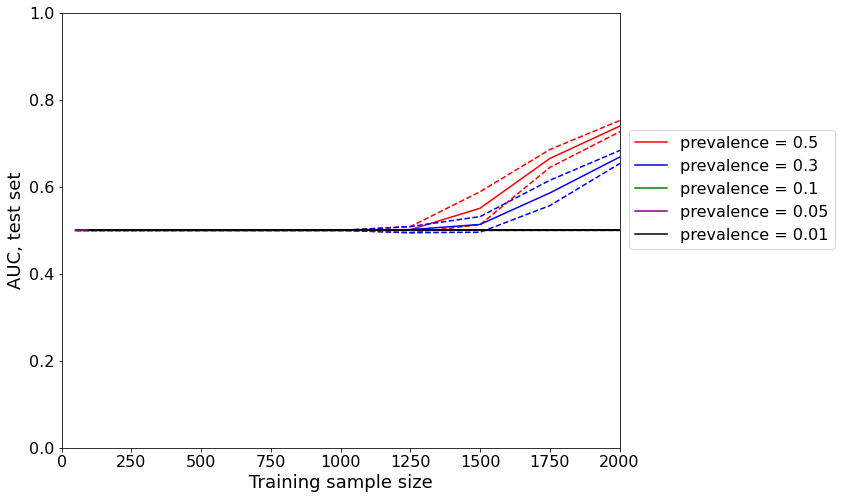

gen_spec


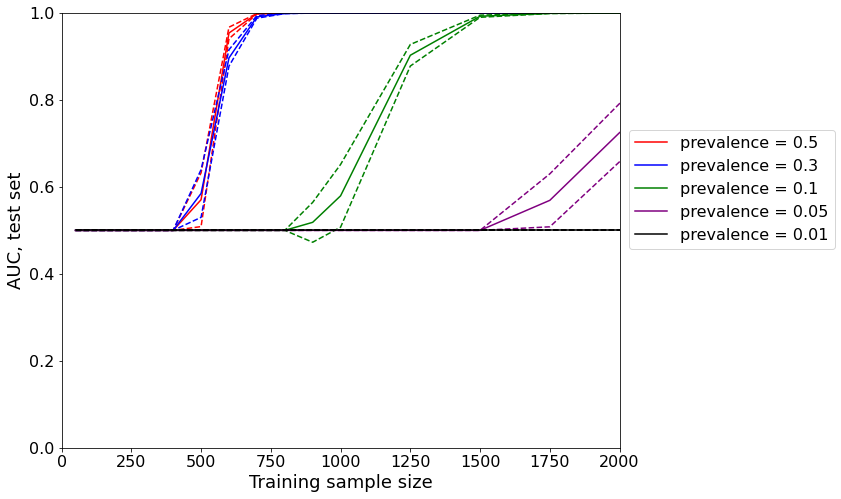

spec_gen


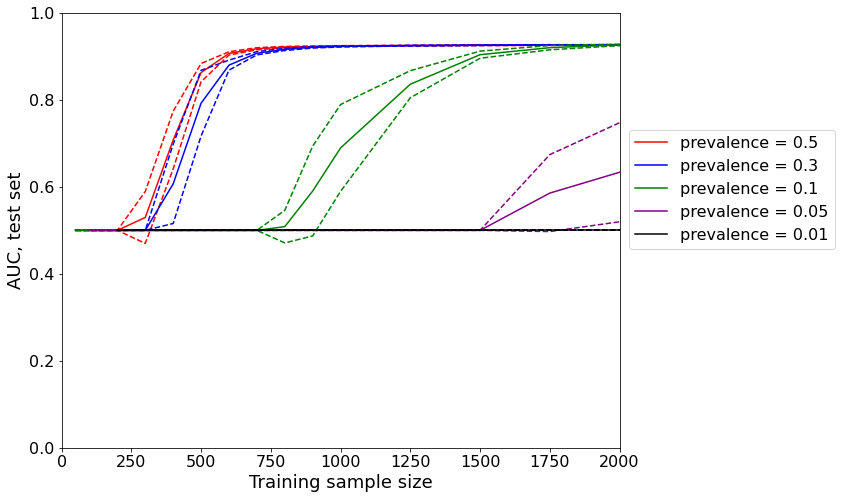

spec_spec


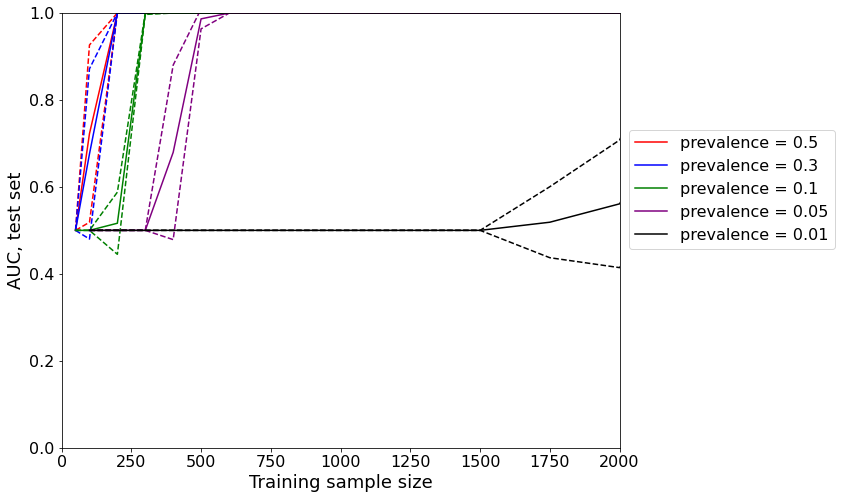

RF
gen_gen


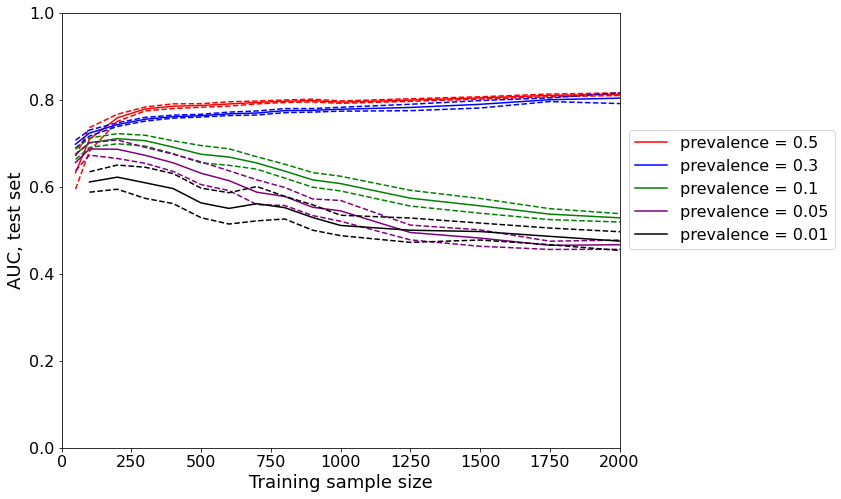

gen_spec


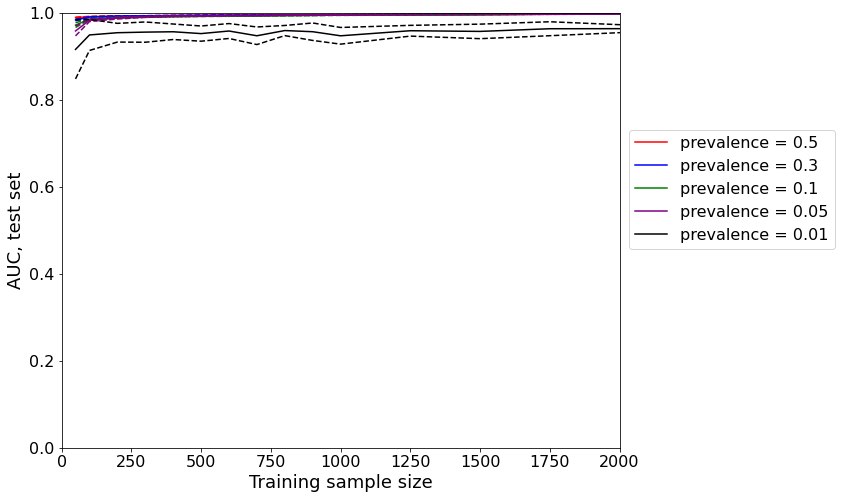

spec_gen


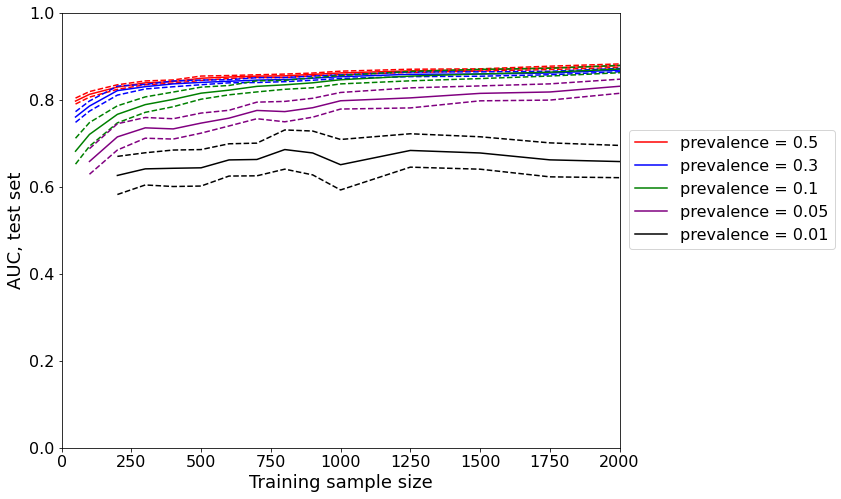

spec_spec


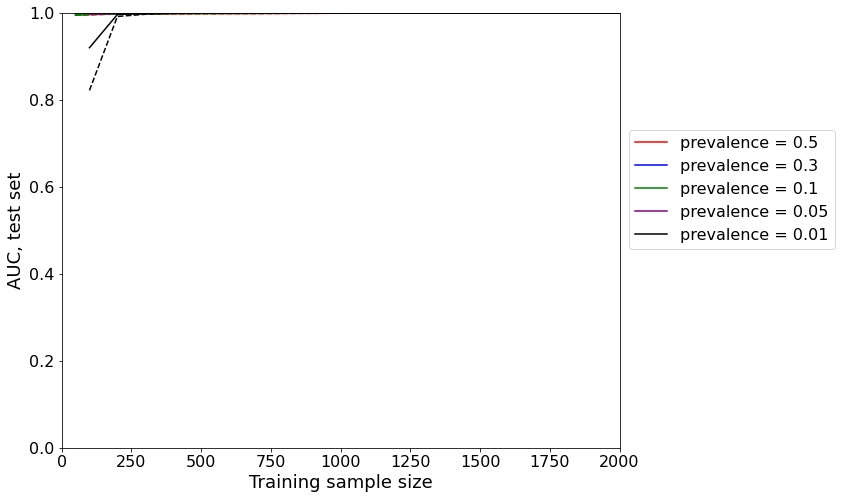

In [93]:
# AUC by training sample size; individual lines corresponding to prevalence rate

# specifying the two models
### note, although this says LogitL1, the models trained were actually elastic net
model = ["LogitL1", "RF"]

# specifying types of texts generated
types = ["gen_gen", "gen_spec", "spec_gen", "spec_spec"]

for mod in model:
    
    print(mod)
    
    for typedf in types:
        
        print(typedf)
        
        plt.figure(figsize=(10,8))
    
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "*ROCAUC_LargeTest"], 
                 color = "red", label = "prevalence = 0.5")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "*ROCAUC_LargeTest_plus_std"], 
                 color = "red", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "*ROCAUC_LargeTest_minus_std"], 
                 color = "red", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "*ROCAUC_LargeTest"], 
                 color = "blue", label = "prevalence = 0.3")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "*ROCAUC_LargeTest_plus_std"], 
                 color = "blue", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "*ROCAUC_LargeTest_minus_std"], 
                 color = "blue", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "*ROCAUC_LargeTest"], 
                 color = "green", label = "prevalence = 0.1")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "*ROCAUC_LargeTest_plus_std"], 
                 color = "green", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "*ROCAUC_LargeTest_minus_std"], 
                 color = "green", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "*ROCAUC_LargeTest"], 
                 color = "purple", label = "prevalence = 0.05")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "*ROCAUC_LargeTest_plus_std"], 
                 color = "purple", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "*ROCAUC_LargeTest_minus_std"], 
                 color = "purple", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "*ROCAUC_LargeTest"], 
                 color = "black", label = "prevalence = 0.01")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "*ROCAUC_LargeTest_plus_std"], 
                 color = "black", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "*ROCAUC_LargeTest_minus_std"], 
                 color = "black", linestyle = "dashed")

        plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.75), fontsize = 16)
        plt.xlabel("Training sample size", fontsize = 18)
        plt.ylabel("AUC, test set", fontsize = 18)
        plt.ylim([0, 1])
        plt.xlim([0, 2000])
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.show()

LogitL1
gen_gen


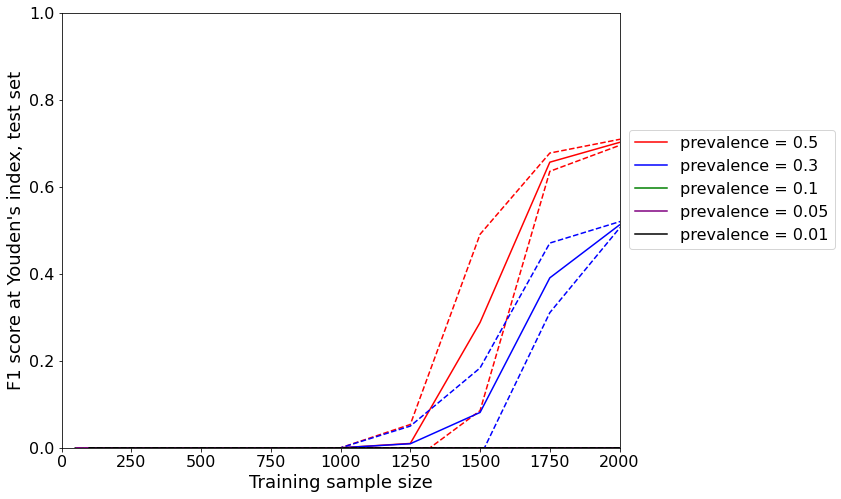

gen_spec


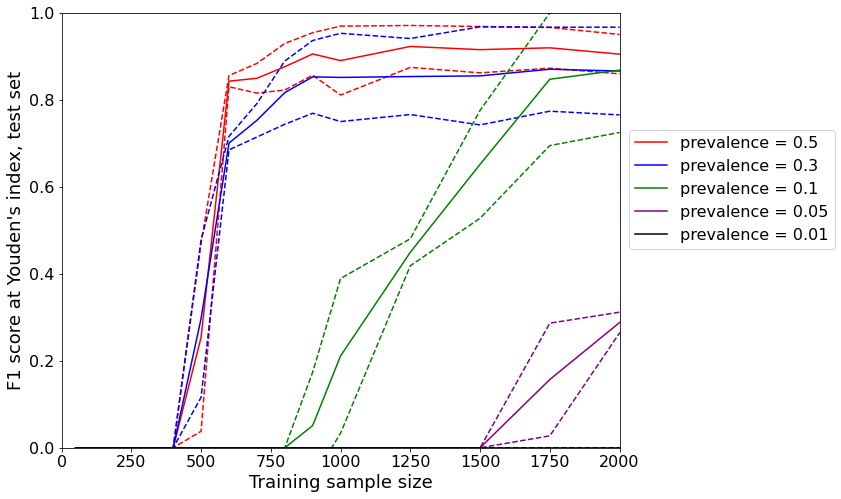

spec_gen


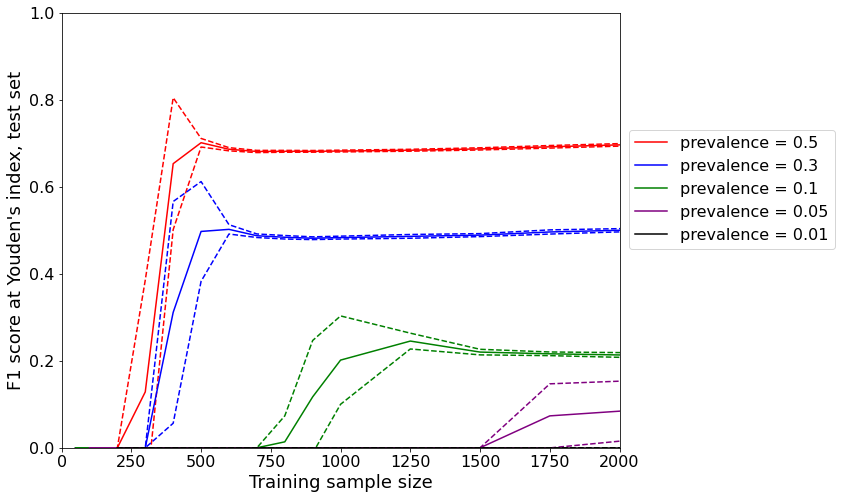

spec_spec


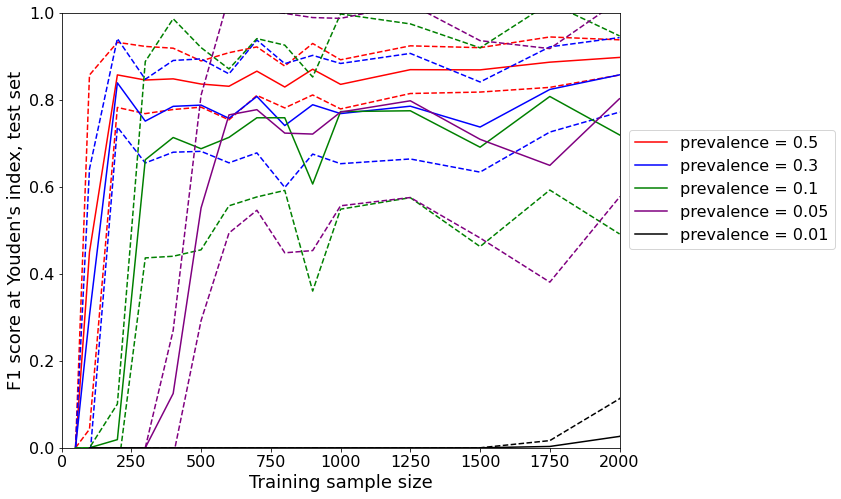

RF
gen_gen


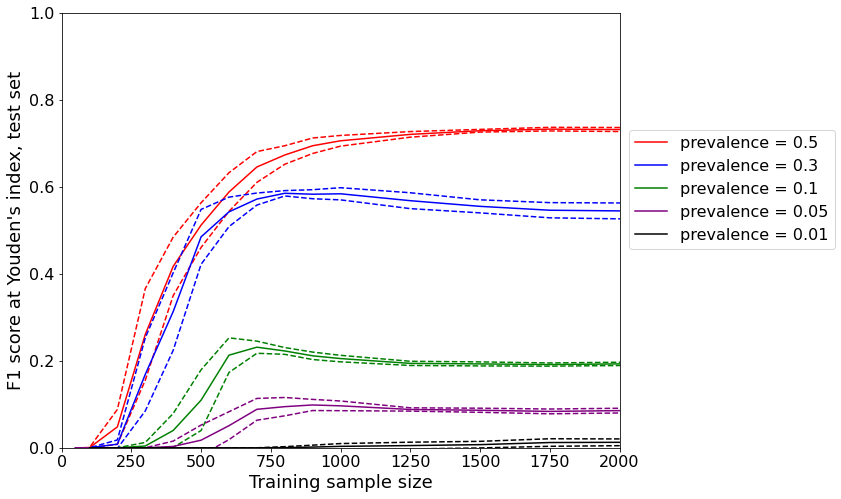

gen_spec


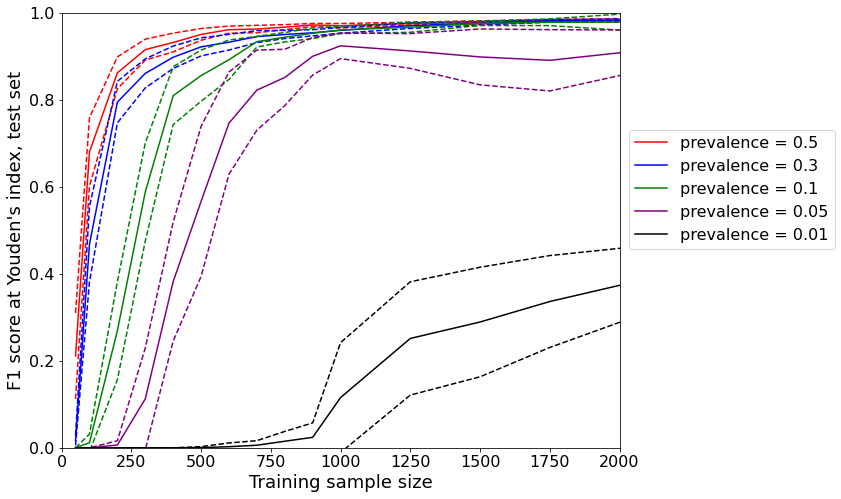

spec_gen


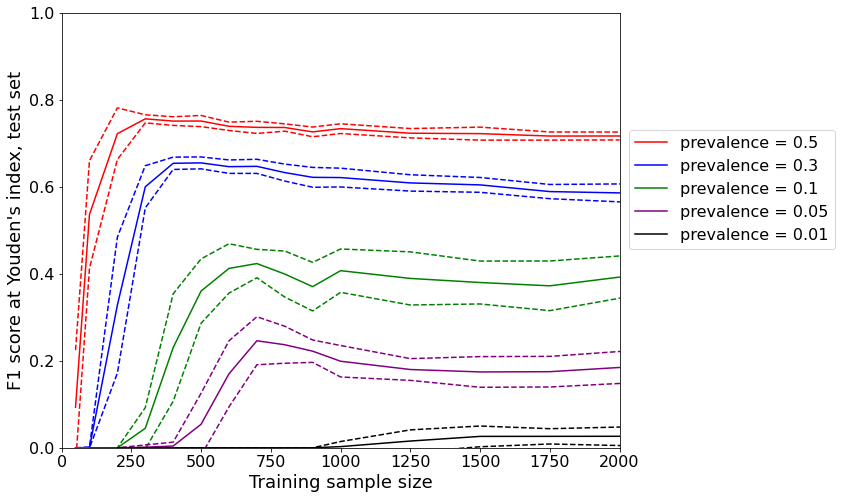

spec_spec


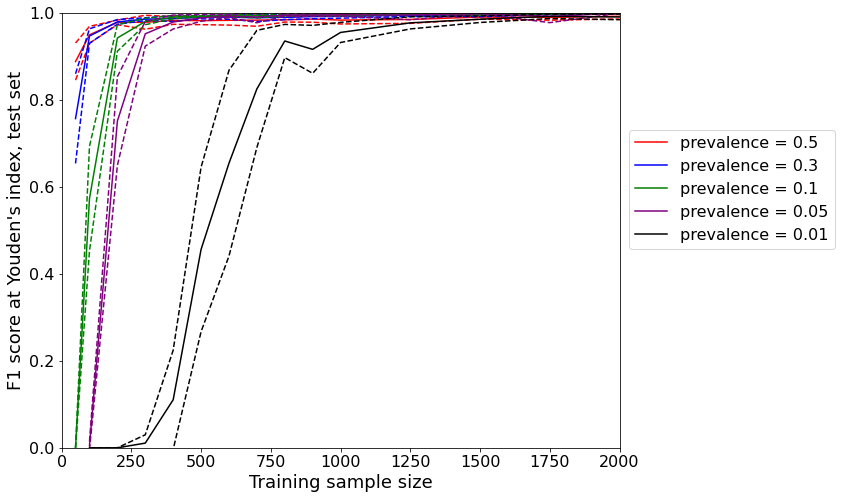

In [22]:
# F1 score by training sample size; individual lines corresponding to prevalence rate

model = ["LogitL1", "RF"]

types = ["gen_gen", "gen_spec", "spec_gen", "spec_spec"]

for mod in model:
    
    print(mod)
    
    for typedf in types:
        
        print(typedf)
        
        plt.figure(figsize=(10,8))
    
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "*F1_At_TrainYouden_Test"], 
                 color = "red", label = "prevalence = 0.5")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "*F1_At_TrainYouden_plus_std"], 
                 color = "red", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.5) & (df_combined.type == typedf), "*F1_At_TrainYouden_minus_std"], 
                 color = "red", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "*F1_At_TrainYouden_Test"], 
                 color = "blue", label = "prevalence = 0.3")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "*F1_At_TrainYouden_plus_std"], 
                 color = "blue", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.3) & (df_combined.type == typedf), "*F1_At_TrainYouden_minus_std"], 
                 color = "blue", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "*F1_At_TrainYouden_Test"], 
                 color = "green", label = "prevalence = 0.1")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "*F1_At_TrainYouden_plus_std"], 
                 color = "green", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.1) & (df_combined.type == typedf), "*F1_At_TrainYouden_minus_std"], 
                 color = "green", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "*F1_At_TrainYouden_Test"], 
                 color = "purple", label = "prevalence = 0.05")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "*F1_At_TrainYouden_plus_std"], 
                 color = "purple", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.05) & (df_combined.type == typedf), "*F1_At_TrainYouden_minus_std"], 
                 color = "purple", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "*F1_At_TrainYouden_Test"], 
                 color = "black", label = "prevalence = 0.01")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "*F1_At_TrainYouden_plus_std"], 
                 color = "black", linestyle = "dashed")

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.prevalence == 0.01) & (df_combined.type == typedf), "*F1_At_TrainYouden_minus_std"], 
                 color = "black", linestyle = "dashed")

        plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.75), fontsize = 16)
        plt.xlabel("Training sample size", fontsize = 18)
        plt.ylabel("F1 score at Youden's index, test set", fontsize = 18)
        plt.ylim([0, 1])
        plt.xlim([0, 2000])
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.show()

LogitL1
0.5


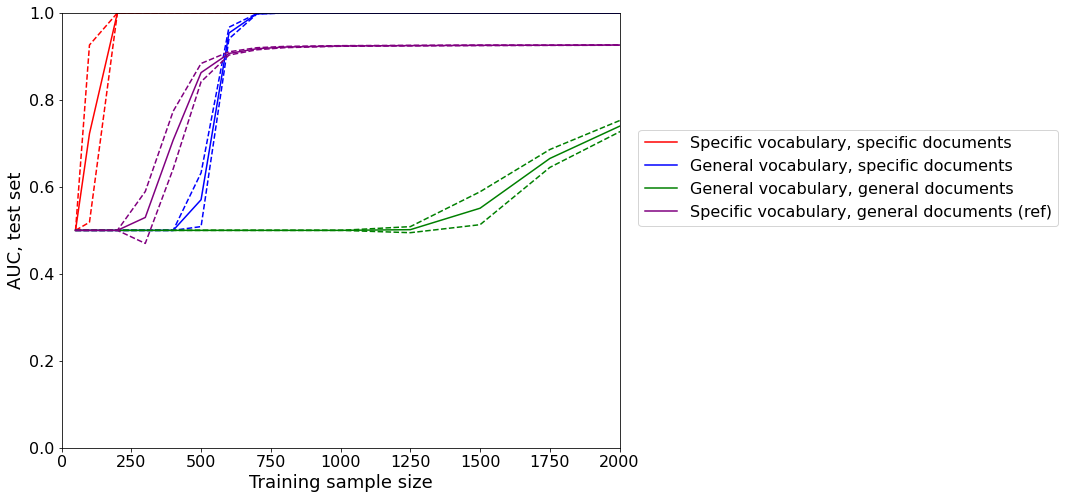

0.3


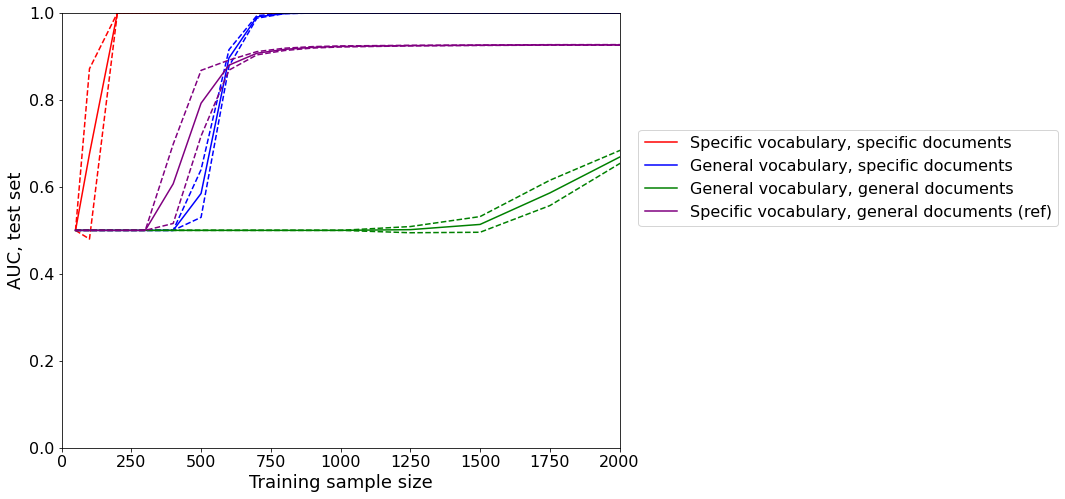

0.1


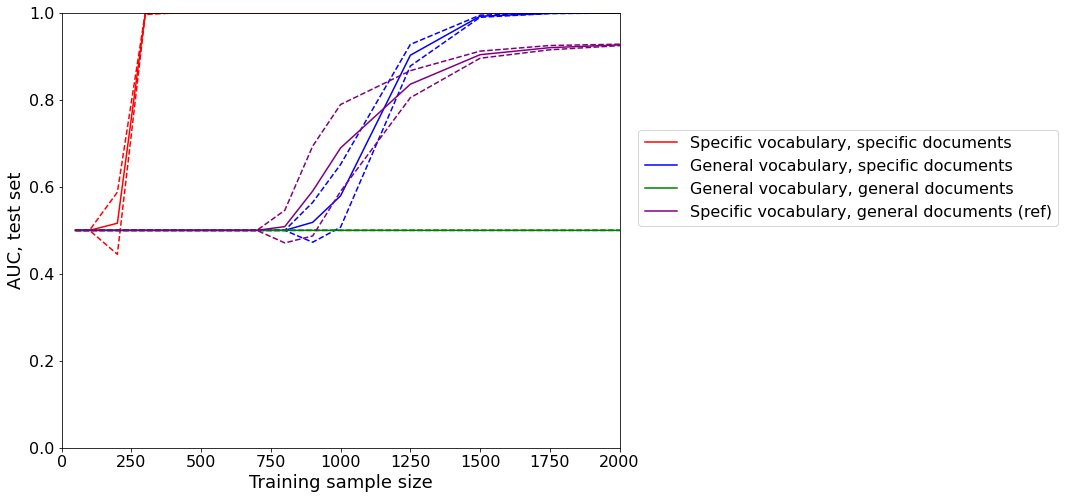

0.05


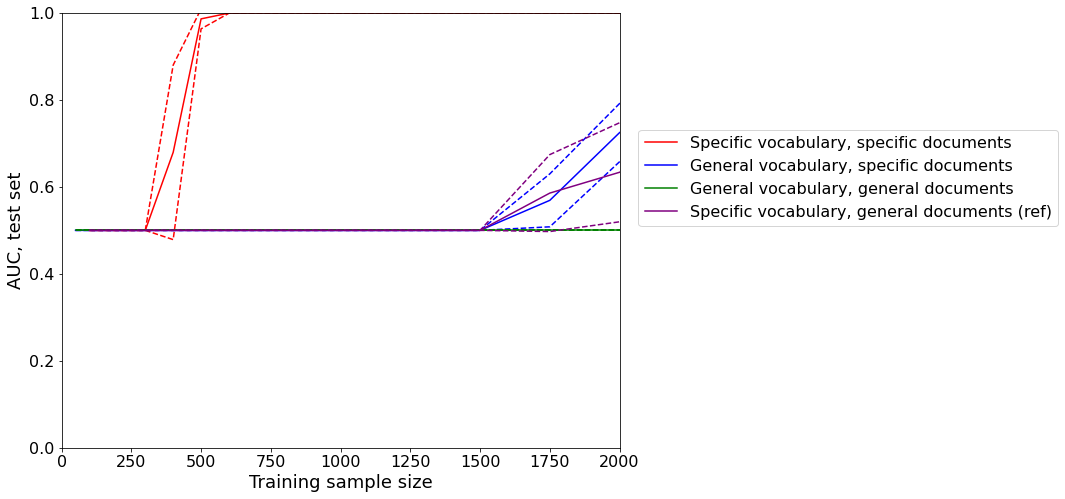

0.01


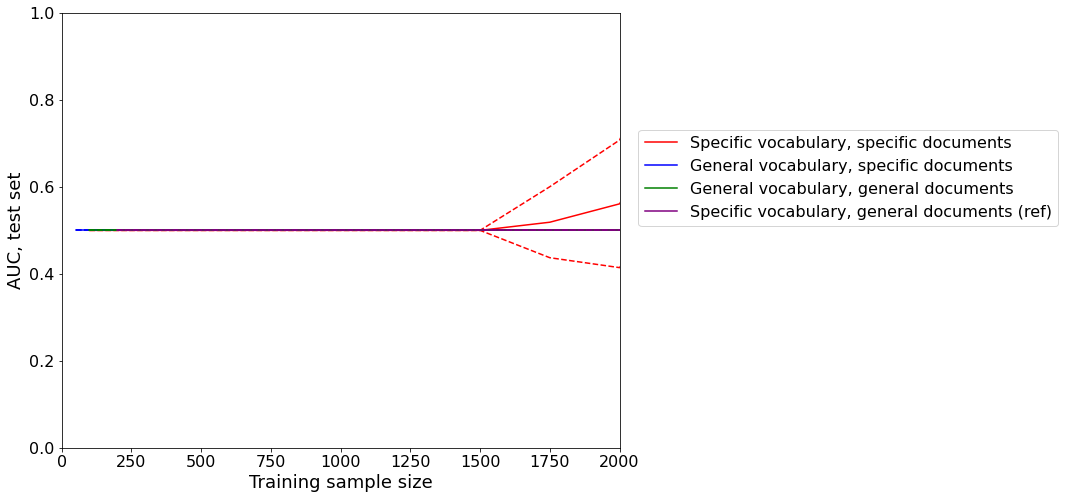

RF
0.5


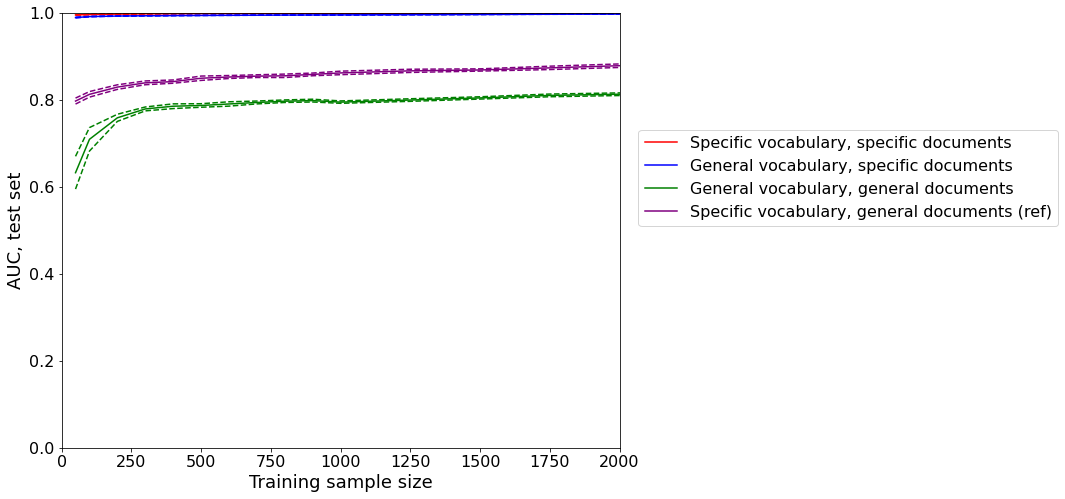

0.3


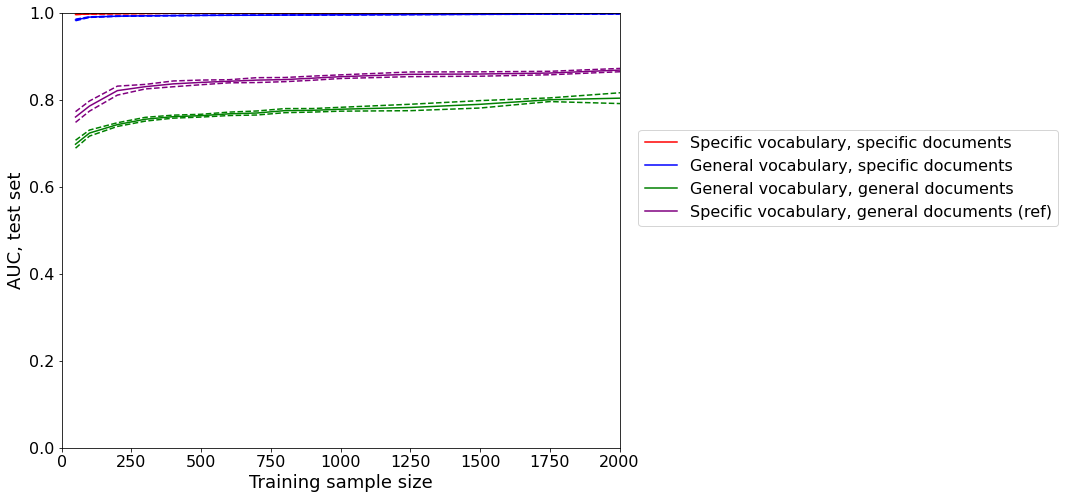

0.1


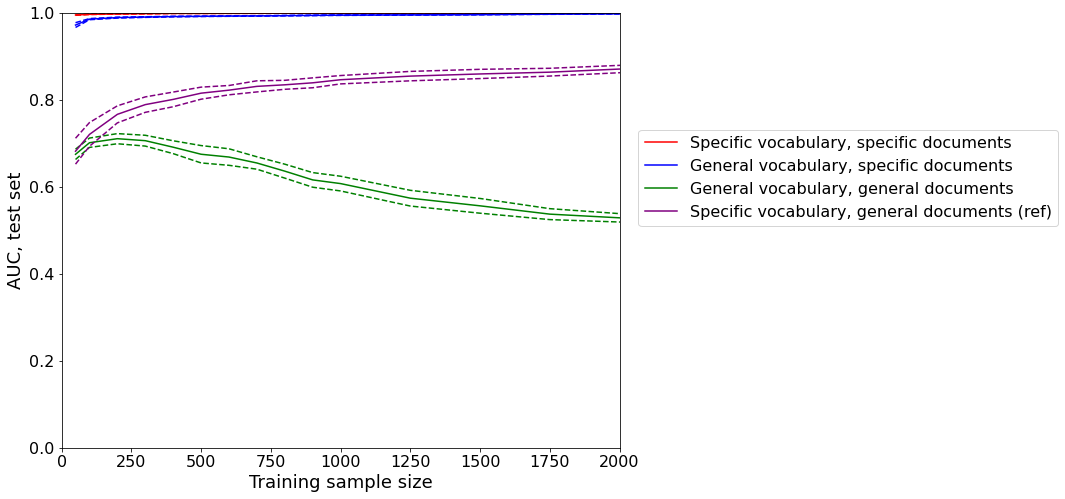

0.05


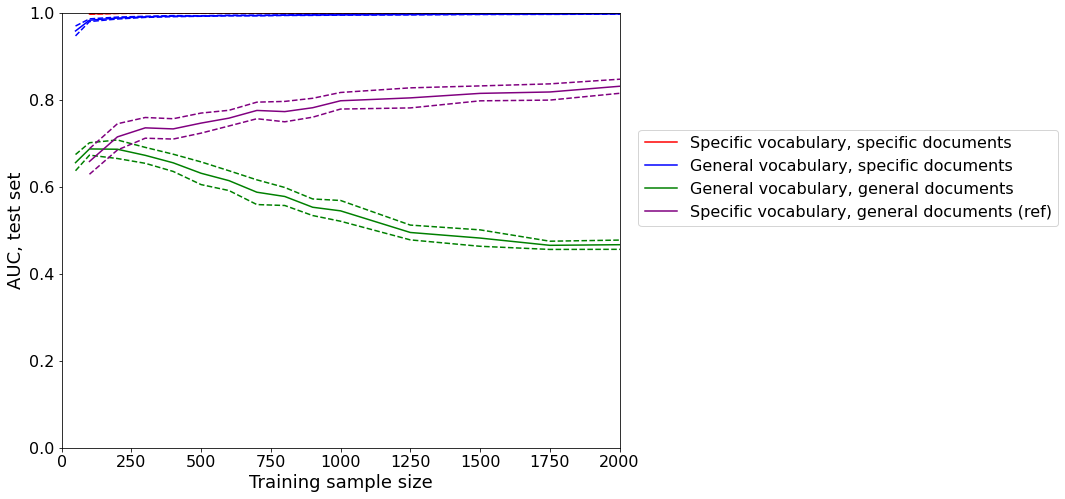

0.01


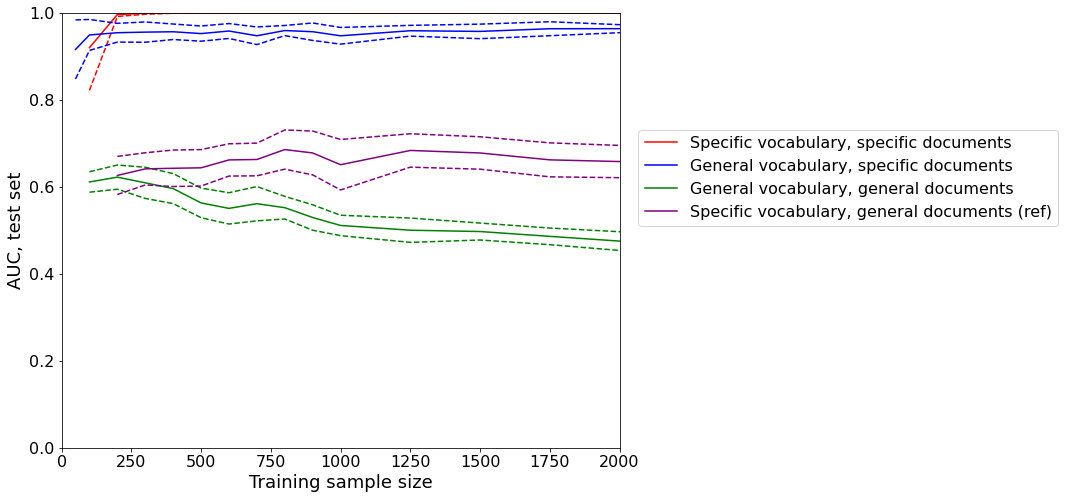

In [86]:
# AUC score by training sample size; individual lines corresponding to the four types of text types simulated

model = ["LogitL1", "RF"]

prev = [0.5, 0.3, 0.1, 0.05, 0.01]

for mod in model:
    
    print(mod)
    
    for prev_rate in prev:
        
        print(str(prev_rate))
        
        plt.figure(figsize=(10,8))

        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest"], 
                 color = "red", label = "Specific vocabulary, specific documents")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest_plus_std"], 
                 color = "red", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest_minus_std"], 
                 color = "red", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest"], 
                 color = "blue", label = "General vocabulary, specific documents")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest_plus_std"], 
                 color = "blue", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest_minus_std"], 
                 color = "blue", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest"], 
                 color = "green", label = "General vocabulary, general documents")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest_plus_std"], 
                 color = "green", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest_minus_std"], 
                 color = "green", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest"], 
                 color = "purple", label = "Specific vocabulary, general documents (ref)")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest_plus_std"], 
                 color = "purple", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "*ROCAUC_LargeTest_minus_std"], 
                 color = "purple", linestyle = "dashed")

        plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.75), fontsize = 16)
        plt.xlabel("Training sample size", fontsize = 18)
        plt.ylabel("AUC, test set", fontsize = 18)
        plt.ylim([0, 1])
        plt.xlim([0, 2000])
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.show()

LogitL1
0.5


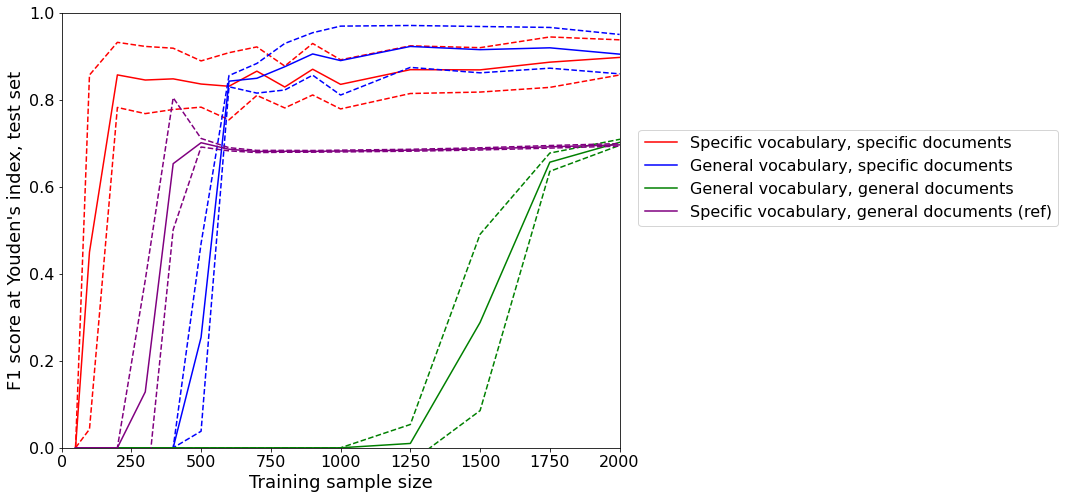

0.3


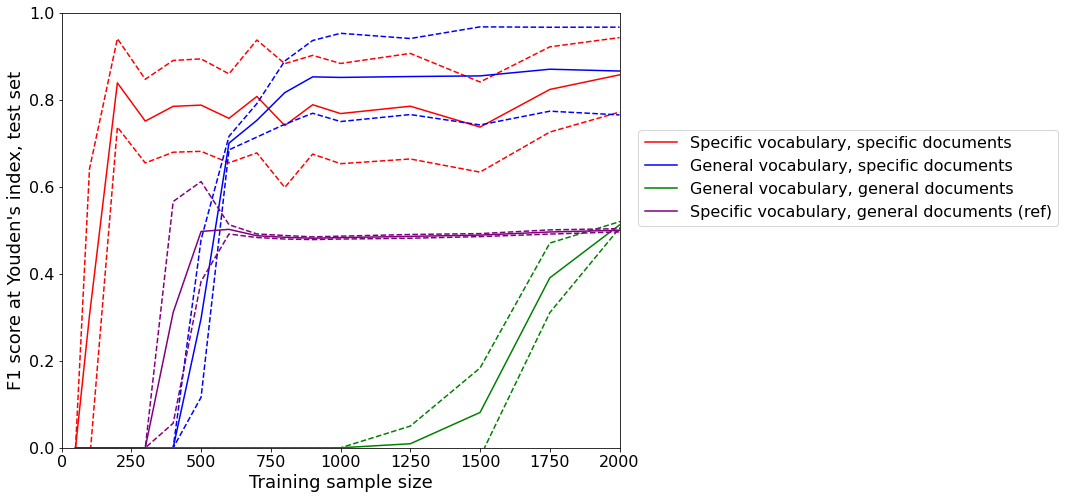

0.1


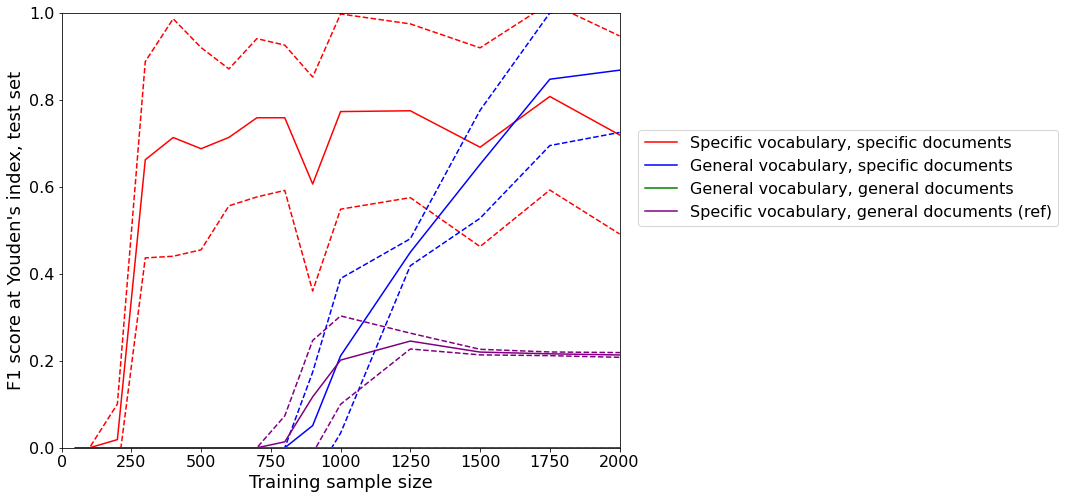

0.05


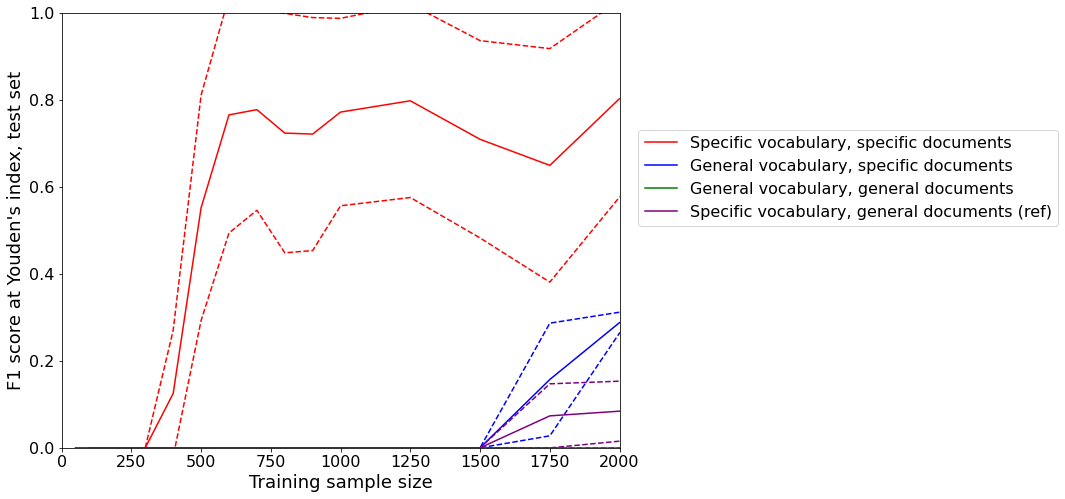

0.01


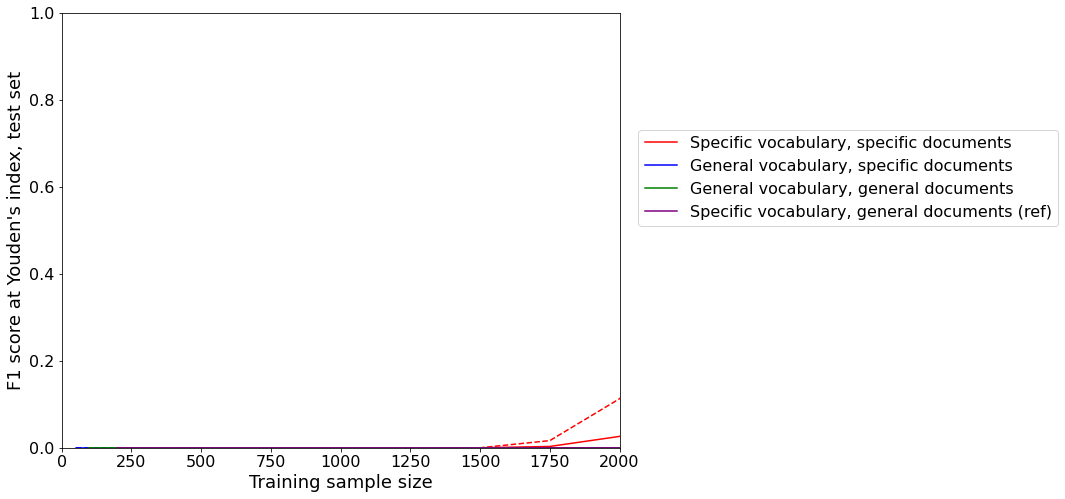

RF
0.5


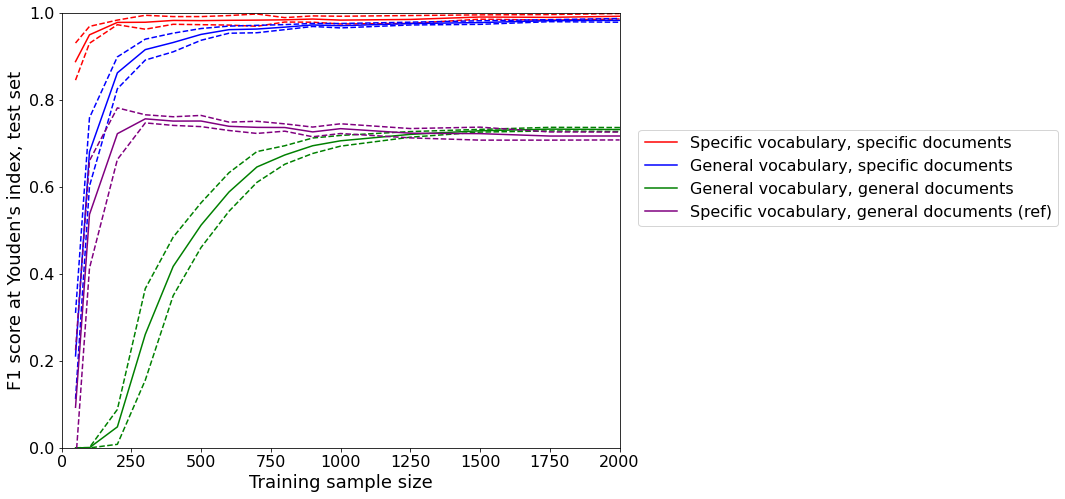

0.3


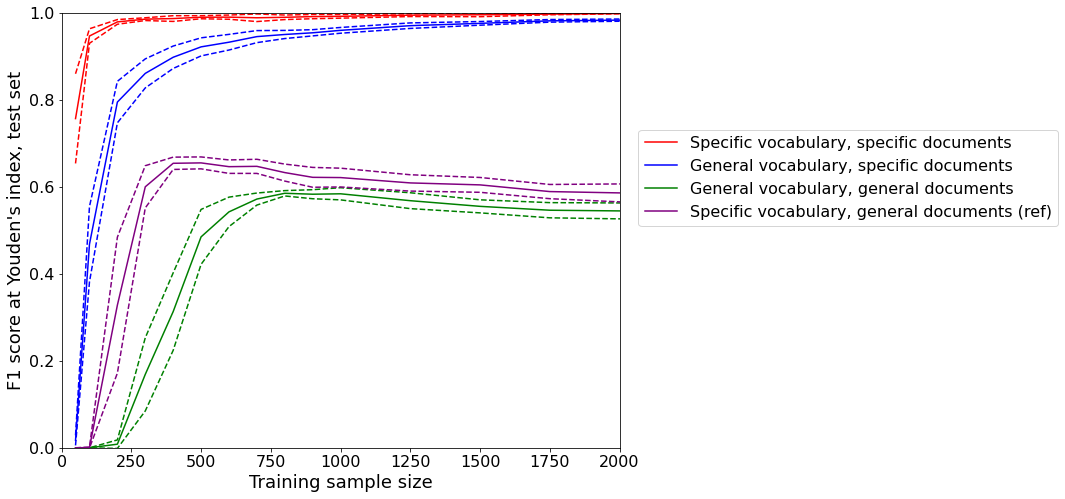

0.1


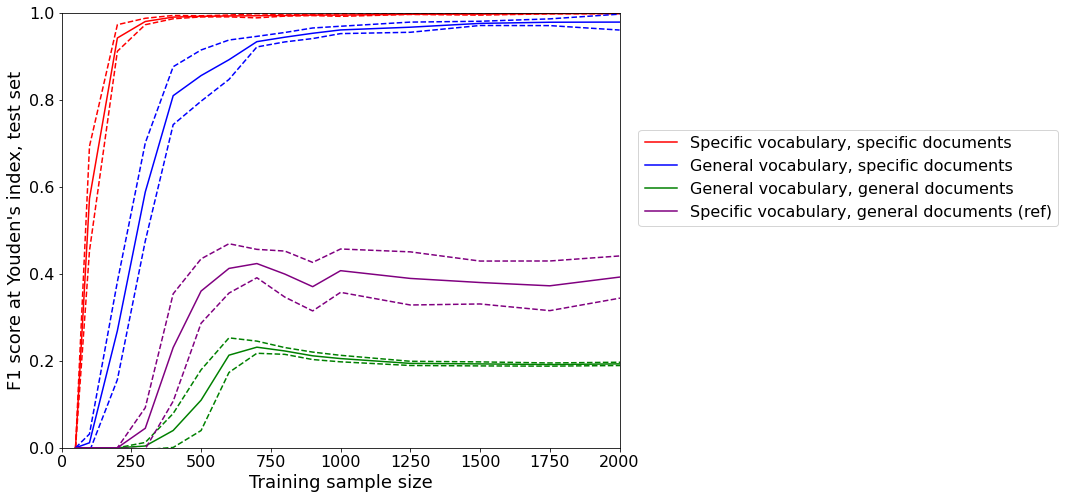

0.05


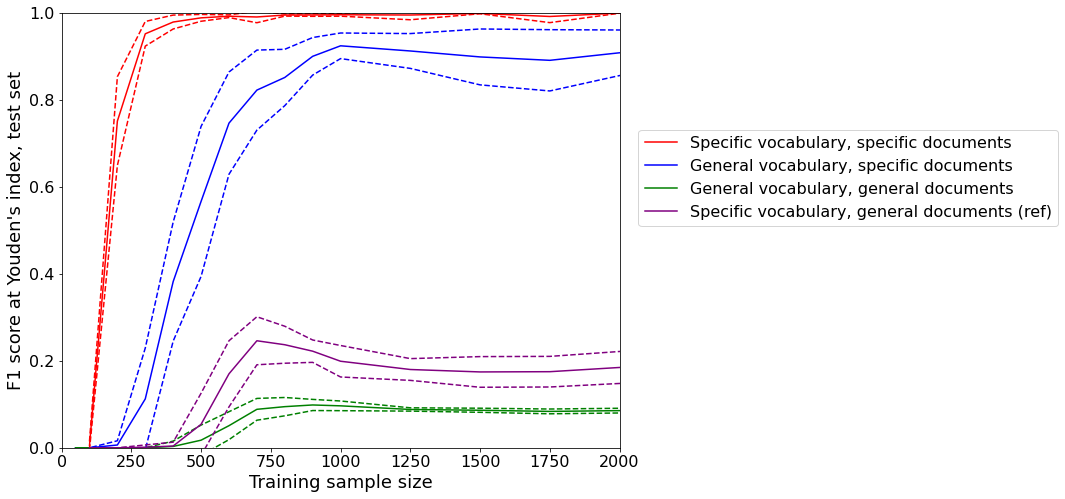

0.01


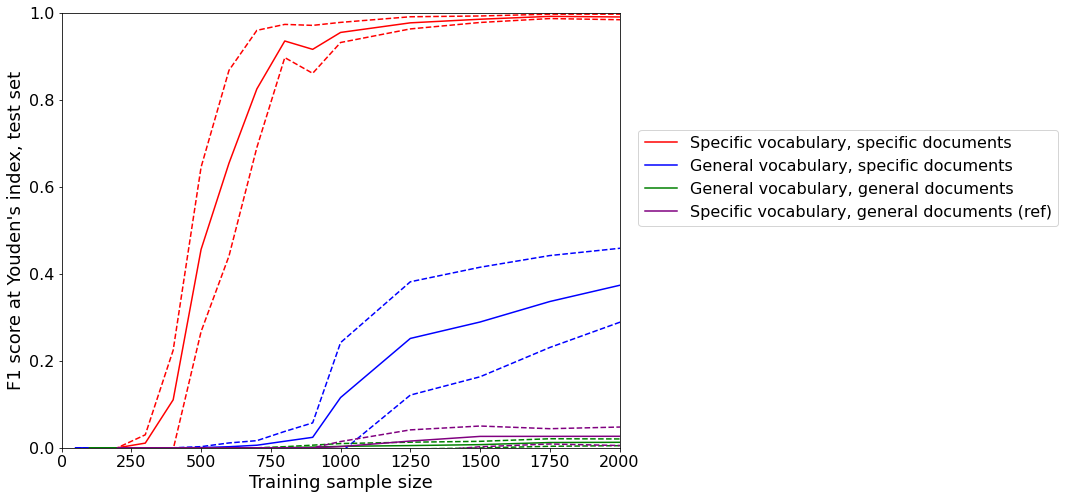

In [83]:
# F1 score by training sample size; individual lines corresponding to the four types of texts simulated

model = ["LogitL1", "RF"]

prev = [0.5, 0.3, 0.1, 0.05, 0.01]

for mod in model:
    
    print(mod)
    
    for prev_rate in prev:
        
        print(str(prev_rate))
        
        plt.figure(figsize=(10,8))
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_Test"], 
                 color = "red", label = "Specific vocabulary, specific documents")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_plus_std"], 
                 color = "red", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_spec") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_minus_std"], 
                 color = "red", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_Test"], 
                 color = "blue", label = "General vocabulary, specific documents")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_plus_std"], 
                 color = "blue", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_spec") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_minus_std"], 
                 color = "blue", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_Test"], 
                 color = "green", label = "General vocabulary, general documents")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_plus_std"], 
                 color = "green", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "gen_gen") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_minus_std"], 
                 color = "green", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_Test"], 
                 color = "purple", label = "Specific vocabulary, general documents (ref)")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_plus_std"], 
                 color = "purple", linestyle = "dashed")
        
        plt.plot(df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "n_train"], 
                 df_combined.loc[(df_combined['Unnamed: 0'] == mod) & (df_combined.type == "spec_gen") & (df_combined.prevalence == prev_rate), "*F1_At_TrainYouden_minus_std"], 
                 color = "purple", linestyle = "dashed")

        plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.75), fontsize = 16)
        plt.xlabel("Training sample size", fontsize = 18)
        plt.ylabel("F1 score at Youden's index, test set", fontsize = 18)
        plt.ylim([0, 1])
        plt.xlim([0, 2000])
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.show()

# Calculating sample size requirements for specified F1 and AUC score

For each type of text, displaying the smallest sample size to exceed a particular score

## F1-score

### Random forest

#### prevalence 0.5

In [10]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.9) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1236                 0.915622   gen_spec      300
1348                 0.949635  spec_spec      100

In [11]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.8) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1232                 0.862237   gen_spec      200
1344                 0.888098  spec_spec       50

In [12]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.7) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1196                 0.705967    gen_gen     1000
1232                 0.862237   gen_spec      200
1292                 0.722316   spec_gen      200
1344                 0.888098  spec_spec       50

In [13]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.6) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1184                 0.645713    gen_gen      700
1228                 0.680374   gen_spec      100
1292                 0.722316   spec_gen      200
1344                 0.888098  spec_spec       50

In [14]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.5) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1176                 0.512046    gen_gen      500
1228                 0.680374   gen_spec      100
1288                 0.536594   spec_gen      100
1344                 0.888098  spec_spec       50

In [15]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.4) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1172                 0.417125    gen_gen      400
1228                 0.680374   gen_spec      100
1288                 0.536594   spec_gen      100
1344                 0.888098  spec_spec       50

In [16]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.3) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1172                 0.417125    gen_gen      400
1228                 0.680374   gen_spec      100
1288                 0.536594   spec_gen      100
1344                 0.888098  spec_spec       50

In [17]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.2) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1168                 0.260758    gen_gen      300
1224                 0.211221   gen_spec       50
1288                 0.536594   spec_gen      100
1344                 0.888098  spec_spec       50

In [18]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.1) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1168                 0.260758    gen_gen      300
1224                 0.211221   gen_spec       50
1288                 0.536594   spec_gen      100
1344                 0.888098  spec_spec       50

#### prevalence 0.3

In [19]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.9) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
988                  0.921933   gen_spec      500
1100                 0.946858  spec_spec      100

In [20]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.8) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
980                  0.860951   gen_spec      300
1100                 0.946858  spec_spec      100

In [21]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.7) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
976                  0.794982   gen_spec      200
1096                 0.756988  spec_spec       50

In [22]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.6) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
976                  0.794982   gen_spec      200
1040                 0.600173   spec_gen      300
1096                 0.756988  spec_spec       50

In [23]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.5) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
916                  0.542523    gen_gen      600
976                  0.794982   gen_spec      200
1040                 0.600173   spec_gen      300
1096                 0.756988  spec_spec       50

In [24]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.4) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
912                  0.485037    gen_gen      500
972                  0.468231   gen_spec      100
1040                 0.600173   spec_gen      300
1096                 0.756988  spec_spec       50

In [25]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.3) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
908                  0.313181    gen_gen      400
972                  0.468231   gen_spec      100
1036                 0.328019   spec_gen      200
1096                 0.756988  spec_spec       50

In [26]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.2) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
908                  0.313181    gen_gen      400
972                  0.468231   gen_spec      100
1036                 0.328019   spec_gen      200
1096                 0.756988  spec_spec       50

In [27]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.1) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
904                  0.168876    gen_gen      300
972                  0.468231   gen_spec      100
1036                 0.328019   spec_gen      200
1096                 0.756988  spec_spec       50

#### prevalence 0.1

In [28]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.9) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
724                 0.933935   gen_spec      700
840                 0.942401  spec_spec      200

In [29]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.8) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
712                 0.809699   gen_spec      400
840                 0.942401  spec_spec      200

In [30]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.7) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
712                 0.809699   gen_spec      400
840                 0.942401  spec_spec      200

In [31]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.6) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
712                 0.809699   gen_spec      400
840                 0.942401  spec_spec      200

In [32]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.5) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
708                 0.588234   gen_spec      300
836                 0.573009  spec_spec      100

In [33]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.4) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
708                 0.588234   gen_spec      300
780                 0.412491   spec_gen      600
836                 0.573009  spec_spec      100

In [34]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.3) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
708                 0.588234   gen_spec      300
776                 0.360413   spec_gen      500
836                 0.573009  spec_spec      100

In [35]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.2) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
644                 0.213017    gen_gen      600
704                 0.269263   gen_spec      200
772                 0.230560   spec_gen      400
836                 0.573009  spec_spec      100

In [36]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.1) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
640                 0.109507    gen_gen      500
704                 0.269263   gen_spec      200
772                 0.230560   spec_gen      400
836                 0.573009  spec_spec      100

#### prevalence 0.05

In [37]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.9) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
440                 0.900210   gen_spec      900
568                 0.951999  spec_spec      300

In [38]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.8) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
432                 0.822507   gen_spec      700
568                 0.951999  spec_spec      300

In [39]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.7) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
428                 0.746548   gen_spec      600
564                 0.751234  spec_spec      200

In [40]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.6) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
428                 0.746548   gen_spec      600
564                 0.751234  spec_spec      200

In [41]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.5) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
424                 0.566583   gen_spec      500
564                 0.751234  spec_spec      200

In [42]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.4) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
424                 0.566583   gen_spec      500
564                 0.751234  spec_spec      200

In [43]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.3) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
420                 0.382221   gen_spec      400
564                 0.751234  spec_spec      200

In [44]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.2) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
420                 0.382221   gen_spec      400
504                 0.246127   spec_gen      700
564                 0.751234  spec_spec      200

In [45]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.1) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
416                 0.112429   gen_spec      300
500                 0.170089   spec_gen      600
564                 0.751234  spec_spec      200

#### prevalence 0.01

In [46]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.9) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
272                 0.935435  spec_spec      800

In [47]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.8) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
268                 0.825304  spec_spec      700

In [48]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.7) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
268                 0.825304  spec_spec      700

In [49]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.6) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
264                 0.654437  spec_spec      600

In [50]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.5) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
264                 0.654437  spec_spec      600

In [51]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.4) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
260                 0.456167  spec_spec      500

In [52]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.3) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
136                 0.336377   gen_spec     1750
260                 0.456167  spec_spec      500

In [53]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.2) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
128                 0.251487   gen_spec     1250
260                 0.456167  spec_spec      500

In [54]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*F1_At_TrainYouden_Test"] > 0.1) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
124                 0.115555   gen_spec     1000
256                 0.110401  spec_spec      400

### Elastic net

#### prevalence 0.5

In [55]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.9) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test      type  n_train
1261                 0.905655  gen_spec      900

In [56]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.8) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1249                 0.843059   gen_spec      600
1353                 0.857489  spec_spec      200

In [57]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.7) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1213                 0.702329    gen_gen     2000
1249                 0.843059   gen_spec      600
1305                 0.701522   spec_gen      500
1353                 0.857489  spec_spec      200

In [58]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.6) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1209                 0.656757    gen_gen     1750
1249                 0.843059   gen_spec      600
1301                 0.653335   spec_gen      400
1353                 0.857489  spec_spec      200

In [59]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.5) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1209                 0.656757    gen_gen     1750
1249                 0.843059   gen_spec      600
1301                 0.653335   spec_gen      400
1353                 0.857489  spec_spec      200

In [60]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.4) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1209                 0.656757    gen_gen     1750
1249                 0.843059   gen_spec      600
1301                 0.653335   spec_gen      400
1349                 0.449957  spec_spec      100

In [61]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.3) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1209                 0.656757    gen_gen     1750
1249                 0.843059   gen_spec      600
1301                 0.653335   spec_gen      400
1349                 0.449957  spec_spec      100

In [62]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.2) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1205                 0.288235    gen_gen     1500
1245                 0.253994   gen_spec      500
1301                 0.653335   spec_gen      400
1349                 0.449957  spec_spec      100

In [63]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.1) & (df_combined["prevalence"] == 0.5), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1205                 0.288235    gen_gen     1500
1245                 0.253994   gen_spec      500
1297                 0.128588   spec_gen      300
1349                 0.449957  spec_spec      100

#### prevalence 0.3

In [64]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.9) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [65]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.8) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
1001                 0.816699   gen_spec      800
1105                 0.839185  spec_spec      200

In [66]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.7) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
993                  0.700637   gen_spec      600
1105                 0.839185  spec_spec      200

In [67]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.6) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
993                  0.700637   gen_spec      600
1105                 0.839185  spec_spec      200

In [68]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.5) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
949                  0.512641    gen_gen     2000
993                  0.700637   gen_spec      600
1053                 0.502309   spec_gen      600
1105                 0.839185  spec_spec      200

In [69]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.4) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
949                  0.512641    gen_gen     2000
993                  0.700637   gen_spec      600
1049                 0.497518   spec_gen      500
1105                 0.839185  spec_spec      200

In [70]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.3) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
945                  0.390825    gen_gen     1750
993                  0.700637   gen_spec      600
1045                 0.311409   spec_gen      400
1101                 0.304176  spec_spec      100

In [71]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.2) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
945                  0.390825    gen_gen     1750
989                  0.297363   gen_spec      500
1045                 0.311409   spec_gen      400
1101                 0.304176  spec_spec      100

In [72]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.1) & (df_combined["prevalence"] == 0.3), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
945                  0.390825    gen_gen     1750
989                  0.297363   gen_spec      500
1045                 0.311409   spec_gen      400
1101                 0.304176  spec_spec      100

#### prevalence 0.1

In [73]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.9) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [74]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.8) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
749                 0.847532   gen_spec     1750
885                 0.807854  spec_spec     1750

In [75]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.7) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
749                 0.847532   gen_spec     1750
849                 0.713529  spec_spec      400

In [76]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.6) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
745                 0.651890   gen_spec     1500
845                 0.662403  spec_spec      300

In [77]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.5) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
745                 0.651890   gen_spec     1500
845                 0.662403  spec_spec      300

In [78]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.4) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
741                 0.449721   gen_spec     1250
845                 0.662403  spec_spec      300

In [79]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.3) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
741                 0.449721   gen_spec     1250
845                 0.662403  spec_spec      300

In [80]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.2) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
737                 0.211430   gen_spec     1000
797                 0.201682   spec_gen     1000
845                 0.662403  spec_spec      300

In [81]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.1) & (df_combined["prevalence"] == 0.1), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
737                 0.211430   gen_spec     1000
793                 0.117164   spec_gen      900
845                 0.662403  spec_spec      300

#### prevalence 0.05

In [82]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.9) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [83]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.8) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
613                 0.802947  spec_spec     2000

In [84]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.7) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
581                 0.765529  spec_spec      600

In [85]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.6) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
581                 0.765529  spec_spec      600

In [86]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.5) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
577                 0.551615  spec_spec      500

In [87]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.4) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
577                 0.551615  spec_spec      500

In [88]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.3) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
577                 0.551615  spec_spec      500

In [89]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.2) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
461                 0.287992   gen_spec     2000
577                 0.551615  spec_spec      500

In [90]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.1) & (df_combined["prevalence"] == 0.05), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

*F1_At_TrainYouden_Test       type  n_train
457                 0.157056   gen_spec     1750
573                 0.124880  spec_spec      400

#### prevalence 0.01

In [91]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.9) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [92]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.8) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [93]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.7) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [94]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.6) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [95]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.5) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [96]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.4) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [97]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.3) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [98]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.2) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

In [99]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*F1_At_TrainYouden_Test"] > 0.1) & (df_combined["prevalence"] == 0.01), ["*F1_At_TrainYouden_Test", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*F1_At_TrainYouden_Test, type, n_train]
Index: []

## ROC-AUC

### Random forest

#### prevalence 0.5

In [100]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.9) & (df_combined["prevalence"] == 0.5), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
1224           0.989319   gen_spec       50
1344           0.995466  spec_spec       50

In [101]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.8) & (df_combined["prevalence"] == 0.5), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
1204           0.804539    gen_gen     1500
1224           0.989319   gen_spec       50
1288           0.812773   spec_gen      100
1344           0.995466  spec_spec       50

In [102]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.7) & (df_combined["prevalence"] == 0.5), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
1160           0.709389    gen_gen      100
1224           0.989319   gen_spec       50
1284           0.797306   spec_gen       50
1344           0.995466  spec_spec       50

In [103]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.6) & (df_combined["prevalence"] == 0.5), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
1156           0.632581    gen_gen       50
1224           0.989319   gen_spec       50
1284           0.797306   spec_gen       50
1344           0.995466  spec_spec       50

#### prevalence 0.3

In [104]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.9) & (df_combined["prevalence"] == 0.3), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
968            0.983804   gen_spec       50
1096           0.996532  spec_spec       50

In [105]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.8) & (df_combined["prevalence"] == 0.3), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
944            0.800378    gen_gen     1750
968            0.983804   gen_spec       50
1036           0.821331   spec_gen      200
1096           0.996532  spec_spec       50

In [106]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.7) & (df_combined["prevalence"] == 0.3), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
896            0.723721    gen_gen      100
968            0.983804   gen_spec       50
1028           0.760608   spec_gen       50
1096           0.996532  spec_spec       50

In [107]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.6) & (df_combined["prevalence"] == 0.3), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
892            0.698089    gen_gen       50
968            0.983804   gen_spec       50
1028           0.760608   spec_gen       50
1096           0.996532  spec_spec       50

#### prevalence 0.1

In [108]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.9) & (df_combined["prevalence"] == 0.1), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
696           0.972067   gen_spec       50
832           0.995295  spec_spec       50

In [109]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.8) & (df_combined["prevalence"] == 0.1), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
696           0.972067   gen_spec       50
772           0.801143   spec_gen      400
832           0.995295  spec_spec       50

In [110]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.7) & (df_combined["prevalence"] == 0.1), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
624           0.701474    gen_gen      100
696           0.972067   gen_spec       50
760           0.720648   spec_gen      100
832           0.995295  spec_spec       50

In [111]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.6) & (df_combined["prevalence"] == 0.1), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
620           0.674859    gen_gen       50
696           0.972067   gen_spec       50
756           0.682026   spec_gen       50
832           0.995295  spec_spec       50

#### prevalence 0.05

In [112]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.9) & (df_combined["prevalence"] == 0.05), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
404           0.958529   gen_spec       50
560           0.997865  spec_spec      100

In [113]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.8) & (df_combined["prevalence"] == 0.05), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
404           0.958529   gen_spec       50
520           0.804634   spec_gen     1250
560           0.997865  spec_spec      100

In [114]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.7) & (df_combined["prevalence"] == 0.05), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
404           0.958529   gen_spec       50
484           0.714934   spec_gen      200
560           0.997865  spec_spec      100

In [115]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.6) & (df_combined["prevalence"] == 0.05), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
316           0.655738    gen_gen       50
404           0.958529   gen_spec       50
480           0.658444   spec_gen      100
560           0.997865  spec_spec      100

#### prevalence 0.01

In [116]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.9) & (df_combined["prevalence"] == 0.01), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
84            0.916092   gen_spec      100
244           0.920038  spec_spec      100

In [117]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.8) & (df_combined["prevalence"] == 0.01), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
84            0.916092   gen_spec      100
244           0.920038  spec_spec      100

In [118]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.7) & (df_combined["prevalence"] == 0.01), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
84            0.916092   gen_spec      100
244           0.920038  spec_spec      100

In [119]:
df_combined.loc[(df_combined["Unnamed: 0"] == "RF") & (df_combined["*ROCAUC_LargeTest"] > 0.6) & (df_combined["prevalence"] == 0.01), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
0             0.611261    gen_gen      100
84            0.916092   gen_spec      100
164           0.626278   spec_gen      200
244           0.920038  spec_spec      100

### Elastic net

#### prevalence 0.5

In [120]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.9) & (df_combined["prevalence"] == 0.5), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
1249           0.953839   gen_spec      600
1309           0.906864   spec_gen      600
1353           0.999935  spec_spec      200

In [121]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.8) & (df_combined["prevalence"] == 0.5), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
1249           0.953839   gen_spec      600
1305           0.862745   spec_gen      500
1353           0.999935  spec_spec      200

In [122]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.7) & (df_combined["prevalence"] == 0.5), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
1213           0.739474    gen_gen     2000
1249           0.953839   gen_spec      600
1301           0.707687   spec_gen      400
1349           0.722445  spec_spec      100

In [123]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.6) & (df_combined["prevalence"] == 0.5), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
1209           0.665294    gen_gen     1750
1249           0.953839   gen_spec      600
1301           0.707687   spec_gen      400
1349           0.722445  spec_spec      100

#### prevalence 0.3

In [124]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.9) & (df_combined["prevalence"] == 0.3), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
997            0.990849   gen_spec      700
1057           0.907276   spec_gen      700
1105           0.999989  spec_spec      200

In [125]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.8) & (df_combined["prevalence"] == 0.3), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
993            0.896528   gen_spec      600
1053           0.879946   spec_gen      600
1105           0.999989  spec_spec      200

In [126]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.7) & (df_combined["prevalence"] == 0.3), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
993            0.896528   gen_spec      600
1049           0.792404   spec_gen      500
1105           0.999989  spec_spec      200

In [127]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.6) & (df_combined["prevalence"] == 0.3), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
949            0.668443    gen_gen     2000
993            0.896528   gen_spec      600
1045           0.606937   spec_gen      400
1101           0.675827  spec_spec      100

#### prevalence 0.1

In [128]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.9) & (df_combined["prevalence"] == 0.1), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
741           0.902669   gen_spec     1250
805           0.903942   spec_gen     1500
845           0.998550  spec_spec      300

In [129]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.8) & (df_combined["prevalence"] == 0.1), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
741           0.902669   gen_spec     1250
801           0.836076   spec_gen     1250
845           0.998550  spec_spec      300

In [130]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.7) & (df_combined["prevalence"] == 0.1), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
741           0.902669   gen_spec     1250
801           0.836076   spec_gen     1250
845           0.998550  spec_spec      300

In [131]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.6) & (df_combined["prevalence"] == 0.1), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
741           0.902669   gen_spec     1250
797           0.689543   spec_gen     1000
845           0.998550  spec_spec      300

#### prevalence 0.05

In [132]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.9) & (df_combined["prevalence"] == 0.05), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
577           0.986317  spec_spec      500

In [133]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.8) & (df_combined["prevalence"] == 0.05), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
577           0.986317  spec_spec      500

In [134]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.7) & (df_combined["prevalence"] == 0.05), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
461           0.724772   gen_spec     2000
577           0.986317  spec_spec      500

In [135]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.6) & (df_combined["prevalence"] == 0.05), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

*ROCAUC_LargeTest       type  n_train
461           0.724772   gen_spec     2000
533           0.633576   spec_gen     2000
573           0.679389  spec_spec      400

#### prevalence 0.01

In [136]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.9) & (df_combined["prevalence"] == 0.01), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*ROCAUC_LargeTest, type, n_train]
Index: []

In [137]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.8) & (df_combined["prevalence"] == 0.01), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*ROCAUC_LargeTest, type, n_train]
Index: []

In [138]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.7) & (df_combined["prevalence"] == 0.01), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*ROCAUC_LargeTest, type, n_train]
Index: []

In [139]:
df_combined.loc[(df_combined["Unnamed: 0"] == "LogitL1") & (df_combined["*ROCAUC_LargeTest"] > 0.6) & (df_combined["prevalence"] == 0.01), ["*ROCAUC_LargeTest", "type", "n_train"]].groupby("type").head(1)

Empty DataFrame
Columns: [*ROCAUC_LargeTest, type, n_train]
Index: []